# Seq2seq models tutorial

In this tutorial we go through the details of building seq2seq models in Keras, and explore different models for different problem setups.

This tutorial includes:

- Vanilla seq2seq models.
- Effect of Embedding layer with zero masking.
- Adding attention + visualization: Luong vs. Bahdanau attention with LSTM.
- Char level models for OOV applications (spelling correction, chatbots).
- Issues with char models and possible fixes.


# Vanilla seq2seq

We will build a spelling correction model based on the following paper: [Sequence to Sequence Learning with Neural Networks](https://arxiv.org/abs/1409.3215)

![Vanilla seq2seq](https://d3i71xaburhd42.cloudfront.net/673fa8ca55db79acdd88d50b465ec4580166fe09/2-Figure1-1.png)

In [ ]:
import pandas as pd
import numpy as np
import string
from string import digits
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
from sklearn.model_selection import train_test_split

from keras.layers import Input, LSTM, Embedding, Dense, Bidirectional, Concatenate, Dot, Activation, TimeDistributed
from keras.models import Model
from keras.utils import plot_model

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


# Data loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
data_path = "drive/My Drive/Colab Notebooks/seq2seq/Spell/LangModel/all_ocr_data_2.txt"

In [ ]:



with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
inputs = []
targets = []
num_samples = 10000  # Number of samples to train on.
for line in lines[: min(num_samples, len(lines) - 1)]:

  input, target = line.split('\t')
  inputs.append(input)
  targets.append(target)

In [ ]:
lines = pd.DataFrame({'input':inputs, 'target':targets})

In [ ]:
num_samples = 10000
lines = lines[0:num_samples]

In [ ]:
lines.shape

(5548, 2)

In [ ]:
lines.head(10)

,input,target
0,Claim Type: VB Accident - Accidental Injury,Claim Type: VB Accident - Accidental Injury
1,“Tho Th 9 Reported Even [ Happen ed To: Enploy...,Who The Reported Event Happened To: Employee/P...
2,Pol inyhold elm-Chm er [11 form arlon,Policyholder/Owner Information
3,First Name:,First Name:
4,Middle Nameﬂnitial:,Middle Name/Initial:
5,Last Name:,Last Name:
6,Social S ecurity Number:,Social Security Number:
7,Birth Date:,Birth Date:
8,Gender:,Gender:
9,Language Preference:,Language Preference:


# Data preparation

In [ ]:
def cleanup(lines):
  # Since we work on word level, if we normalize the text to lower case, this will reduce the vocabulary. It's easy to recover the case later. 
  lines.input=lines.input.apply(lambda x: x.lower())
  lines.target=lines.target.apply(lambda x: x.lower())

  # To help the model capture the word separations, mark the comma with special token:
  lines.input=lines.input.apply(lambda x: re.sub("'", '', x)).apply(lambda x: re.sub(",", ' COMMA', x))
  lines.target=lines.target.apply(lambda x: re.sub("'", '', x)).apply(lambda x: re.sub(",", ' COMMA', x))

  # Clean up punctuations and digits. Such special chars are common to both domains, and can just be copied with no error.
  exclude = set(string.punctuation)
  lines.input=lines.input.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
  lines.target=lines.target.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

  remove_digits = str.maketrans('', '', digits)
  lines.input=lines.input.apply(lambda x: x.translate(remove_digits))
  lines.target=lines.target.apply(lambda x: x.translate(remove_digits))

  #return lines
    

In [ ]:
st_tok = 'START_'
end_tok = '_END'
def data_prep(lines):
  cleanup(lines)
  lines.target = lines.target.apply(lambda x : st_tok + ' ' + x + ' ' + end_tok)

To help the model identiy the start and end of sequence, we mark them by special tokens. This will help the decoding process later:

In [ ]:
data_prep(lines)

In [ ]:
lines.head()

,input,target
0,claim type vb accident accidental injury,START_ claim type vb accident accidental inju...
1,“tho th reported even happen ed to enployeef...,START_ who the reported event happened to empl...
2,pol inyhold elmchm er form arlon,START_ policyholderowner information _END
3,first name,START_ first name _END
4,middle nameﬂnitial,START_ middle nameinitial _END


# Word level model (word2word)

In this section we process the text at the word level, both for `input` and `target` domains.

In [ ]:
def tok_split_word2word(data):
  return data.split()

In [ ]:
tok_split_fn = tok_split_word2word

In [ ]:
def data_stats(lines, input_tok_split_fn, target_tok_split_fn):
  input_tokens=set()
  for line in lines.input:
      for tok in input_tok_split_fn(line):
          if tok not in input_tokens:
              input_tokens.add(tok)
      
  target_tokens=set()
  for line in lines.target:
      for tok in target_tok_split_fn(line):
          if tok not in target_tokens:
              target_tokens.add(tok)
  input_tokens = sorted(list(input_tokens))
  target_tokens = sorted(list(target_tokens))

  num_encoder_tokens = len(input_tokens)
  num_decoder_tokens = len(target_tokens)
  max_encoder_seq_length = np.max([len(input_tok_split_fn(l)) for l in lines.input])
  max_decoder_seq_length = np.max([len(target_tok_split_fn(l)) for l in lines.target])

  return input_tokens, target_tokens, num_encoder_tokens, num_decoder_tokens, max_encoder_seq_length, max_decoder_seq_length



In [ ]:
input_tokens, target_tokens, num_encoder_tokens, num_decoder_tokens, max_encoder_seq_length, max_decoder_seq_length = data_stats(lines, input_tok_split_fn=tok_split_fn, target_tok_split_fn=tok_split_fn)
print('Number of samples:', len(lines))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 5548
Number of unique input tokens: 7058
Number of unique output tokens: 4154
Max sequence length for inputs: 401
Max sequence length for outputs: 404


## Vocab

When building our vocab, we should keep a special entry for the PAD token, _always_ at the entry 0 of the vocab table. Of course this only happens when we pad with 0's. In general the padded token should be reserved, and NEVER used by any other token (otherwise we won't tell the difference between REAL 0 and PAD 0).

In [ ]:
pad_tok = 'PAD'
sep_tok = ' '
special_tokens = [pad_tok, sep_tok, st_tok, end_tok] 
num_encoder_tokens += len(special_tokens)
num_decoder_tokens += len(special_tokens)

In [ ]:

def vocab(input_tokens, target_tokens):
  
  input_token_index = {}
  target_token_index = {}
  for i,tok in enumerate(special_tokens):
    input_token_index[tok] = i
    target_token_index[tok] = i 

  offset = len(special_tokens)
  for i, tok in enumerate(input_tokens):
    input_token_index[tok] = i+offset

  for i, tok in enumerate(target_tokens):
    target_token_index[tok] = i+offset
   
  # Reverse-lookup token index to decode sequences back to something readable.
  reverse_input_tok_index = dict(
      (i, tok) for tok, i in input_token_index.items())
  reverse_target_tok_index = dict(
      (i, tok) for tok, i in target_token_index.items())
  return input_token_index, target_token_index, reverse_input_tok_index, reverse_target_tok_index

In [ ]:
input_token_index, target_token_index, reverse_input_tok_index, reverse_target_tok_index = vocab(input_tokens, target_tokens)

# Vectorization

Also, when we vectorize, if we pad 0 (or any token), we need to set the corresponding target.

Below, we should set all `decoder_target_data` to the OHE corresponding the entry 0 (or whatever entry of PAD).

For example, if we pad with 0, and 0 is the first entry in vocab, then it's `decoder_target_data` must be [1,0,0,....0].
However, this is not needed if we use `mask_zero` in `Embedding`, or using a masking layer with LSTM, because those values wont be fed fwd anyway, and will not be considered in loss.

In [ ]:
max_encoder_seq_length = 100
max_decoder_seq_length = 100

In [ ]:
def init_model_inputs(lines, max_encoder_seq_length, max_decoder_seq_length, num_decoder_tokens):
  encoder_input_data = np.zeros(
      (len(lines.input), max_encoder_seq_length),
      dtype='float32')
  decoder_input_data = np.zeros(
      (len(lines.target), max_decoder_seq_length),
      dtype='float32')
  decoder_target_data = np.zeros(
      (len(lines.target), max_decoder_seq_length, num_decoder_tokens),
      dtype='float32')
  
  return encoder_input_data, decoder_input_data, decoder_target_data

In [ ]:
maxlen = 90
minlen = 4
def check_len(line, tok_split_fn):
  l = len(tok_split_fn(line))
  if l < minlen or l > maxlen:
    return False
  return True

In [ ]:
def vectorize(lines, max_encoder_seq_length, max_decoder_seq_length, num_decoder_tokens, input_tok_split_fn, target_tok_split_fn):
  encoder_input_data, decoder_input_data, decoder_target_data = init_model_inputs(lines, max_encoder_seq_length, max_decoder_seq_length, num_decoder_tokens)
  for i, (input_text, target_text) in enumerate(zip(lines.input, lines.target)):
      if not (check_len(input_text, input_tok_split_fn) and check_len(target_text, target_tok_split_fn)):
        continue
      for t, tok in enumerate(input_tok_split_fn(input_text)):
          encoder_input_data[i, t] = input_token_index[tok]
      encoder_input_data[i, t+1:] = input_token_index[pad_tok]
      for t, tok in enumerate(target_tok_split_fn(target_text)):
          # decoder_target_data is ahead of decoder_input_data by one timestep
          decoder_input_data[i, t] = target_token_index[tok]         
          if t > 0:
              # decoder_target_data will be ahead by one timestep
              # and will not include the start character.
              decoder_target_data[i, t - 1, target_token_index[tok]] = 1.
      decoder_input_data[i, t+1:] = target_token_index[pad_tok] 
      decoder_target_data[i, t:, target_token_index[pad_tok]] = 1.          
              
  return encoder_input_data, decoder_input_data, decoder_target_data              

In [ ]:
encoder_input_data, decoder_input_data, decoder_target_data  = vectorize(lines, max_encoder_seq_length, max_decoder_seq_length, num_decoder_tokens, input_tok_split_fn=tok_split_fn, target_tok_split_fn=tok_split_fn)

# Model

In [ ]:
emb_sz = 50

#### Encoder model

The LSTM is characterized by two internal tensors:
- cell state $C_t$: what to copy from past $C_{t-1}$ (after forgetting some info through sigmoid $f_t$) and what to take from the merge of last $h_{t-1}$ and current input $x_t$ 
- hidden state $h_t$: same as hidden state of normal RNNs. This affects the output of the LSTM Cell

We usually refer to the combination $[C_t, h_t]$ as the LSTM state at time step $t$.

So the inputs to LSTM are:
- $[C_{t-1}, h_{t-1}]$ = previous state
- $x_t$ = input tokens

And the outputs are:
- $[C_{t}, h_{t}]$


![LSTM Cell](https://www.researchgate.net/profile/Savvas_Varsamopoulos/publication/329362532/figure/fig5/AS:699592479870977@1543807253596/Structure-of-the-LSTM-cell-and-equations-that-describe-the-gates-of-an-LSTM-cell.jpg)

According to this nice [illustration](https://machinelearningmastery.com/return-sequences-and-return-states-for-lstms-in-keras/), when we feedfwd into LSTM, we can control the return from keras as follows:

- `return_state`: asks LSTM to return both states: $C_t$ and $h_t$. Three outputs are returned: $h_t$, $h_t$, $C_t$
- `return_sequence`: asks the unrollled LSTM to return its state $[C_t, h_t]$ for all $t \in [t_0,T]$. In this case 3 outputs are returned: [$h_{t_0}$, .., $h_T$], $h_T$, $C_T$

In the encoder model, we are interested in the last combined state [$h_t$, $C_t$]

#### Decoder model

In the decoder, we are interested in:
- intialize its hidden state from where the encoder ended `initial_state`=[$h_t$, $C_t$]
- the sequence outputs [$h_{t_0}$, .., $h_T$] returned thanks to `return_states`, which will be used to generate the output tokens through the final `softmax`.

The decoder is just another LSTM with the normal 2 inputs:
- $[C_{t-1}, h_{t-1}]$, where $[C_{0}, h_{0}]$ = encoder final state $[C_{T}, h_{T}]$
- $x_t$ = target tokens, shifted by one `start_tok` = `START_`, where $x_0$ = `START_` to kick-start the decoder input, coupled with the encoder final state.

Feeding the GT target tokens during training is called ___Teacher forcing___. This won't be straight forward using Keras, since it requires a dynamic graph to handle the _if_ condition of teacher forcing or free run mode (like in inference mode, taking the previous output). May be later using Eager execution.

During inference $x_t$ of the decoder, will just be the previous output $x_{t-1}$.

![enc-dec](https://miro.medium.com/max/3170/1*sO-SP58T4brE9EHazHSeGA.png)

Sometimes, it's helpful to switch between the GT target_tokens are inputs to the decoder during training, and sometimes take the previous output $x_{t-1}$ as will happen in the inference, so that the decoder is trained to recover from his mistakes.

In [ ]:
def seq2seq(num_decoder_tokens, num_encoder_tokens, emb_sz, lstm_sz):
  encoder_inputs = Input(shape=(None,))
  en_x=  Embedding(num_encoder_tokens, emb_sz)(encoder_inputs)
  encoder = LSTM(lstm_sz, return_state=True)
  encoder_outputs, state_h, state_c = encoder(en_x)
  # We discard `encoder_outputs` and only keep the states.
  encoder_states = [state_h, state_c]
  
  # Encoder model
  encoder_model = Model(encoder_inputs, encoder_states)
  
  
  # Set up the decoder, using `encoder_states` as initial state.
  decoder_inputs = Input(shape=(None,))

  dex=  Embedding(num_decoder_tokens, emb_sz)

  final_dex= dex(decoder_inputs)


  decoder_lstm = LSTM(lstm_sz, return_sequences=True, return_state=True)

  decoder_outputs, _, _ = decoder_lstm(final_dex,
                                      initial_state=encoder_states)

  decoder_dense = Dense(num_decoder_tokens, activation='softmax')

  decoder_outputs = decoder_dense(decoder_outputs)

  model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

  model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])


  
  # Decoder model: Re-build based on explicit state inputs. Needed for step-by-step inference:
  decoder_state_input_h = Input(shape=(lstm_sz,))
  decoder_state_input_c = Input(shape=(lstm_sz,))
  decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

  decoder_outputs2, state_h2, state_c2 = decoder_lstm(final_dex, initial_state=decoder_states_inputs)
  decoder_states2 = [state_h2, state_c2]
  decoder_outputs2 = decoder_dense(decoder_outputs2)
  decoder_model = Model(
  [decoder_inputs] + decoder_states_inputs,
  [decoder_outputs2] + decoder_states2)  

  return model, encoder_model, decoder_model


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 50)     353100      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 50)     207900      input_2[0][0]                    
____________________________________________________________________________________________

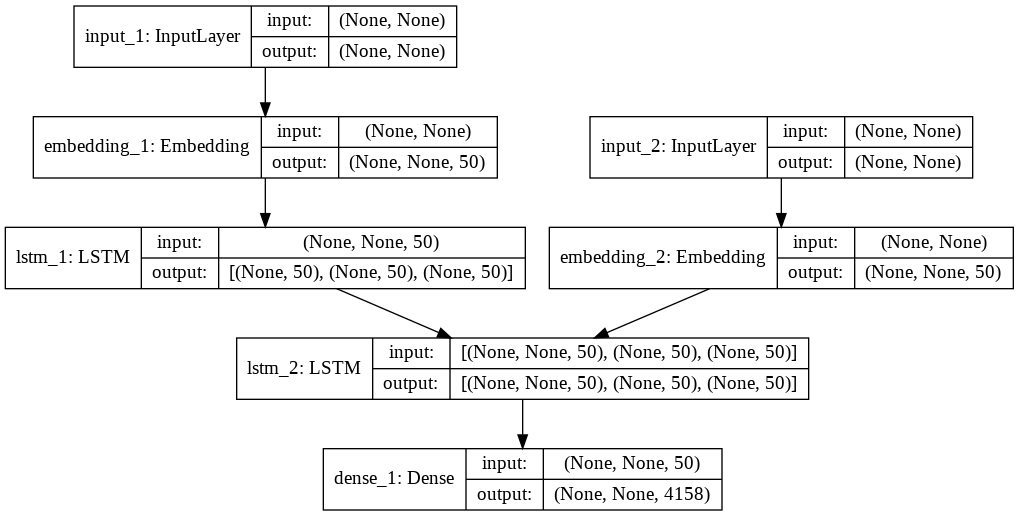

In [ ]:
model, encoder_model, decoder_model = seq2seq(num_decoder_tokens, num_encoder_tokens, emb_sz, emb_sz)
print(model.summary())
plot_model(model, show_shapes=True, show_layer_names=True)

#### Fit the model

In [ ]:
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=64,
          epochs=30,
          validation_split=0.05)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 5270 samples, validate on 278 samples
Epoch 1/30
5270/5270 [==============================] - 62s 12ms/step - loss: 1.6537 - acc: 0.9239 - val_loss: 0.5835 - val_acc: 0.9447
Epoch 2/30
5270/5270 [==============================] - 60s 11ms/step - loss: 0.4829 - acc: 0.9353 - val_loss: 0.4120 - val_acc: 0.9447
Epoch 3/30
5270/5270 [==============================] - 59s 11ms/step - loss: 0.4060 - acc: 0.9333 - val_loss: 0.4083 - val_acc: 0.9446
Epoch 4/30
5270/5270 [==============================] - 58s 11ms/step - loss: 0.3910 - acc: 0.9342 - val_loss: 0.4109 - val_acc: 0.9447
Epoch 5/30
5270/5270 [==============================] - 61s 12ms/step - loss: 0.3836 - acc: 0.9321 - val_loss: 0.4158 - val_acc: 0.9399
Epoch 6/30
5270/5270 [==============================] - 60s 11ms/step - loss: 0.3782 - acc: 0.9295 - val_loss: 0.4183 - val_acc: 0.9400
Epoch 7/30
5270/5270 [==============================] - 59s 11ms/step - loss: 0.3734 - acc: 0.9276 - val_loss: 0.4156 - val_acc: 0.9352
E

# Embedding + `mask_zero`

In [ ]:
def seq2seq(num_decoder_tokens, num_encoder_tokens, emb_sz, lstm_sz):
  encoder_inputs = Input(shape=(None,))
  en_x=  Embedding(num_encoder_tokens, emb_sz, mask_zero=True)(encoder_inputs)
  encoder = LSTM(lstm_sz, return_state=True)
  encoder_outputs, state_h, state_c = encoder(en_x)
  # We discard `encoder_outputs` and only keep the states.
  encoder_states = [state_h, state_c]
  
  # Encoder model
  encoder_model = Model(encoder_inputs, encoder_states)
  
  
  # Set up the decoder, using `encoder_states` as initial state.
  decoder_inputs = Input(shape=(None,))

  dex=  Embedding(num_decoder_tokens, emb_sz, mask_zero=True)

  final_dex= dex(decoder_inputs)


  decoder_lstm = LSTM(lstm_sz, return_sequences=True, return_state=True)

  decoder_outputs, _, _ = decoder_lstm(final_dex,
                                      initial_state=encoder_states)

  decoder_dense = Dense(num_decoder_tokens, activation='softmax')

  decoder_outputs = decoder_dense(decoder_outputs)

  model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

  model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])


  
  # Decoder model: Re-build based on explicit state inputs. Needed for step-by-step inference:
  decoder_state_input_h = Input(shape=(lstm_sz,))
  decoder_state_input_c = Input(shape=(lstm_sz,))
  decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

  decoder_outputs2, state_h2, state_c2 = decoder_lstm(final_dex, initial_state=decoder_states_inputs)
  decoder_states2 = [state_h2, state_c2]
  decoder_outputs2 = decoder_dense(decoder_outputs2)
  decoder_model = Model(
  [decoder_inputs] + decoder_states_inputs,
  [decoder_outputs2] + decoder_states2)  

  return model, encoder_model, decoder_model


In [ ]:
emb_sz = 256
model, encoder_model, decoder_model = seq2seq(num_decoder_tokens, num_encoder_tokens, emb_sz, emb_sz)
print(model.summary())
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=64,
          epochs=10,
          validation_split=0.2)

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 256)    1807872     input_5[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, None, 256)    1064448     input_6[0][0]                    
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 4438 samples, validate on 1110 samples
Epoch 1/10
4438/4438 [==============================] - 75s 17ms/step - loss: 0.4529 - acc: 0.1155 - val_loss: 0.2967 - val_acc: 0.1808
Epoch 2/10
4438/4438 [==============================] - 72s 16ms/step - loss: 0.4004 - acc: 0.1625 - val_loss: 0.2940 - val_acc: 0.1903
Epoch 3/10
4438/4438 [==============================] - 73s 16ms/step - loss: 0.3764 - acc: 0.1785 - val_loss: 0.2797 - val_acc: 0.1968
Epoch 4/10
4438/4438 [==============================] - 74s 17ms/step - loss: 0.3528 - acc: 0.1974 - val_loss: 0.2826 - val_acc: 0.2028
Epoch 5/10
4438/4438 [==============================] - 72s 16ms/step - loss: 0.3308 - acc: 0.2243 - val_loss: 0.2709 - val_acc: 0.2355
Epoch 6/10
4438/4438 [==============================] - 73s 16ms/step - loss: 0.3111 - acc: 0.2573 - val_loss: 0.2626 - val_acc: 0.2545
Epoch 7/10
4438/4438 [==============================] - 72s 16ms/step - loss: 0.2916 - acc: 0.2950 - val_loss: 0.2563 - val_acc: 0.2858


Adding `mask_zero` in Embedding would stop any input zeros (padding) from propagating through the network

But what about the output? It remains same as last one!:

https://stackoverflow.com/questions/47485216/how-does-mask-zero-in-keras-embedding-layer-work/53470422

So the output accuracy is hurt, since the GT assumes ALL 0's!

However, the mask should be passed to subsequent layers, so something is wrong!

The reason is that, with mask_zero we don't include all the padded words to the accuracy calculation. Adding those words makes it easy to the network to predict the correct output for them, since we add a special token for that (PAD-->0), and we mark the end of the  sequence with another special token (END), so it's easy to capture the pattern after END to produce the correct output. So adding those padded words would just increase _false_ accuracy. Similar to the class imbalance problem, the dominant class now wil be the PAD words. Adding mask_zero will include just the _important_ words in accuracy calculation.


# Inference

The inference process involves decoding the output using sequential process of:
- Encode the whole input sequence
- Kick-start the decoder with the final encoder state + the start_token
- Feed-back the output of the decoder to its input (instead of teacher forcing in training).

This will create a need to build _view_ decoder model with the following `list` of inputs:
- `decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]` --> from the encoder final $h_T, C_T$. This will be the decoder initial state $h_0, C_0$
- `decoder_inputs` = `start_tok` + `decoder_outputs` --> $x_{t-1}$, with $x_0$ = `start_tok`

And outputs:
- `decoder_outputs`: $x_t$; softmax tokens probabilities 
- `decoder_states`: [$h_t,C_t$]

#### Create sampling model

In [ ]:
decoder_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, None, 256)    1064448     input_6[0][0]                    
__________________________________________________________________________________________________
input_7 (InputLayer)            (None, 256)          0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 256)          0                                            
____________________________________________________________________________________________

#### Function to generate sequences

In [ ]:
def decode_sequence(input_seq, sep=' '):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index[st_tok]

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_tok = reverse_target_tok_index[sampled_token_index]
        decoded_sentence += sep + sampled_tok

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_tok == end_tok or
           len(decoded_sentence) > 52):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

#### Look at the some translations

In [ ]:
for seq_index in range(100): #[14077,20122,40035,40064, 40056, 40068, 40090, 40095, 40100, 40119, 40131, 40136, 40150, 40153]:
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', lines.input[seq_index: seq_index + 1])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: 0    claim type vb accident  accidental injury
Name: input, dtype: object
Decoded sentence:  claim type vb accident accidental injury _END
-
Input sentence: 1    “tho th  reported even  happen ed to enployeef...
Name: input, dtype: object
Decoded sentence:  this the patient event happened to employeepolicyholder
-
Input sentence: 2    pol inyhold elmchm er  form arlon
Name: input, dtype: object
Decoded sentence:  policyholderowner information _END
-
Input sentence: 3    first name
Name: input, dtype: object
Decoded sentence:  tier family moop _END
-
Input sentence: 4    middle nameﬂnitial
Name: input, dtype: object
Decoded sentence:  tier family moop _END
-
Input sentence: 5    last name
Name: input, dtype: object
Decoded sentence:  tier family moop _END
-
Input sentence: 6    social s ecurity number
Name: input, dtype: object
Decoded sentence:  tier family max _END
-
Input sentence: 7    birth date
Name: input, dtype: object
Decoded sentence:  tier family moop _END
-

# seq2seq + Attention

The vanilla seq2seq suffers a severe drawback, all the decoded outputs are initiated from the _final_ internal state of the encoder. The objective is to mimic the reading process in humans, where the whole sequence is comprehended first, then translation (decoding) happens based on that. 

However, it is clear that, even we as humans will not generate the whole translations without looking back at the _concerned_ parts of the input text. In other words, every translated word is usually generated by _attending_ to certain words in the input, in sequence.

So it is better to _condition_ the decoded words on certain words of the input. But who decides which words to attend to when generating/decoding output word?

## Bahdanau attention
The idea of attention in seq2seq was introduced in [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473):

![Bahdanau](https://pravn.files.wordpress.com/2017/11/bahdanau.png?w=203)

The decoder LSTM will have the following inputs:
- previous outputs $y_{t-1}$
- state composed of concatenation of:

1- previous state $s_{t-1}$ = $[h_{t-1}, C_{t-1}]$

2- context vector $c_t$ = weighted/gated encoder states $h_j$ = $\sum_{j=0}^{j=T} \alpha_{tj}h_j$ 

$\alpha_{tj}$ are the ___attention___ weights. Those can be visualized as the importance of input word $j$ when decoding output word $t$:

![att_map](https://miro.medium.com/max/6400/1*T6oosC9Y9vS5AIh4GzcsNQ.png)

__How to find those weights?__

The alphas can be learnable. However, they must be related somehow to the simialrity between input word $j$ and output word $t$.

In the paper [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473), this simialrity measure was _leaned_ using a feedforward NN $a$, which generates a score $e_{tj}$ based on leanable weights over the last decoder state and the encoder state: $e_{tj} = a(s_{t-1}, h_j)$. Those scores are then normalized via simple _softmax_.




## Luong attention
In [Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/abs/1508.04025), other simialrity measures are studied to encode the _attention map weights_ or $\alpha_{tj}$. Three simialrity scores $e_{tj}$are studied:
- general = weighted dot product
- concat = Bahdanau (weighted dot + tanh)
- dot = simple dot product

Again, the alphas are just simple softmax: $\alpha_{tj} = softmax(e_{tj})$ over $j \in [0,T]$ in the encoder state $h_j$
Moreover, in Bahdanaus, in Bi-LSTM, both directions states are concatenated. While in Luong, only the top one is used.

In our experiments, we adopt the simpler Luong, with dot configuration.

In [ ]:
def seq2seq_attention(num_encoder_tokens, num_decoder_tokens, emb_sz, latent_dim):
    # Define an input sequence and process it.
    encoder_inputs = Input(shape=(None,), dtype='float32')
    encoder_inputs_ = Embedding(num_encoder_tokens, emb_sz, mask_zero=True)(encoder_inputs)    
    
    encoder = Bidirectional(LSTM(latent_dim, return_state=True, return_sequences=True)) # Bi LSTM
    encoder_outputs, state_f_h, state_f_c, state_b_h, state_b_c = encoder(encoder_inputs_)# Bi LSTM
    state_h = Concatenate()([state_f_h, state_b_h])# Bi LSTM
    state_c = Concatenate()([state_f_c, state_b_c])# Bi LSTM

    # We discard `encoder_outputs` and only keep the states.
    encoder_states = [state_h, state_c]# Bi GRU, LSTM, BHi LSTM
    print(encoder_states)
    
    decoder_inputs = Input(shape=(None,))
    decoder_inputs_ = Embedding(num_decoder_tokens, emb_sz, mask_zero=True)(decoder_inputs)    
    # We set up our decoder to return full output sequences,
    # and to return internal states as well. We don't use the
    # return states in the training model, but we will use them in inference.
    decoder_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True)# Bi LSTM
    
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs_, initial_state=encoder_states)

    # Equation (7) with 'dot' score from Section 3.1 in the paper.
    # Note that we reuse Softmax-activation layer instead of writing tensor calculation
    print(decoder_outputs)
    print(encoder_outputs)
    att_dot = Dot(axes=[2, 2])
    attention = att_dot([decoder_outputs, encoder_outputs])
    att_activation = Activation('softmax', name='attention')
    attention = att_activation(attention)
    print('attention', attention)
    context_dot = Dot(axes=[2,1])
    context = context_dot([attention, encoder_outputs])
    att_context_concat = Concatenate()
    decoder_combined_context = att_context_concat([context, decoder_outputs])

    # Has another weight + tanh layer as described in equation (5) of the paper

    decoder_dense = Dense(num_decoder_tokens, activation='softmax')
    #decoder_outputs = decoder_dense(decoder_outputs)
    decoder_outputs = decoder_dense(decoder_combined_context)

    # Define the model that will turn
    # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

    print('encoder-decoder  model:')
    print(model.summary()) 
    
    print(encoder_inputs)
    print(encoder_outputs)
    print(encoder_states)
    encoder_model = Model(input=encoder_inputs, output=[encoder_outputs] + encoder_states)

    decoder_encoder_inputs = Input(shape=(None, latent_dim*2,))
    decoder_state_input_h = Input(shape=(latent_dim*2,))# Bi LSTM
    decoder_state_input_c = Input(shape=(latent_dim*2,)) # Bi LSTM
    
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    
    decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_, initial_state=decoder_states_inputs)

    
    decoder_states = [state_h, state_c]
    
    # Equation (7) with 'dot' score from Section 3.1 in the paper.
    # Note that we reuse Softmax-activation layer instead of writing tensor calculation
    
    attention = att_dot([decoder_outputs, decoder_encoder_inputs])
    
    attention = att_activation(attention)
    
    context = context_dot([attention, decoder_encoder_inputs])
    
    
    
    decoder_combined_context = att_context_concat([context, decoder_outputs])
    
    # Has another weight + tanh layer as described in equation (5) of the paper
    
    decoder_outputs = decoder_dense(decoder_combined_context)
    
    decoder_model = Model(
        [decoder_inputs, decoder_encoder_inputs] + decoder_states_inputs,
        [decoder_outputs, attention] + decoder_states)
    
    return model, encoder_model, decoder_model

[<tf.Tensor 'concatenate_1/concat:0' shape=(None, 512) dtype=float32>, <tf.Tensor 'concatenate_2/concat:0' shape=(None, 512) dtype=float32>]
Tensor("lstm_6/transpose_2:0", shape=(None, None, 512), dtype=float32)
Tensor("bidirectional_1/concat:0", shape=(None, None, 512), dtype=float32)
attention Tensor("attention/truediv:0", shape=(None, None, None), dtype=float32)
encoder-decoder  model:
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, None, 256)    1807872     input_9[0][0]                    
________________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`


Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, None, 256)    1807872     input_9[0][0]                    
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, None)         0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, None, 512),  1050624     embedding_5[0][0]                
____________________________________________________________________________________________

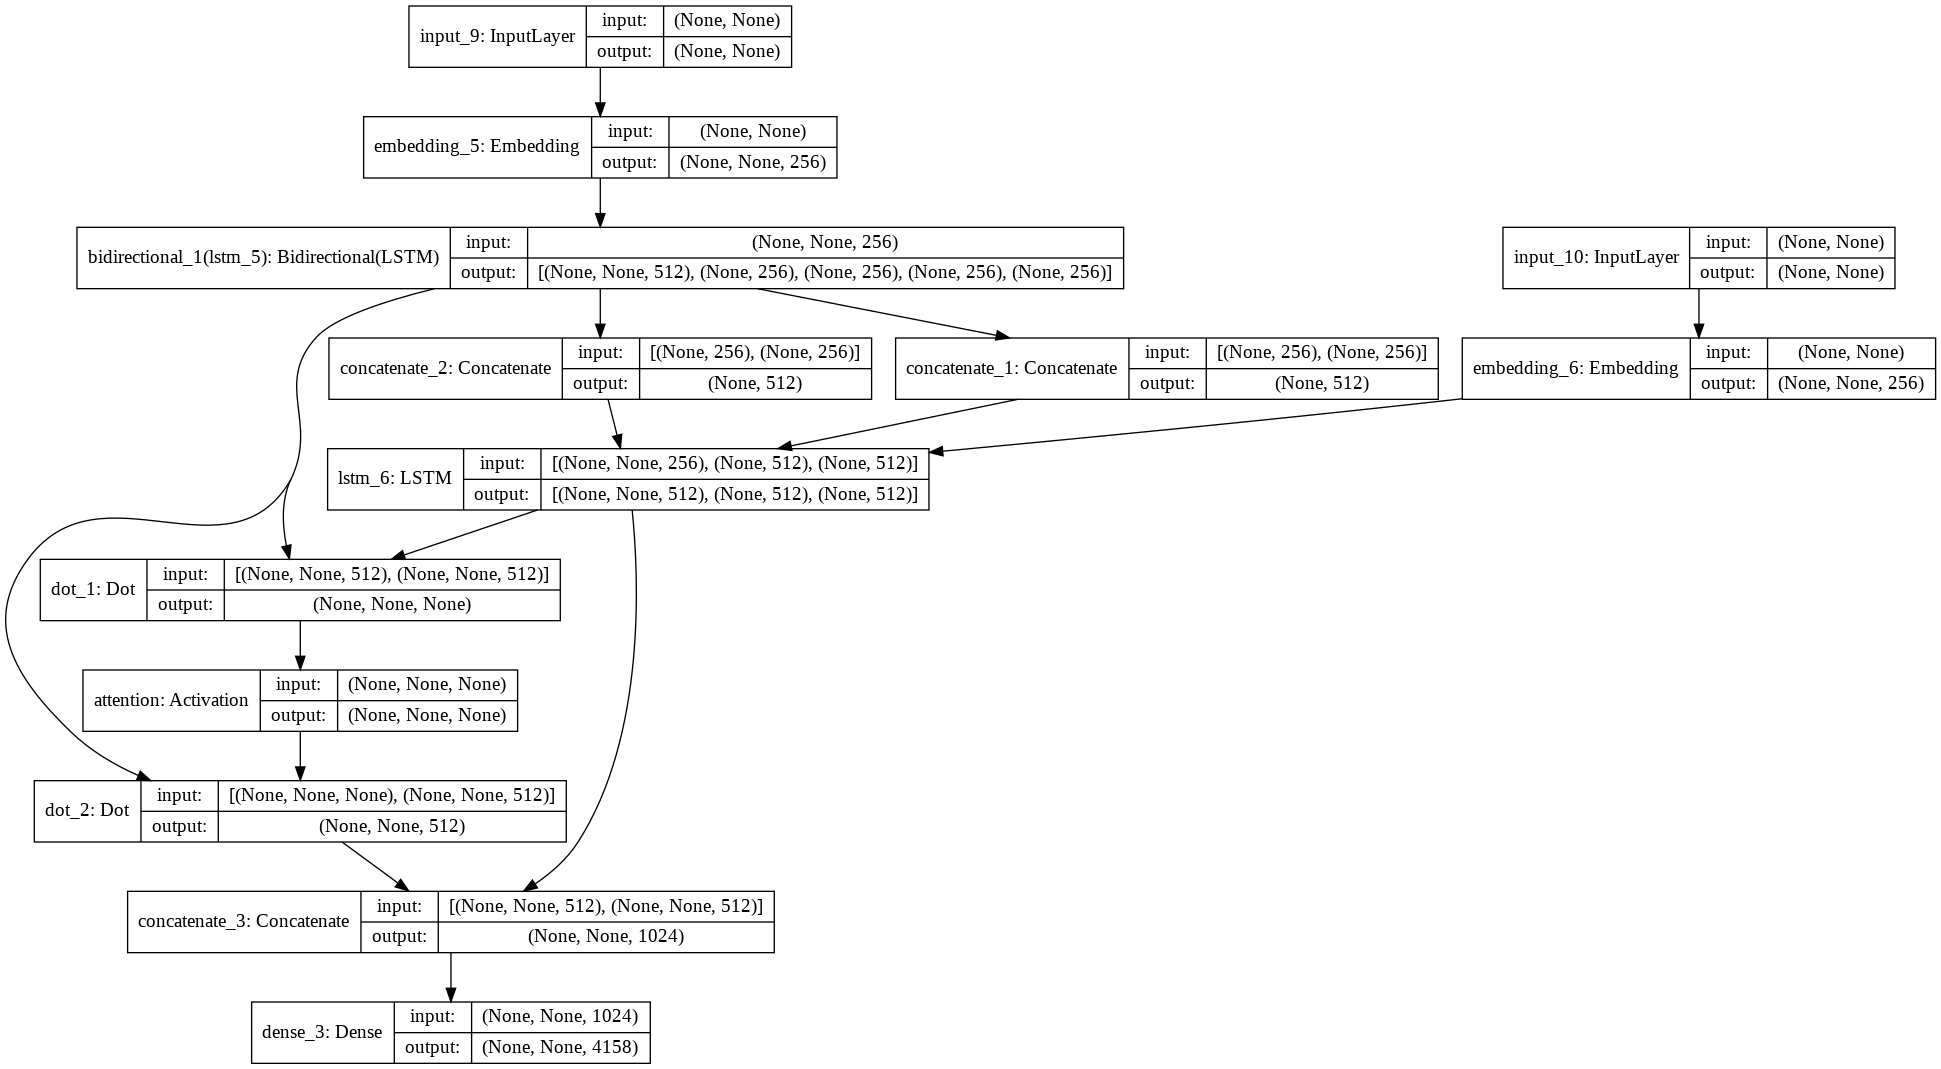

In [ ]:
model, encoder_model, decoder_model = seq2seq_attention(num_encoder_tokens, num_decoder_tokens, emb_sz=emb_sz, latent_dim=emb_sz)
print(model.summary())
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:

model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=128,
          epochs=20,
          validation_split=0.05)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 5270 samples, validate on 278 samples
Epoch 1/20
5270/5270 [==============================] - 74s 14ms/step - loss: 0.4282 - acc: 0.1021 - val_loss: 0.4033 - val_acc: 0.1694
Epoch 2/20
5270/5270 [==============================] - 72s 14ms/step - loss: 0.3715 - acc: 0.1569 - val_loss: 0.4119 - val_acc: 0.1878
Epoch 3/20
5270/5270 [==============================] - 71s 13ms/step - loss: 0.3381 - acc: 0.1836 - val_loss: 0.4023 - val_acc: 0.1926
Epoch 4/20
5270/5270 [==============================] - 73s 14ms/step - loss: 0.3063 - acc: 0.2275 - val_loss: 0.3985 - val_acc: 0.1950
Epoch 5/20
5270/5270 [==============================] - 71s 13ms/step - loss: 0.2759 - acc: 0.2955 - val_loss: 0.4023 - val_acc: 0.2093
Epoch 6/20
5270/5270 [==============================] - 72s 14ms/step - loss: 0.2471 - acc: 0.3598 - val_loss: 0.3904 - val_acc: 0.2171
Epoch 7/20
5270/5270 [==============================] - 72s 14ms/step - loss: 0.2217 - acc: 0.4148 - val_loss: 0.4087 - val_acc: 0.2165
E

In [ ]:
def decode_sequence_attention(input_seq, sep=' '):
    # Encode the input as state vectors.
    encoder_outputs, h, c = encoder_model.predict(input_seq)
    states_value = [h,c]
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index[st_tok]

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    attention_density = []
    while not stop_condition:
        output_tokens, attention, h, c  = decoder_model.predict(
            [target_seq, encoder_outputs] + states_value)
        attention_density.append(attention[0][0])# attention is max_sent_len x 1 since we have num_time_steps = 1 for the output
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_tok = reverse_target_tok_index[sampled_token_index]
        decoded_sentence += sep + sampled_tok

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_tok == end_tok or
           len(decoded_sentence) > 52):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]
    attention_density = np.array(attention_density)
    return decoded_sentence, attention_density

In [ ]:
word_decoded_sents = []
for seq_index in range(100): #[14077,20122,40035,40064, 40056, 40068, 40090, 40095, 40100, 40119, 40131, 40136, 40150, 40153]:
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence, attention = decode_sequence_attention(input_seq)
    print('-')
    print('Input sentence:', lines.input[seq_index: seq_index + 1])
    print('Decoded sentence:', decoded_sentence)
    word_decoded_sents.append(decoded_sentence)

-
Input sentence: 0    claim type vb accident  accidental injury
Name: input, dtype: object
Decoded sentence:  claim type vb accident accidental injury _END
-
Input sentence: 1    “tho th  reported even  happen ed to enployeef...
Name: input, dtype: object
Decoded sentence:  who the reported event happened to employeepolicyholder
-
Input sentence: 2    pol inyhold elmchm er  form arlon
Name: input, dtype: object
Decoded sentence:  policyholderowner information _END
-
Input sentence: 3    first name
Name: input, dtype: object
Decoded sentence:  • strain COMMA fl _END
-
Input sentence: 4    middle nameﬂnitial
Name: input, dtype: object
Decoded sentence:  • strain COMMA fl _END
-
Input sentence: 5    last name
Name: input, dtype: object
Decoded sentence:  • strain COMMA fl _END
-
Input sentence: 6    social s ecurity number
Name: input, dtype: object
Decoded sentence:  social security number _END
-
Input sentence: 7    birth date
Name: input, dtype: object
Decoded sentence:  • strain COMM

In [ ]:
def visualize_attention(text, encoder_model, decoder_model, max_encoder_seq_length, num_decoder_tokens, vocab_to_int, int_to_vocab, tok_split_fn, sep= ' '):

    encoder_input_data = np.zeros((1, max_encoder_seq_length), dtype='float32')
    
    for t, word in enumerate(tok_split_fn(text)):
        encoder_input_data[0, t] = input_token_index[word]

    input_seq = encoder_input_data[0:1]

    decoded_sentence, attention_density = decode_sequence_attention(input_seq, sep)

    plt.clf()
    plt.figure(figsize=(28,12))
    
    ax = sns.heatmap(attention_density[:, : len(text) + 2],
        xticklabels=[w for w in tok_split_fn(text)],
        yticklabels=[w for w in tok_split_fn(decoded_sentence)])

    ax.invert_yaxis()
    plt.show()
    
    return decoded_sentence

-
Input sentence: claim type vb accident  accidental injury
GT sentence: START_ claim type vb accident  accidental injury _END


<Figure size 432x288 with 0 Axes>

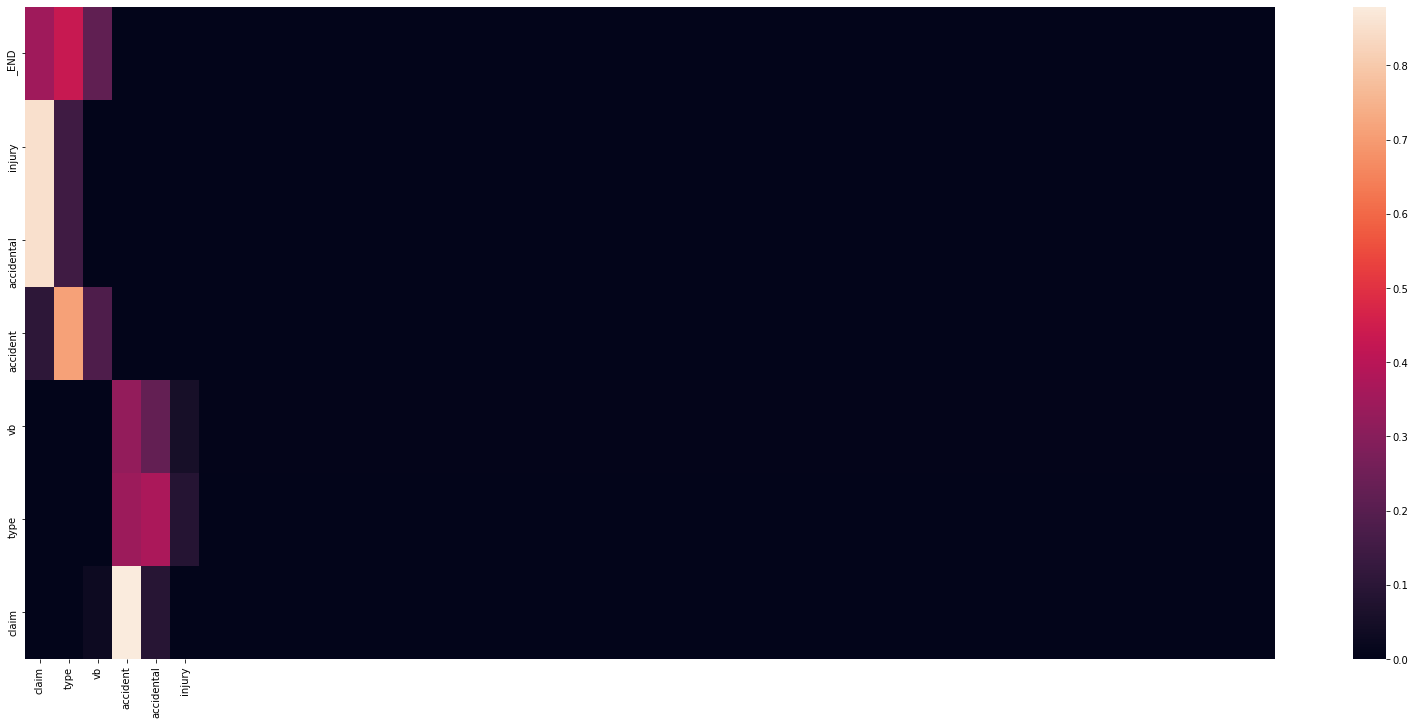

Decoded sentence:  claim type vb accident accidental injury _END
-
Input sentence: “tho th  reported even  happen ed to enployeefpolicyholder
GT sentence: START_ who the reported event happened to employeepolicyholder _END


<Figure size 432x288 with 0 Axes>

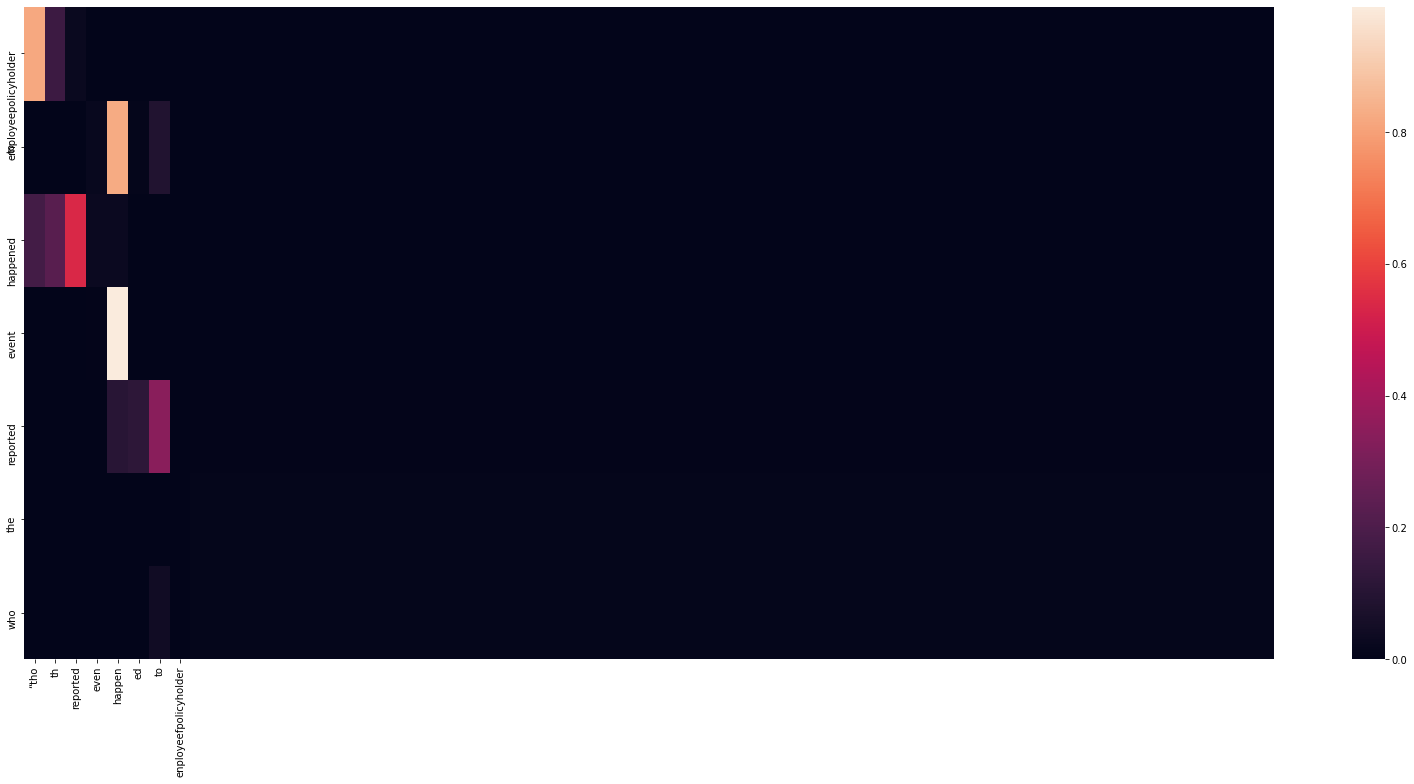

Decoded sentence:  who the reported event happened to employeepolicyholder
-
Input sentence: pol inyhold elmchm er  form arlon
GT sentence: START_ policyholderowner information _END


<Figure size 432x288 with 0 Axes>

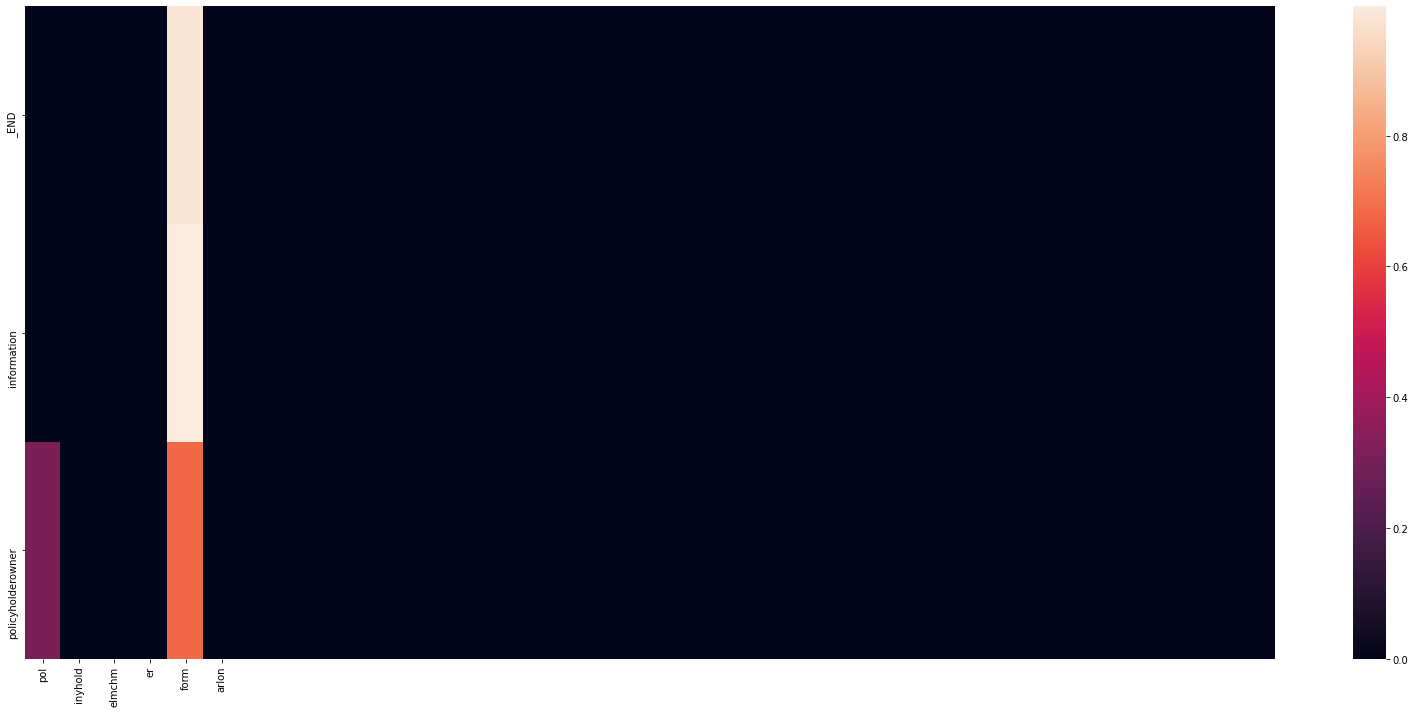

Decoded sentence:  policyholderowner information _END
-
Input sentence: first name
GT sentence: START_ first name _END


<Figure size 432x288 with 0 Axes>

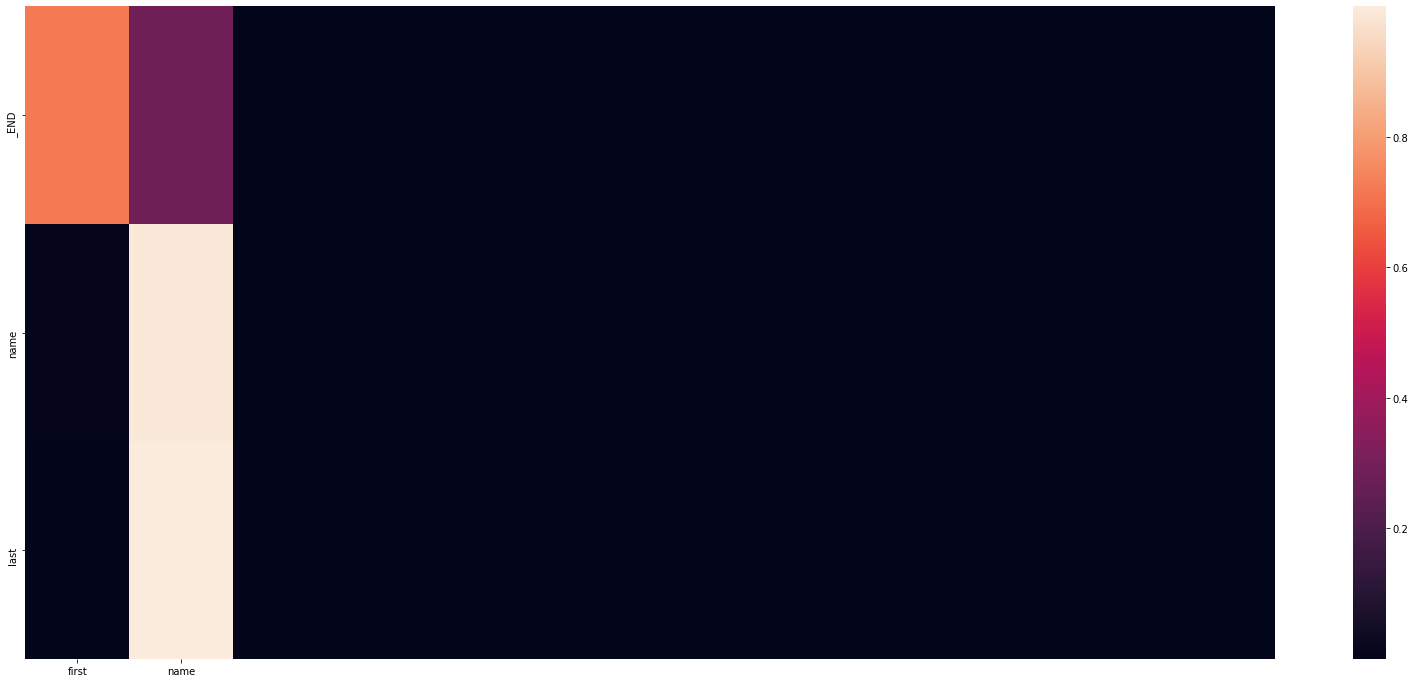

Decoded sentence:  last name _END
-
Input sentence: middle nameﬂnitial
GT sentence: START_ middle nameinitial _END


<Figure size 432x288 with 0 Axes>

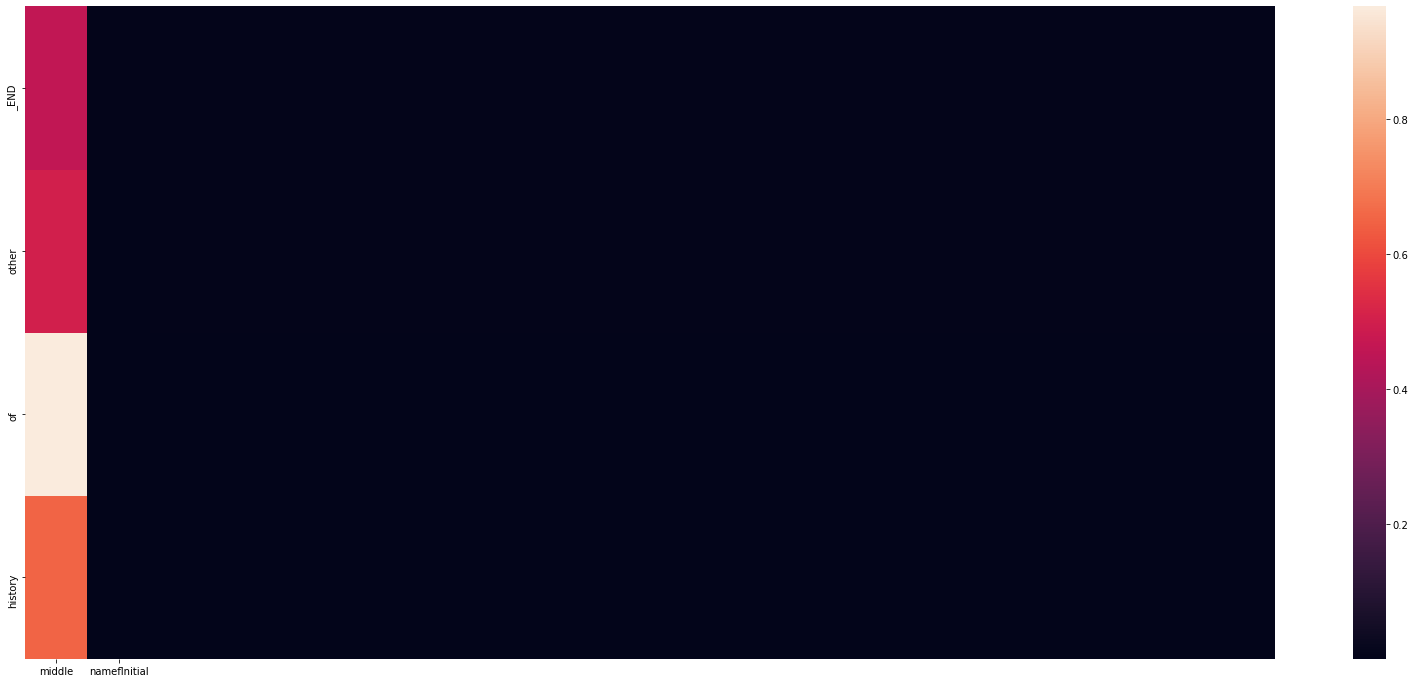

Decoded sentence:  history of other _END
-
Input sentence: last name
GT sentence: START_ last name _END


<Figure size 432x288 with 0 Axes>

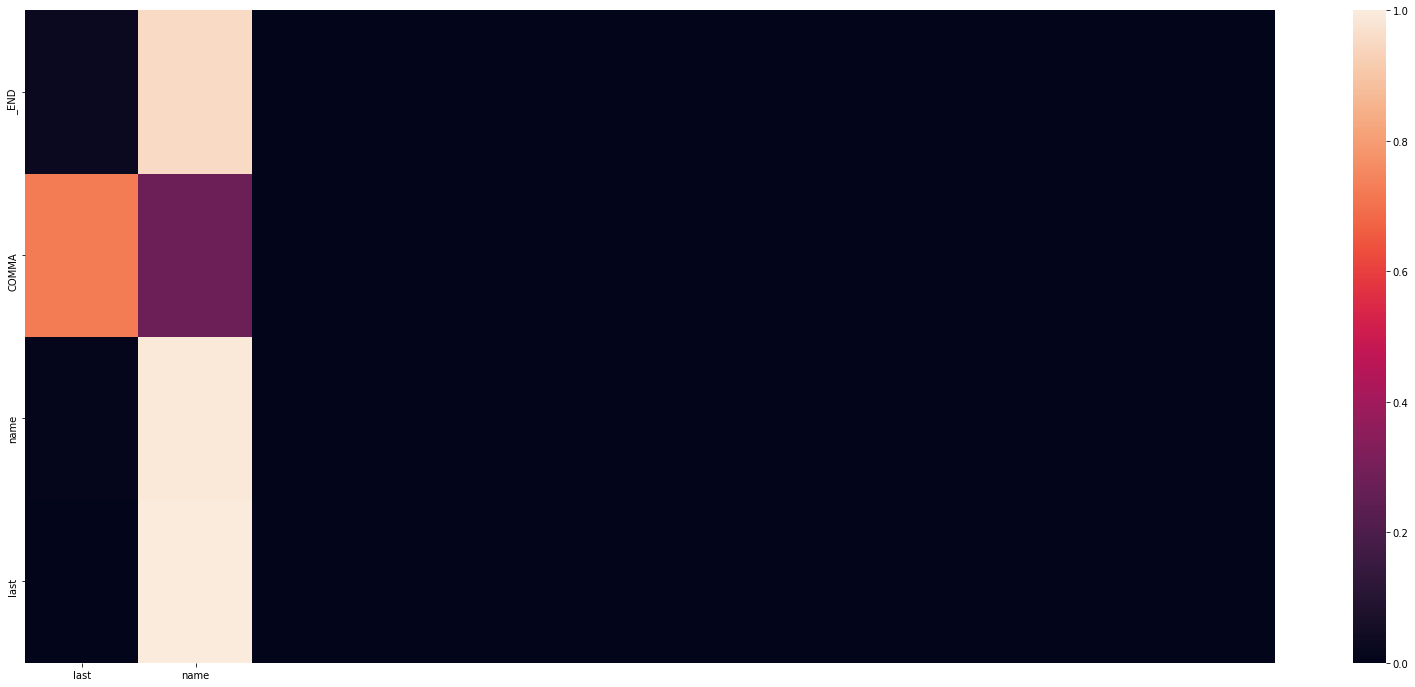

Decoded sentence:  last name COMMA _END
-
Input sentence: social s ecurity number
GT sentence: START_ social security number _END


<Figure size 432x288 with 0 Axes>

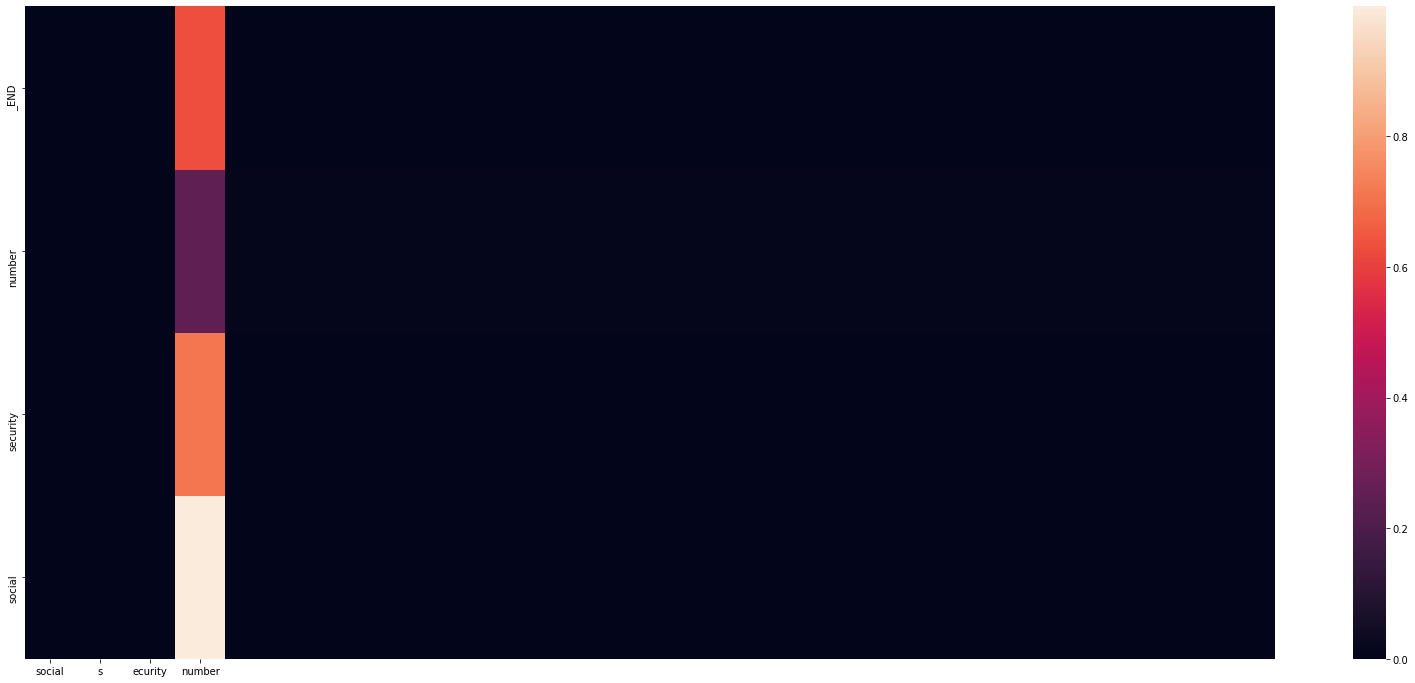

Decoded sentence:  social security number _END
-
Input sentence: birth date
GT sentence: START_ birth date _END


<Figure size 432x288 with 0 Axes>

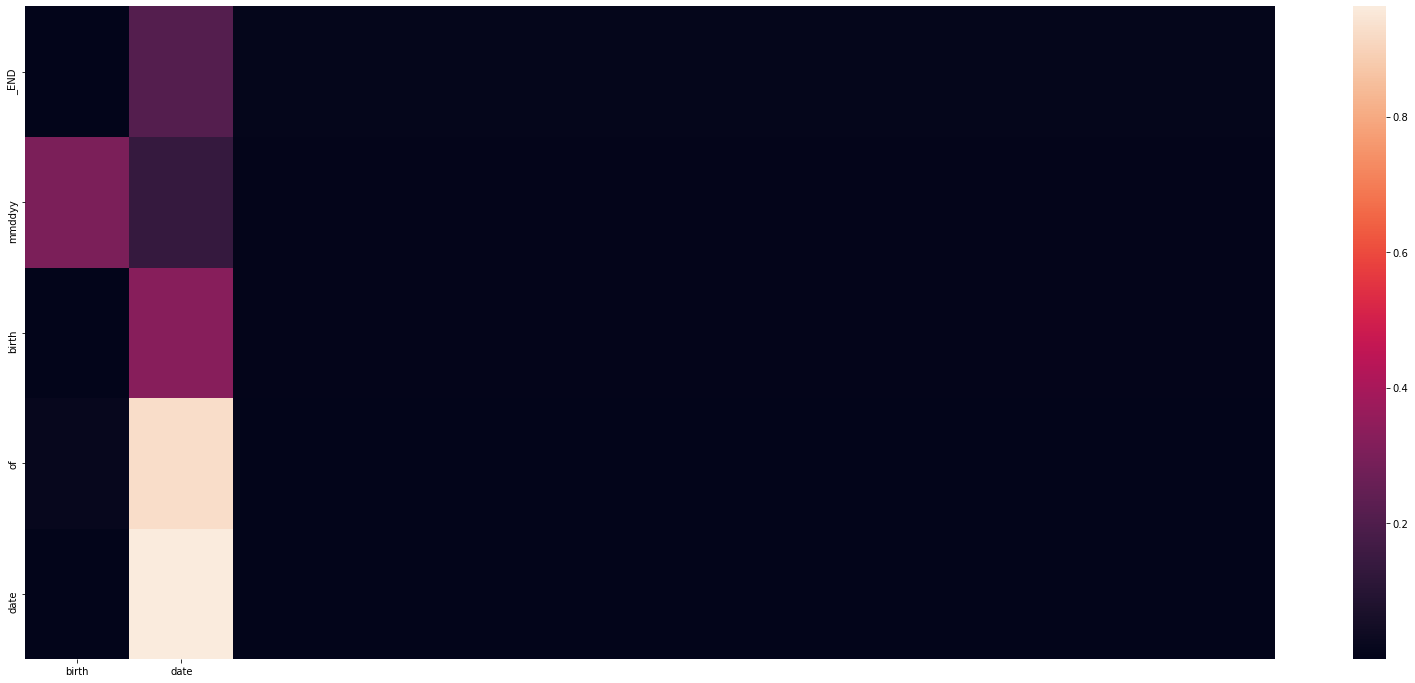

Decoded sentence:  date of birth mmddyy _END
-
Input sentence: gender
GT sentence: START_ gender _END


<Figure size 432x288 with 0 Axes>

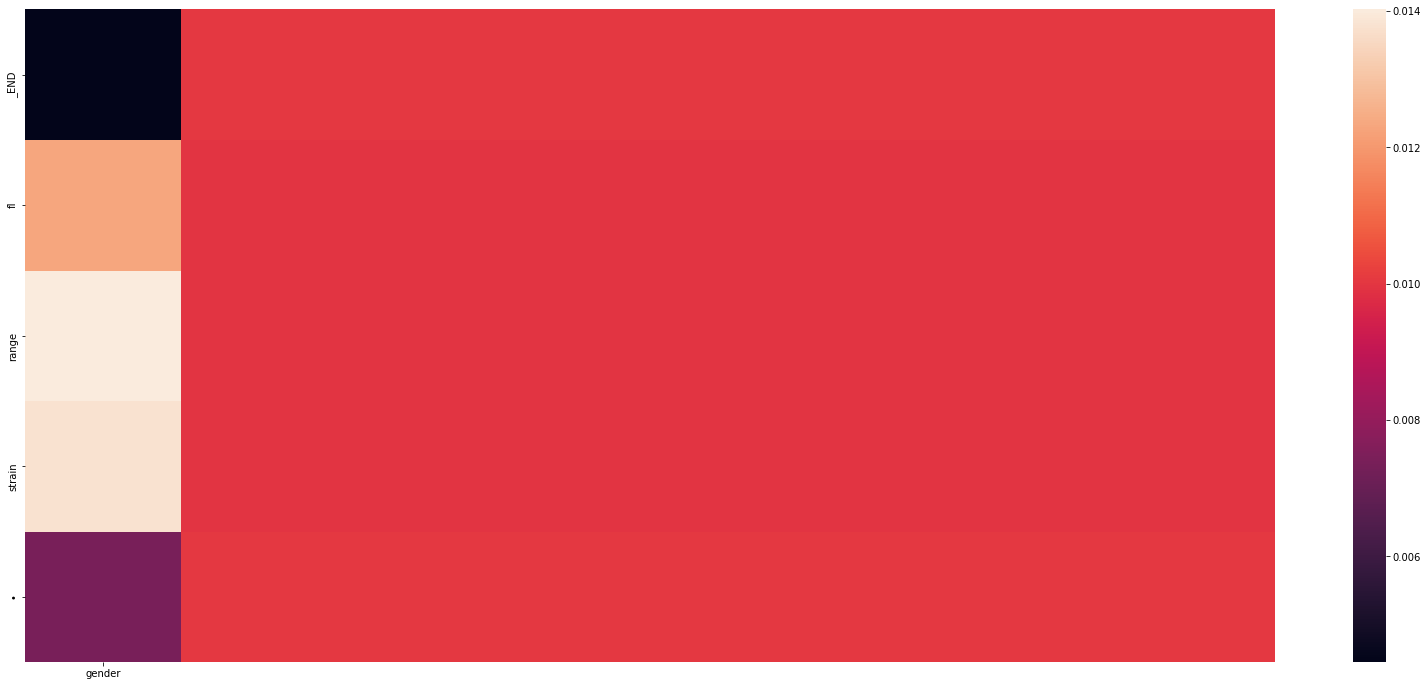

Decoded sentence:  • strain range fl _END
-
Input sentence: language preference
GT sentence: START_ language preference _END


<Figure size 432x288 with 0 Axes>

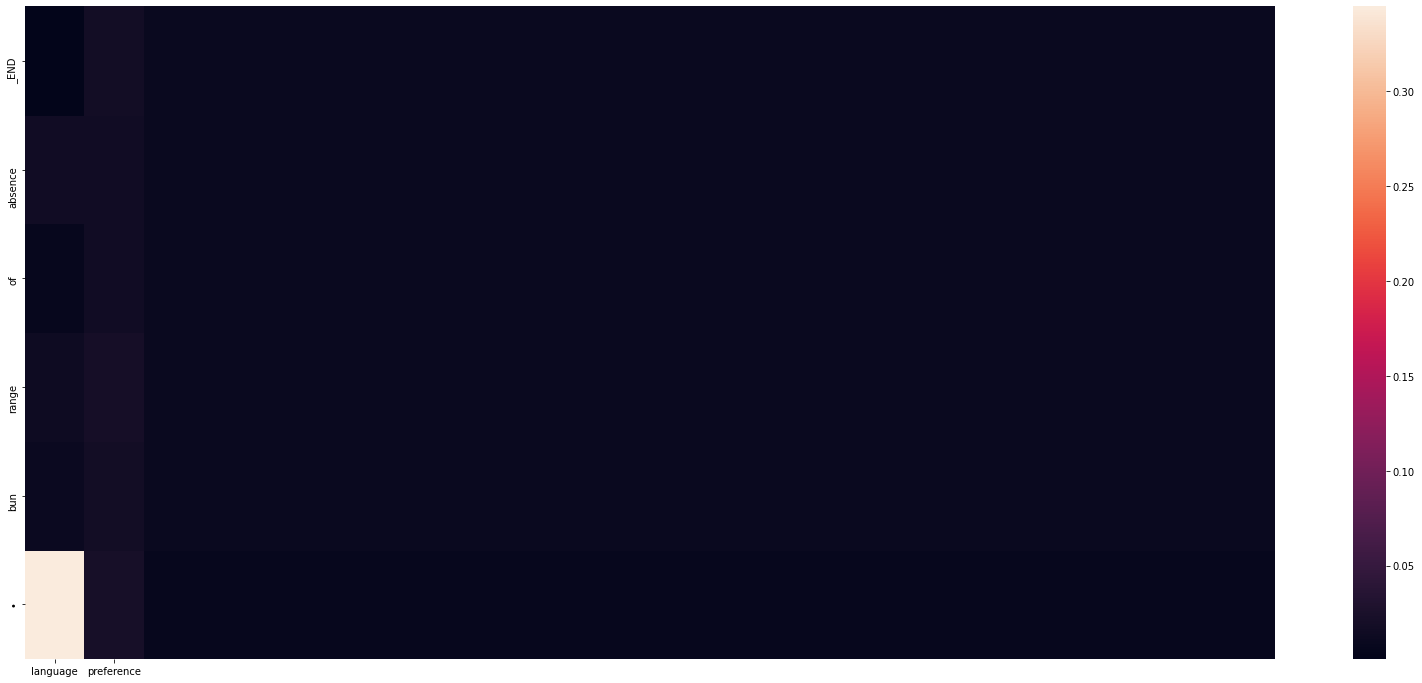

Decoded sentence:  • bun range of absence _END
-
Input sentence: address line 
GT sentence: START_ address line  _END


<Figure size 432x288 with 0 Axes>

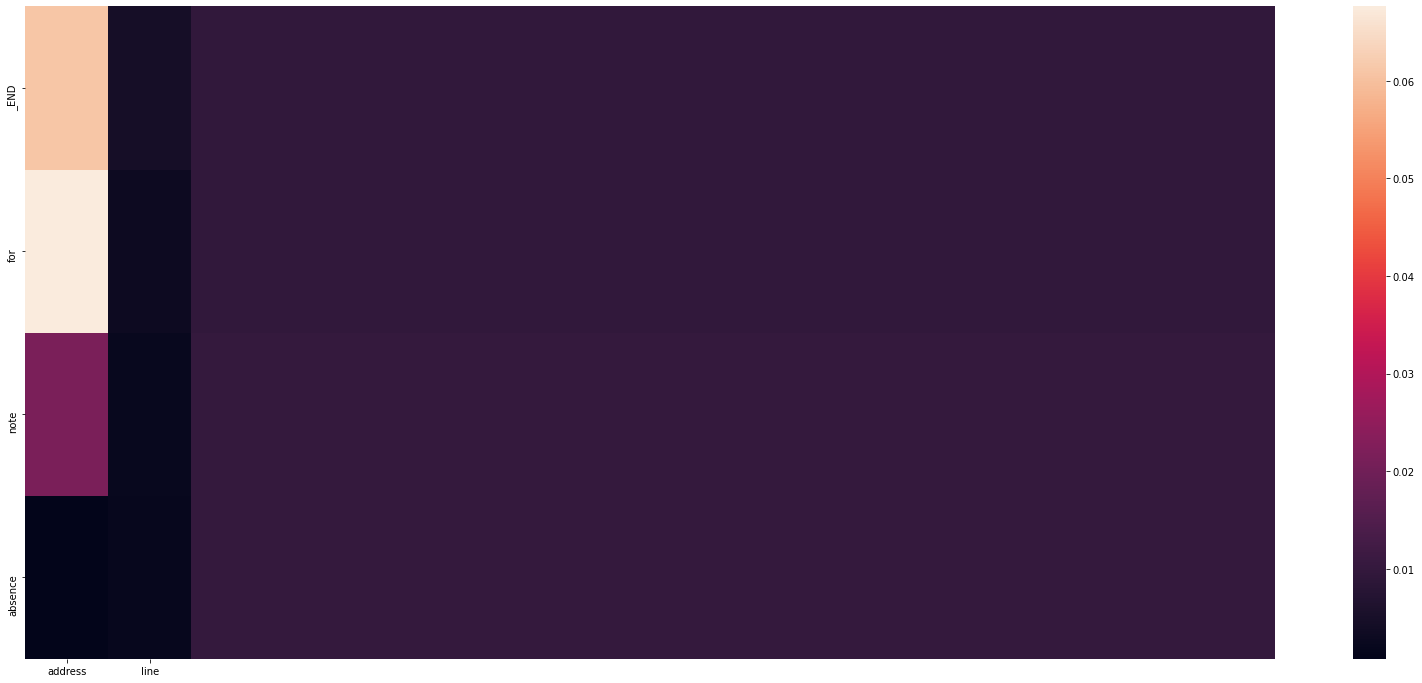

Decoded sentence:  absence note for _END
-
Input sentence: gw 
GT sentence: START_ city _END


<Figure size 432x288 with 0 Axes>

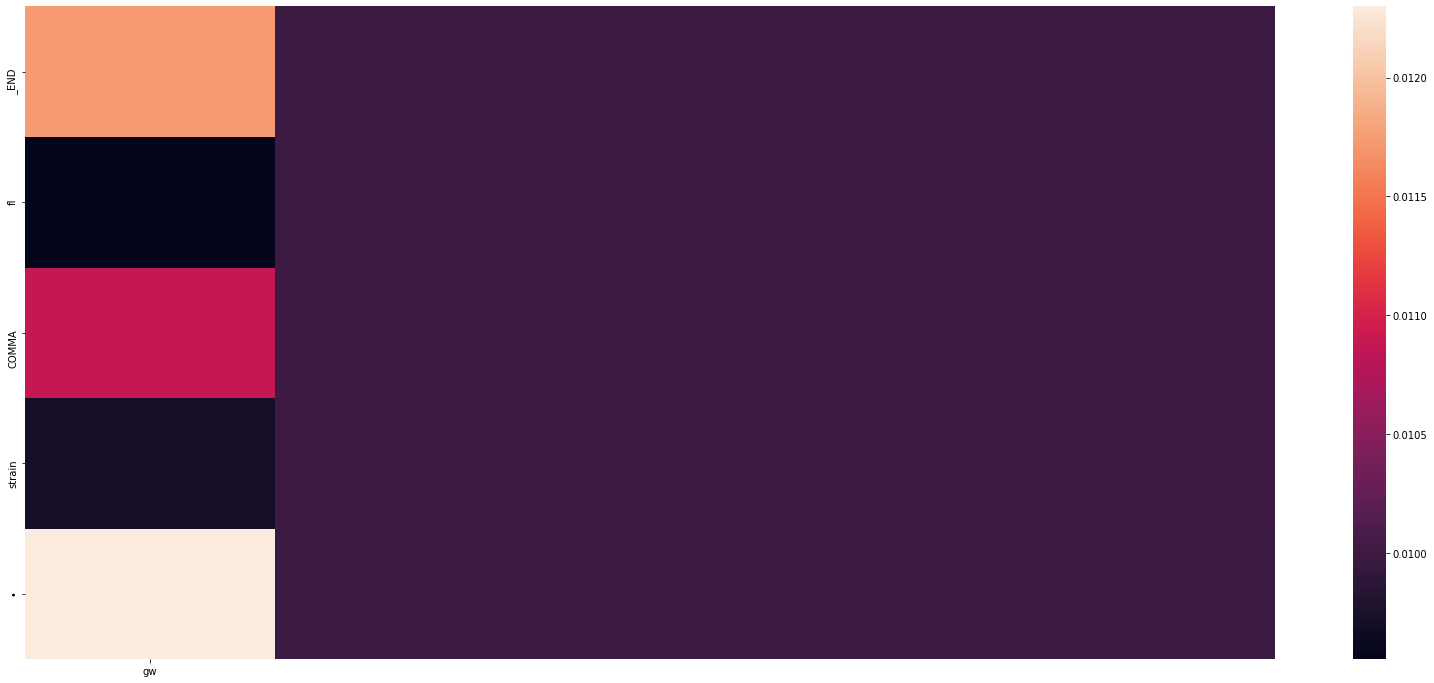

Decoded sentence:  • strain COMMA fl _END
-
Input sentence: statefprmince 
GT sentence: START_ stateprovince _END


<Figure size 432x288 with 0 Axes>

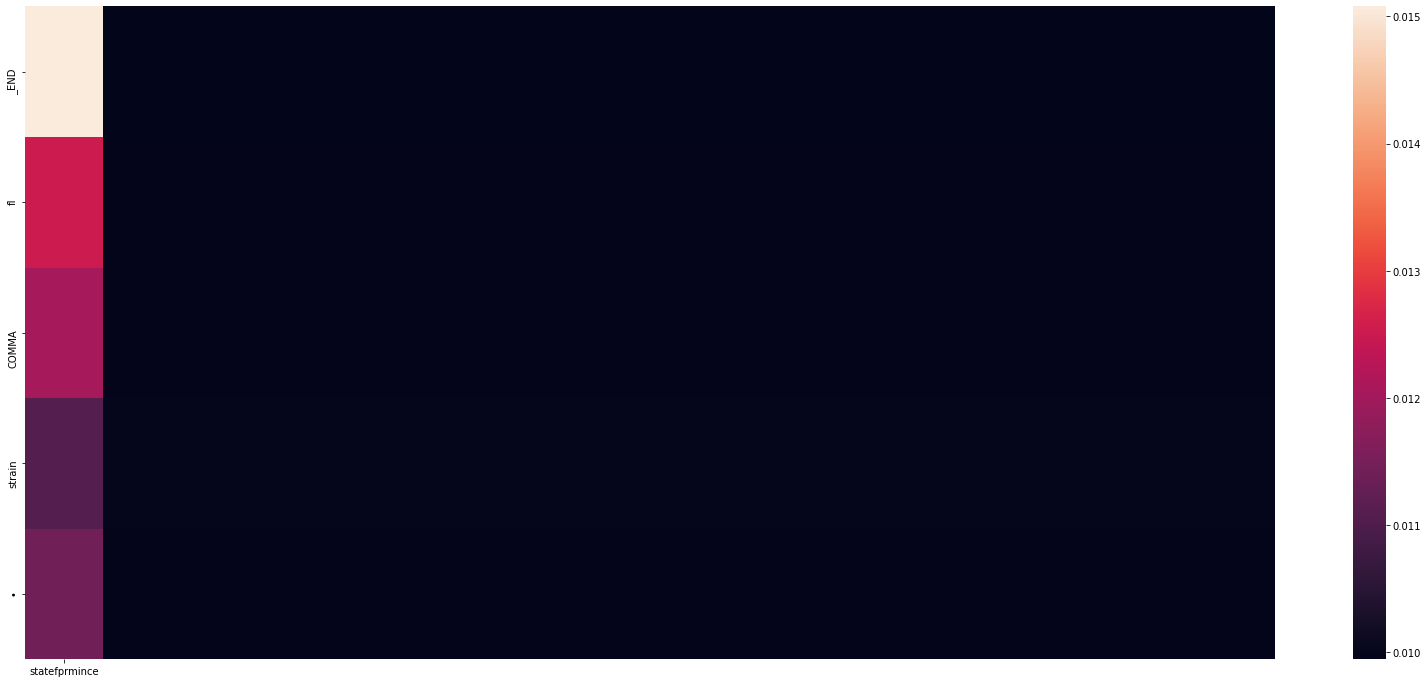

Decoded sentence:  • strain COMMA fl _END
-
Input sentence: postal code
GT sentence: START_ postal code _END


<Figure size 432x288 with 0 Axes>

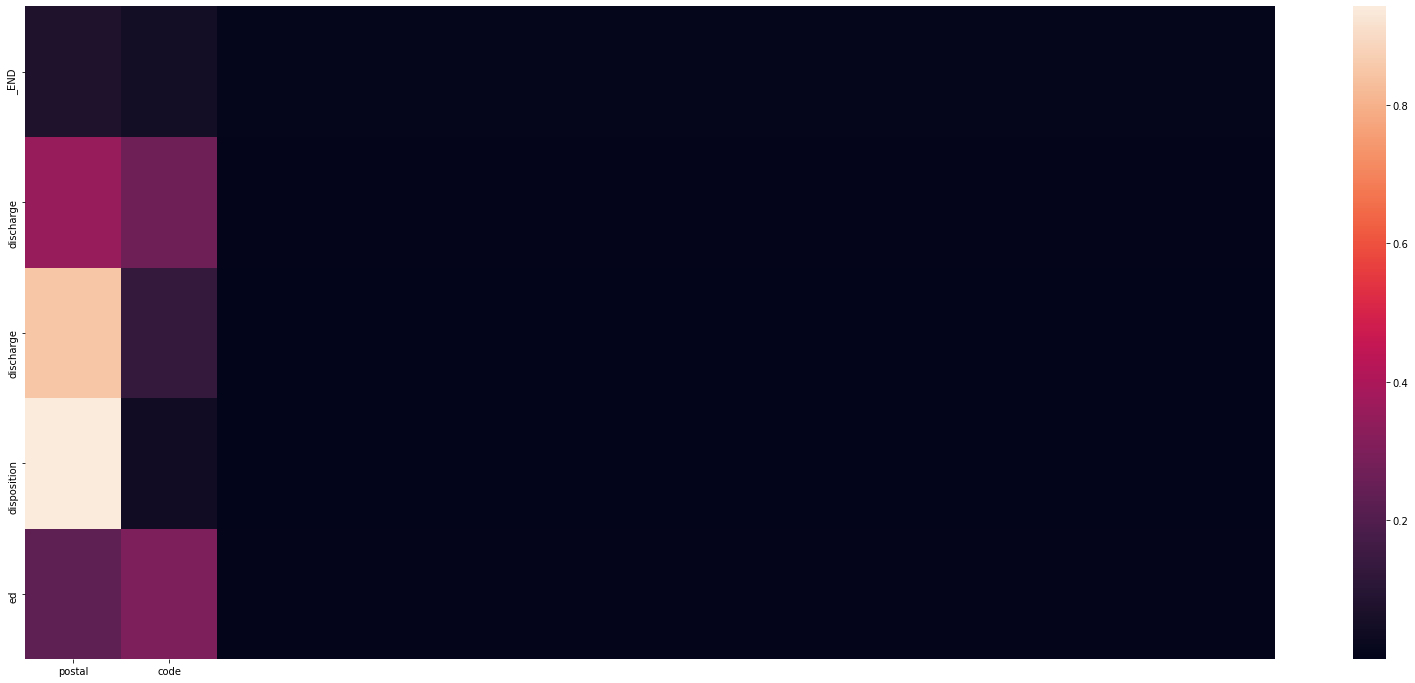

Decoded sentence:  ed disposition discharge discharge _END
-
Input sentence: comtry
GT sentence: START_ country _END


<Figure size 432x288 with 0 Axes>

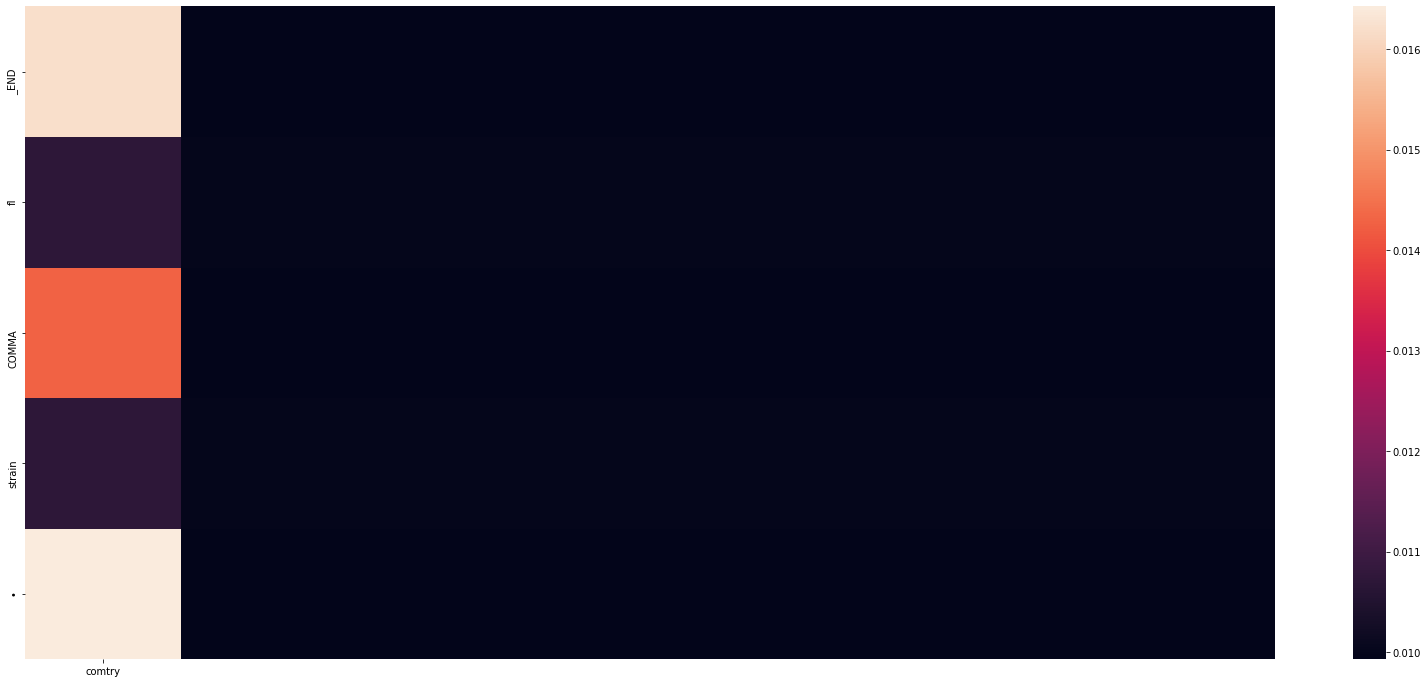

Decoded sentence:  • strain COMMA fl _END
-
Input sentence: best phone number to be reached during the day
GT sentence: START_ best phone number to be reached during the day _END


<Figure size 432x288 with 0 Axes>

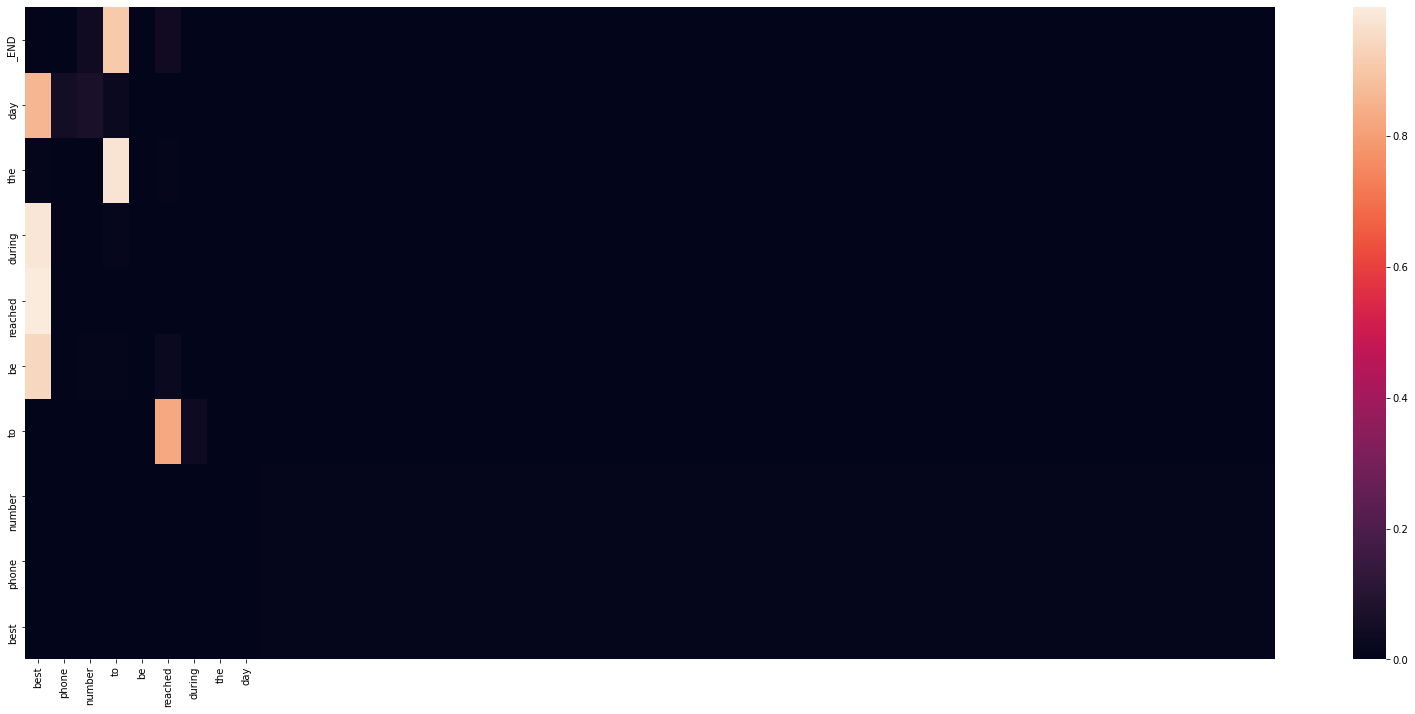

Decoded sentence:  best phone number to be reached during the day _END
-
Input sentence: email address
GT sentence: START_ email address _END


<Figure size 432x288 with 0 Axes>

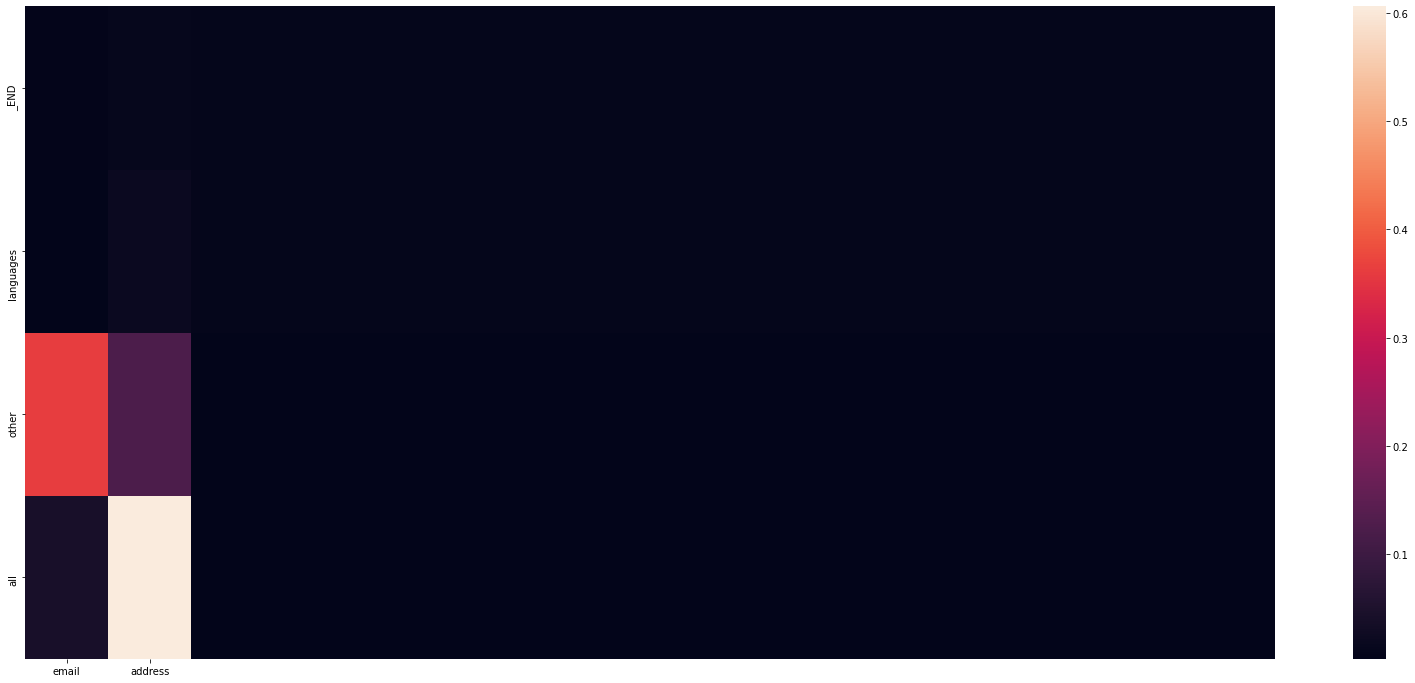

Decoded sentence:  all other languages _END
-
Input sentence: 
GT sentence: START_ page  of  _END


<Figure size 432x288 with 0 Axes>

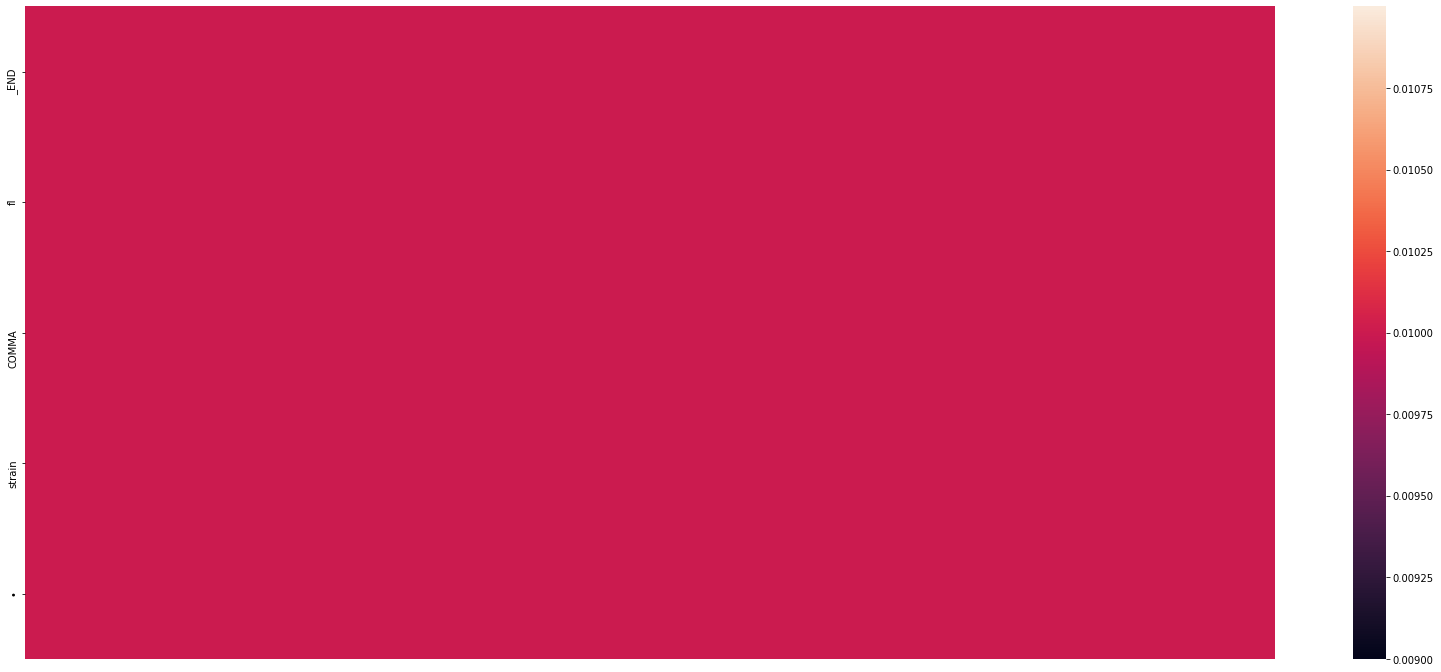

Decoded sentence:  • strain COMMA fl _END
-
Input sentence: f” radiology
GT sentence: START_ radiology _END


<Figure size 432x288 with 0 Axes>

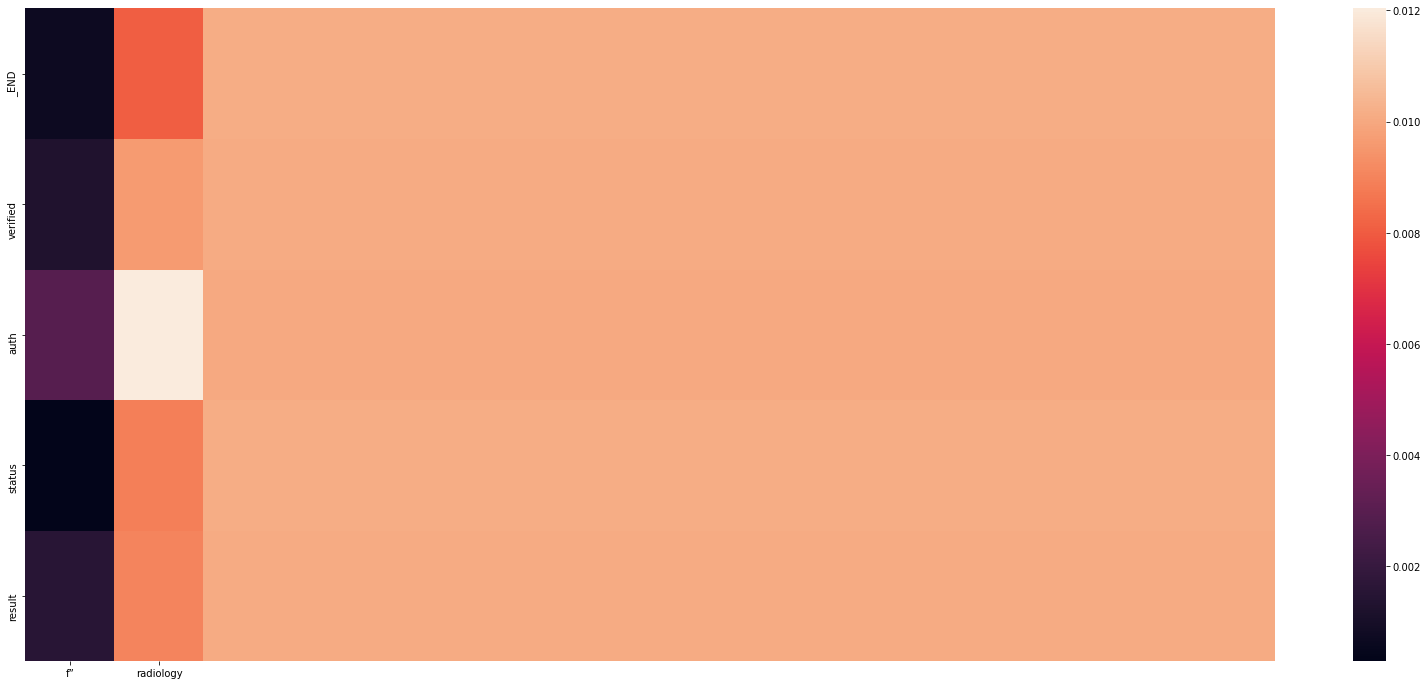

Decoded sentence:  result status auth verified _END
-
Input sentence:  report
GT sentence: START_ report _END


<Figure size 432x288 with 0 Axes>

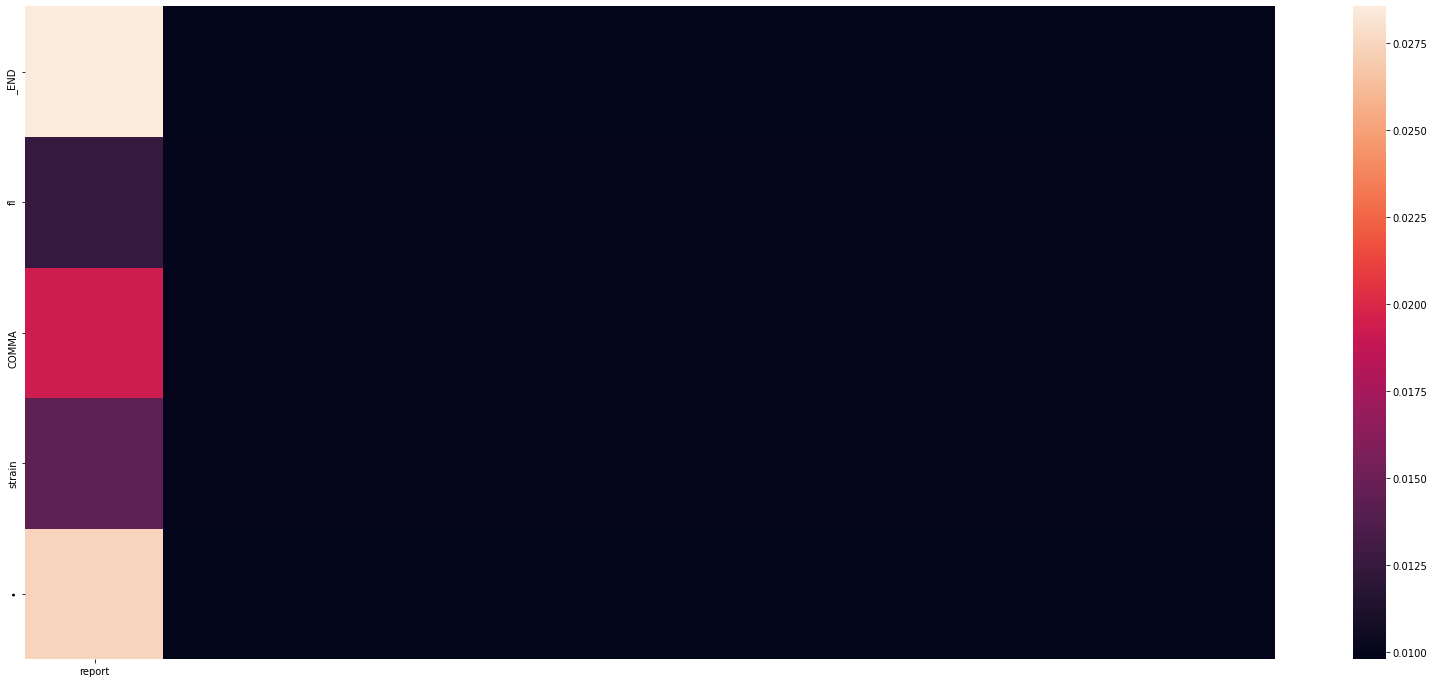

Decoded sentence:  • strain COMMA fl _END


In [ ]:
for seq_index in range(20):

    target_text = lines.target[seq_index]
    text = lines.input[seq_index]
    print('-')
    print('Input sentence:', text)    
    print('GT sentence:', target_text)
    decoded_sentence = visualize_attention(text, encoder_model, decoder_model, max_encoder_seq_length, num_decoder_tokens, input_token_index, reverse_target_tok_index, tok_split_fn)

    
    print('Decoded sentence:', decoded_sentence)   


# A lot of OOV!
As expected, word level models suffer the OOV issues. The mis-spelled input cannot have the same vocab as the GT words. This mandates to have an "invalid" embedding table. 

__Mis-use of Embedding!__

Doing so is a _misuse_ of the concept of Embedddings. We resort to Embeddings in order to encode _similarity_ in the word representations. When encoding the mis-spelled words, we model the _noise_ in the words. Ofcourse we don't want to encode the similarities of mis-spelled words!

__Different distributions for different applications!__

The main issue with Embedding the mis-spelled words, is that we will rarely encounter the same mis-spelled word in reality. For example, if the mistakes are coming from keyboard typing mistakes, this might have some _underlying_ model, where some characters are usually confuserd to others. This will result in different __words inflections__: substitutions, deletions or insertions of chars. Although the mistakes have some structure or generating process, but the resulting words will be highly variable, that we cannot capture them all. Moreover, we will hardly encounter them all in training. 

The issue is more amplified if the spelling mistakes are generated from more _unknown_ process, like some OCR mistakes. This will vary from one OCR system to another. Again it will be hard to encode all inflections in an Embedding table.

On the Decoder side, we will have a softmax that tries to recover the _correct_ words. But trying to do so based on irregular Encoder embeddings as described above will lead to bad results.

___Solution in char level___

For all the above analysis, the solution lies in char level encoding of the inputs:

# Char Level (char2char)

Now let's encoder the sentences as sequence of chars instead of words. While it's not clear why we need to do that in NMT application, the need is more clear in other applications that has the possibility of having mistakes in the input, leading to OOV words. Examples:
- Spelling correction
- Chatbots

Char level models have the following pros:

- No OOV: we cannot encounter a char we don't know. In word level models, there's a risk of having new word not in out vocab.

- `number_target_tokens` are limited by the length of chars vocab, vs. large number of words vocab, which makes a huge softmax layer. This increase the memory and the model complexity, leading to risk of overfitting. Also, making it hard to learn ALL words softmax weights, since they are rarely encountered as output. Finally, dominant stop words might create [class imbalance issue](https://machinelearningmastery.com/what-is-imbalanced-classification/).

On the other hand, it has the following cons:

- `max_encoder_seq_len` and `max_decoder_seq_len` is longer than word level case. This makes it harder for the LSTM to learn the sequence states, leading to the following issue:

- Hallucination: since the sequence is long, the LSTM state capture is harder. Moreover, the model knows nothing about the notion of _word_, leading to: 1) invalid words and 2) invalid words sequence, since the language model now is at char level, and the sequence is long, so the errors in language modeling are higher.

- Error propagation: during inference, seq2seq models are sampled in a sequential order. The decoder inputs are now the feedback of decoder output. This leads to error propagation. The issue exists in both word and char level models. However, it is more severe in char level case, due to longer sequence, making it harder to recover. This also leads to hallucination (invalid words and/or sequence).

In [ ]:
lines = pd.DataFrame({'input':inputs, 'target':targets})
num_samples = 10000
lines = lines[:num_samples]

In [ ]:
st_tok = '\t'
end_tok = '\n'
def data_prep(lines):
  cleanup(lines)
  lines.target = lines.target.apply(lambda x : st_tok  + x  + end_tok)
  

In [ ]:
data_prep(lines)


In [ ]:
lines

,input,target
0,claim type vb accident accidental injury,\tclaim type vb accident accidental injury\n
1,“tho th reported even happen ed to enployeef...,\twho the reported event happened to employeep...
2,pol inyhold elmchm er form arlon,\tpolicyholderowner information\n
3,first name,\tfirst name\n
4,middle nameﬂnitial,\tmiddle nameinitial\n
...,...,...
5543,discussionlsummary,\tdiscussionsummary\n
5544,i believe that a is doing quite well at this t...,\ti believe that is doing quite well at this t...
5545,signatures,\tsignatures\n
5546,electronicaliy signed by jamie birkelo COMMA ...,\telectronically signed by jamie birkelo COMM...


## Baisc seq2seq

In [ ]:
emb_sz = 256

In [ ]:
def tok_split_char2char(data):
  return data
  
tok_split_fn = tok_split_char2char

In [ ]:
input_tokens, target_tokens, num_encoder_tokens, num_decoder_tokens, max_encoder_seq_length, max_decoder_seq_length = data_stats(lines, input_tok_split_fn=tok_split_fn, target_tok_split_fn=tok_split_fn)
print('Number of samples:', len(lines))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 5548
Number of unique input tokens: 46
Number of unique output tokens: 48
Max sequence length for inputs: 2412
Max sequence length for outputs: 2416


In [ ]:
pad_tok = 'PAD'
sep_tok = ' '
special_tokens = [pad_tok, sep_tok, st_tok, end_tok] 
num_encoder_tokens += len(special_tokens)
num_decoder_tokens += len(special_tokens)
max_encoder_seq_length = max_decoder_seq_length = 100
minlen=4
maxlen=90

In [ ]:
input_token_index, target_token_index, reverse_input_tok_index, reverse_target_tok_index = vocab(input_tokens, target_tokens)

In [ ]:
encoder_input_data, decoder_input_data, decoder_target_data  = vectorize(lines, max_encoder_seq_length, max_decoder_seq_length, num_decoder_tokens, input_tok_split_fn=tok_split_fn, target_tok_split_fn=tok_split_fn)

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, None)         0                                            
__________________________________________________________________________________________________
input_15 (InputLayer)           (None, None)         0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, None, 256)    12800       input_14[0][0]                   
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, None, 256)    13312       input_15[0][0]                   
___________________________________________________________________________________________

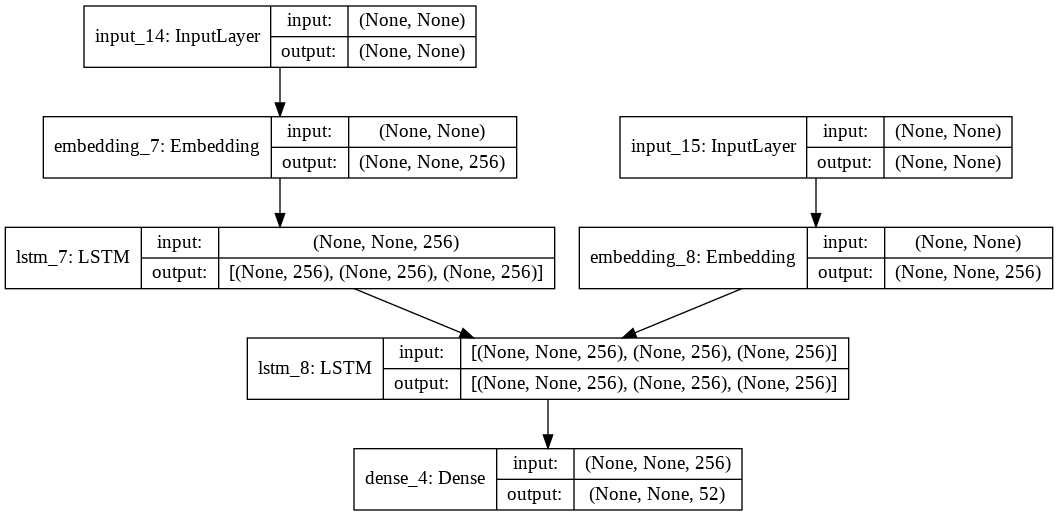

In [ ]:
emb_sz = 256
model, encoder_model, decoder_model = seq2seq(num_decoder_tokens, num_encoder_tokens, emb_sz, emb_sz)
print(model.summary())
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=64,
          epochs=10,
          validation_split=0.2)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 4438 samples, validate on 1110 samples
Epoch 1/10
4438/4438 [==============================] - 67s 15ms/step - loss: 0.6435 - acc: 0.1751 - val_loss: 0.5362 - val_acc: 0.2280
Epoch 2/10
4438/4438 [==============================] - 66s 15ms/step - loss: 0.5324 - acc: 0.2762 - val_loss: 0.4886 - val_acc: 0.2781
Epoch 3/10
4438/4438 [==============================] - 66s 15ms/step - loss: 0.4901 - acc: 0.3290 - val_loss: 0.4543 - val_acc: 0.3328
Epoch 4/10
4438/4438 [==============================] - 66s 15ms/step - loss: 0.4518 - acc: 0.3903 - val_loss: 0.4259 - val_acc: 0.3879
Epoch 5/10
4438/4438 [==============================] - 65s 15ms/step - loss: 0.4118 - acc: 0.4593 - val_loss: 0.3986 - val_acc: 0.4379
Epoch 6/10
4438/4438 [==============================] - 65s 15ms/step - loss: 0.3746 - acc: 0.5154 - val_loss: 0.3769 - val_acc: 0.4748
Epoch 7/10
4438/4438 [==============================] - 65s 15ms/step - loss: 0.3408 - acc: 0.5672 - val_loss: 0.3577 - val_acc: 0.5076


In [ ]:
for seq_index in range(100): #[14077,20122,40035,40064, 40056, 40068, 40090, 40095, 40100, 40119, 40131, 40136, 40150, 40153]:
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq, sep='')
    print('-')
    print('Input sentence:', lines.input[seq_index: seq_index + 1])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: 0    claim type vb accident  accidental injury
Name: input, dtype: object
Decoded sentence: claim tollere of the benefits conters

-
Input sentence: 1    “tho th  reported even  happen ed to enployeef...
Name: input, dtype: object
Decoded sentence: tho tollere of aberol to duest no the of coverage to 
-
Input sentence: 2    pol inyhold elmchm er  form arlon
Name: input, dtype: object
Decoded sentence: policyholder nomeration to the date

-
Input sentence: 3    first name
Name: input, dtype: object
Decoded sentence: first name

-
Input sentence: 4    middle nameﬂnitial
Name: input, dtype: object
Decoded sentence: midder list name

-
Input sentence: 5    last name
Name: input, dtype: object
Decoded sentence: last name

-
Input sentence: 6    social s ecurity number
Name: input, dtype: object
Decoded sentence: social security number

-
Input sentence: 7    birth date
Name: input, dtype: object
Decoded sentence: birth date

-
Input sentence: 8    gender
Name: input, dtype

# seq2seq + Attention

[<tf.Tensor 'concatenate_4/concat:0' shape=(None, 512) dtype=float32>, <tf.Tensor 'concatenate_5/concat:0' shape=(None, 512) dtype=float32>]
Tensor("lstm_10/transpose_2:0", shape=(None, None, 512), dtype=float32)
Tensor("bidirectional_2/concat:0", shape=(None, None, 512), dtype=float32)
attention Tensor("attention_2/truediv:0", shape=(None, None, None), dtype=float32)
encoder-decoder  model:
Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           (None, None)         0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, None, 256)    12800       input_18[0][0]                   
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`


Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           (None, None)         0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, None, 256)    12800       input_18[0][0]                   
__________________________________________________________________________________________________
input_19 (InputLayer)           (None, None)         0                                            
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) [(None, None, 512),  1050624     embedding_9[0][0]                
___________________________________________________________________________________________

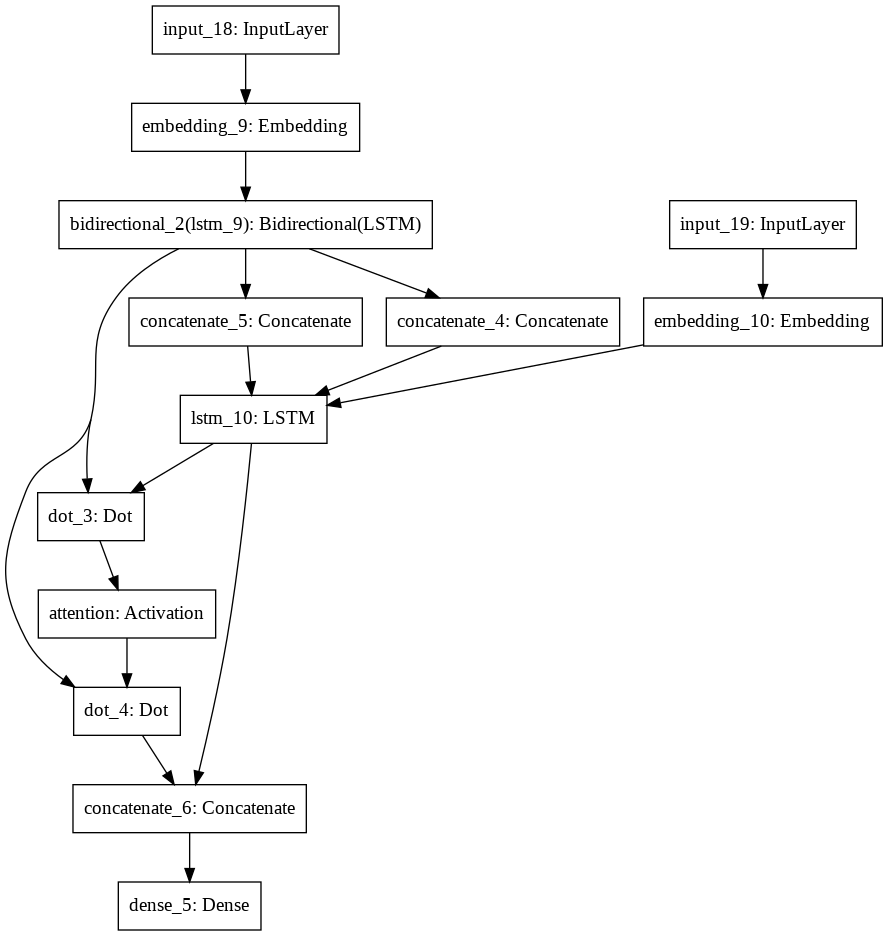

In [ ]:
model, encoder_model, decoder_model = seq2seq_attention(num_encoder_tokens, num_decoder_tokens, emb_sz=emb_sz, latent_dim=emb_sz)
print(model.summary())
plot_model(model)

In [ ]:
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=128,
          epochs=20,
          validation_split=0.05)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 5270 samples, validate on 278 samples
Epoch 1/20
5270/5270 [==============================] - 59s 11ms/step - loss: 0.6528 - acc: 0.1473 - val_loss: 0.7358 - val_acc: 0.1876
Epoch 2/20
5270/5270 [==============================] - 57s 11ms/step - loss: 0.5368 - acc: 0.2564 - val_loss: 0.6606 - val_acc: 0.2576
Epoch 3/20
5270/5270 [==============================] - 56s 11ms/step - loss: 0.4743 - acc: 0.3435 - val_loss: 0.6299 - val_acc: 0.2891
Epoch 4/20
5270/5270 [==============================] - 57s 11ms/step - loss: 0.4146 - acc: 0.4386 - val_loss: 0.5900 - val_acc: 0.3514
Epoch 5/20
5270/5270 [==============================] - 56s 11ms/step - loss: 0.3451 - acc: 0.5442 - val_loss: 0.5179 - val_acc: 0.4320
Epoch 6/20
5270/5270 [==============================] - 55s 10ms/step - loss: 0.2555 - acc: 0.6758 - val_loss: 0.3527 - val_acc: 0.6381
Epoch 7/20
5270/5270 [==============================] - 56s 11ms/step - loss: 0.1426 - acc: 0.8352 - val_loss: 0.2052 - val_acc: 0.8053
E

In [ ]:
char_decoded_sents = []
target_sents = []
for seq_index in range(100): #[14077,20122,40035,40064, 40056, 40068, 40090, 40095, 40100, 40119, 40131, 40136, 40150, 40153]:
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence, attention = decode_sequence_attention(input_seq, sep='')
    print('-')
    print('Input sentence:', lines.input[seq_index: seq_index + 1])
    print('GT sentence:', lines.target[seq_index: seq_index + 1][1:-1])
    print('Decoded sentence:', decoded_sentence)
    char_decoded_sents.append(decoded_sentence)
    target_sents.append(np.array(lines.target[seq_index: seq_index + 1]))

-
Input sentence: 0    claim type vb accident  accidental injury
Name: input, dtype: object
GT sentence: Series([], Name: target, dtype: object)
Decoded sentence: claim type vb accident  accidental injury

-
Input sentence: 1    “tho th  reported even  happen ed to enployeef...
Name: input, dtype: object
GT sentence: Series([], Name: target, dtype: object)
Decoded sentence: tho the reported event  happened to employeepolicyhol
-
Input sentence: 2    pol inyhold elmchm er  form arlon
Name: input, dtype: object
GT sentence: Series([], Name: target, dtype: object)
Decoded sentence: policyholderowner information

-
Input sentence: 3    first name
Name: input, dtype: object
GT sentence: Series([], Name: target, dtype: object)
Decoded sentence: first name

-
Input sentence: 4    middle nameﬂnitial
Name: input, dtype: object
GT sentence: Series([], Name: target, dtype: object)
Decoded sentence: middle nameinitial

-
Input sentence: 5    last name
Name: input, dtype: object
GT sentence: Series

-
Input sentence: claim type vb accident  accidental injury
GT sentence: 	claim type vb accident  accidental injury



<Figure size 432x288 with 0 Axes>

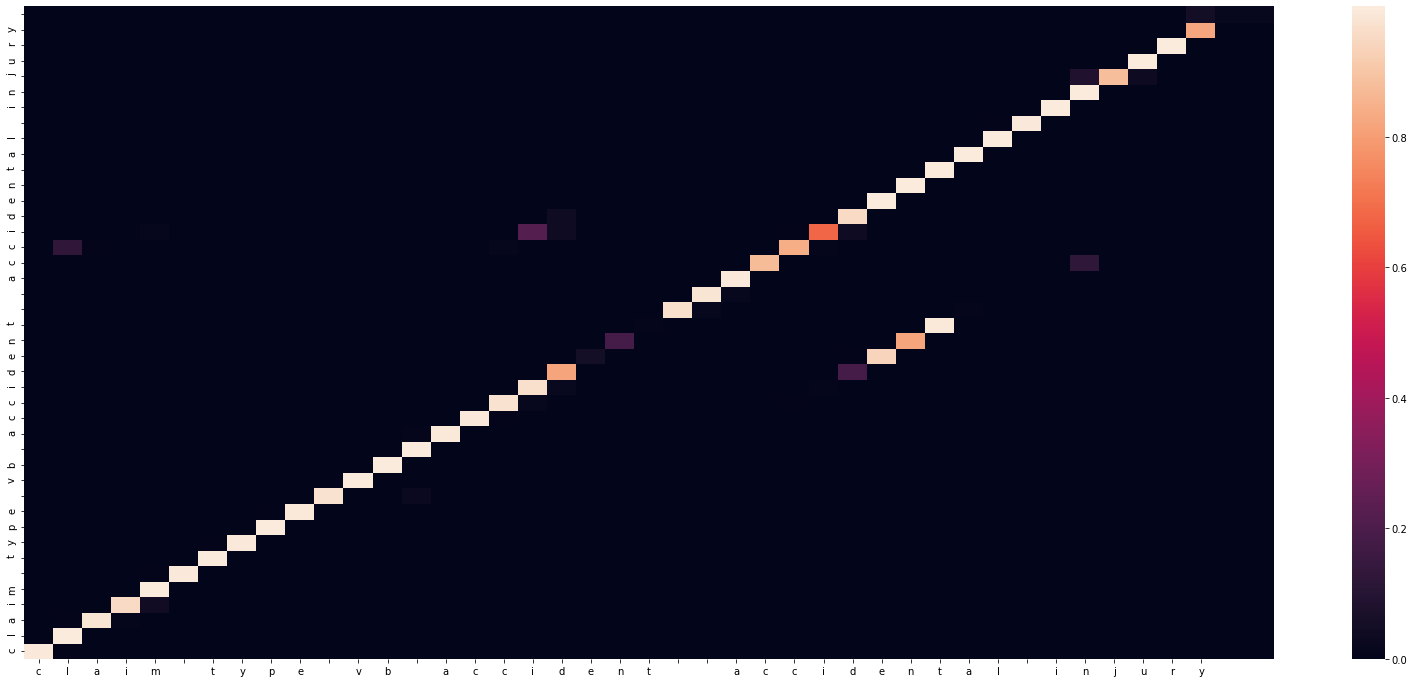

Decoded sentence: claim type vb accident  accidental injury

-
Input sentence: “tho th  reported even  happen ed to enployeefpolicyholder
GT sentence: 	who the reported event happened to employeepolicyholder



<Figure size 432x288 with 0 Axes>

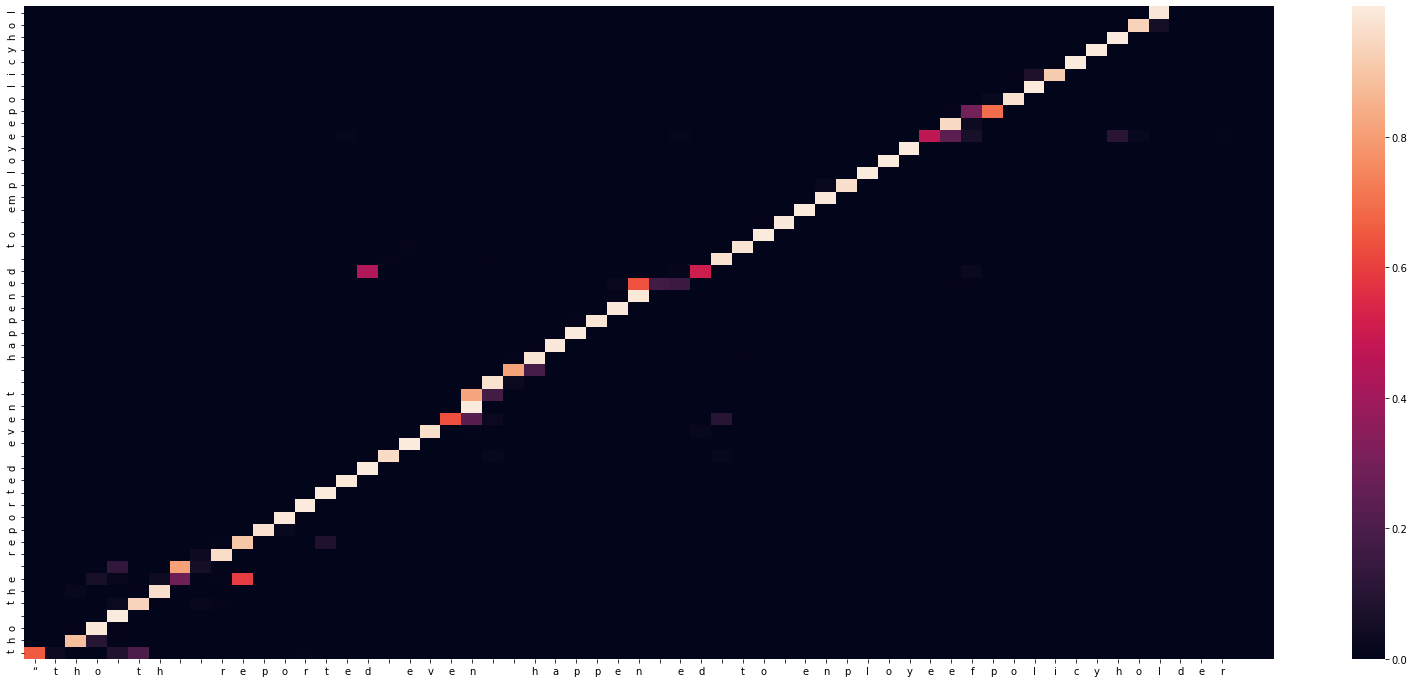

Decoded sentence: tho the reported event  happened to employeepolicyhol
-
Input sentence: pol inyhold elmchm er  form arlon
GT sentence: 	policyholderowner information



<Figure size 432x288 with 0 Axes>

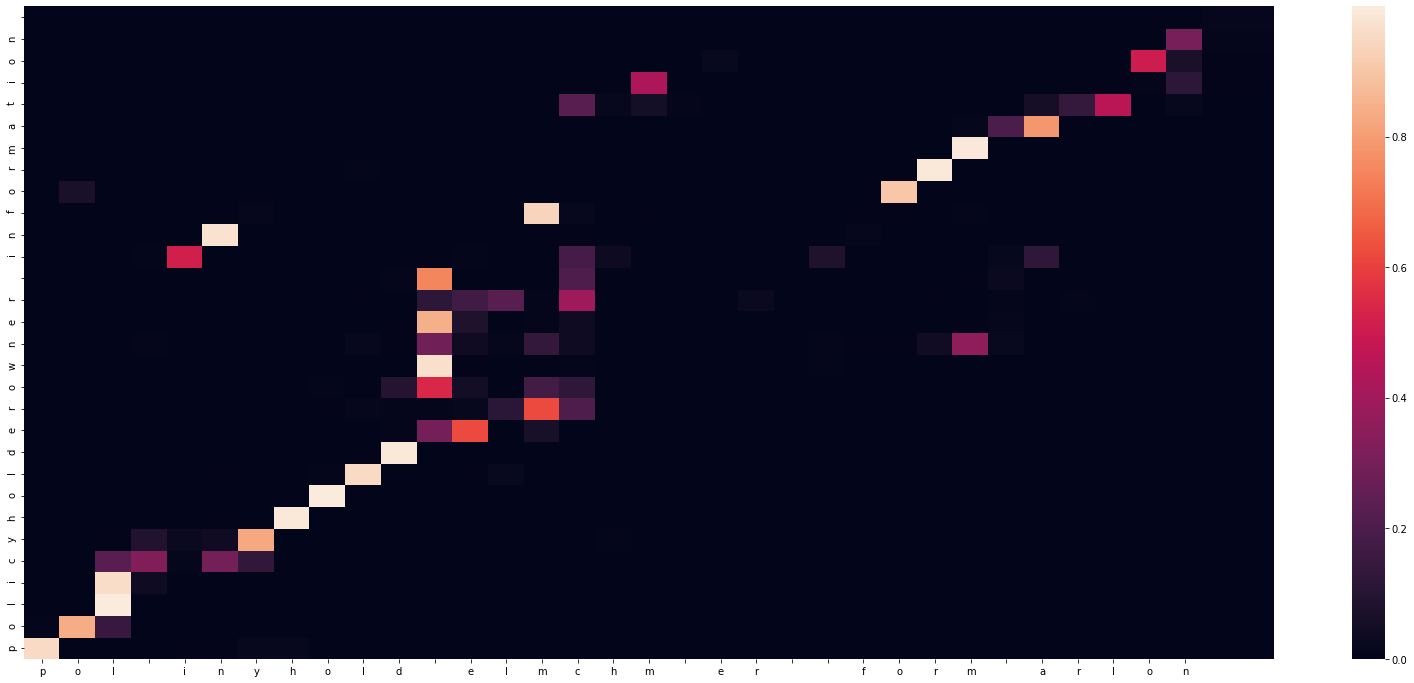

Decoded sentence: policyholderowner information

-
Input sentence: first name
GT sentence: 	first name



<Figure size 432x288 with 0 Axes>

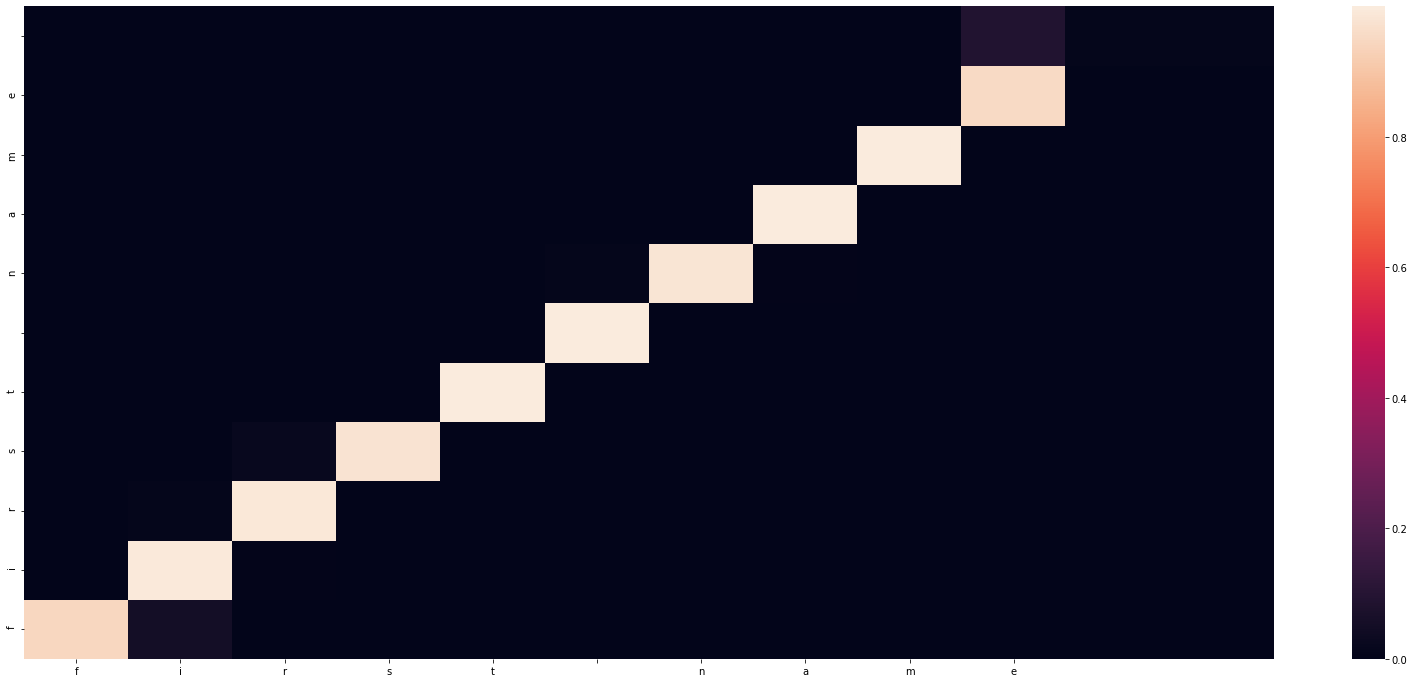

Decoded sentence: first name

-
Input sentence: middle nameﬂnitial
GT sentence: 	middle nameinitial



<Figure size 432x288 with 0 Axes>

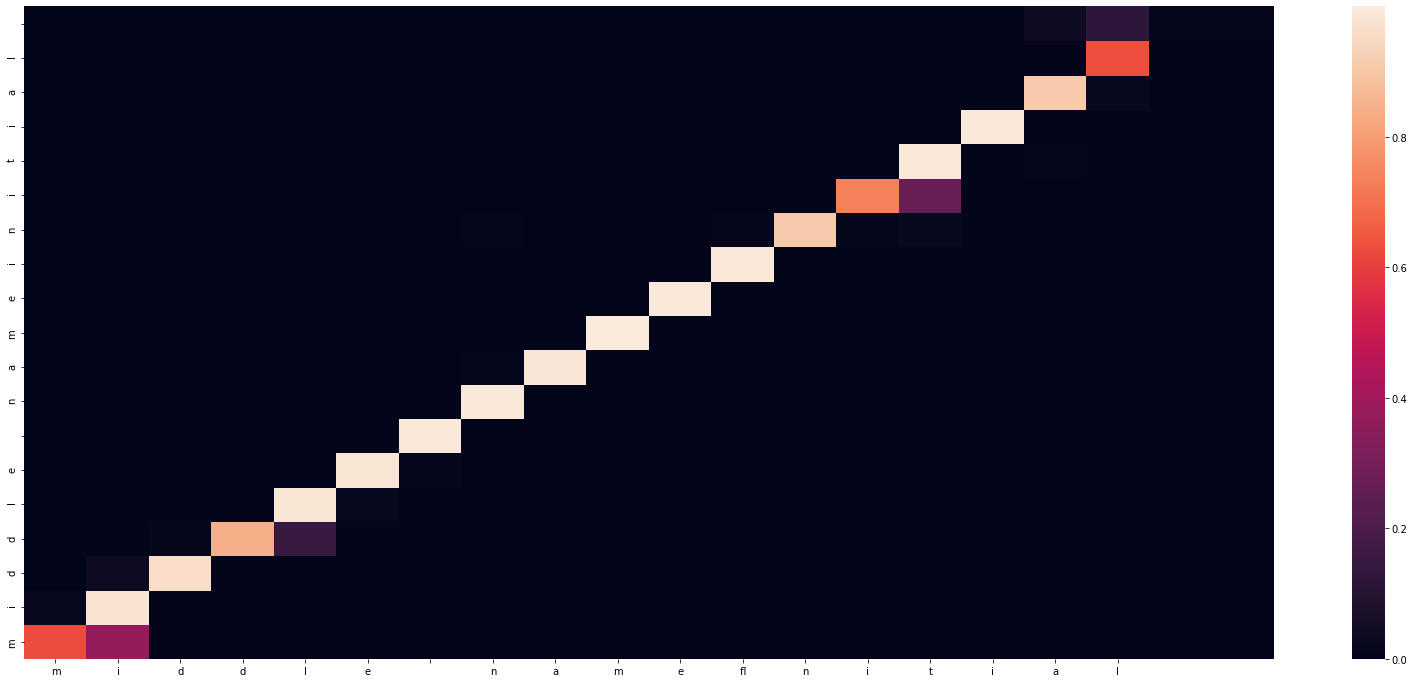

Decoded sentence: middle nameinitial

-
Input sentence: last name
GT sentence: 	last name



<Figure size 432x288 with 0 Axes>

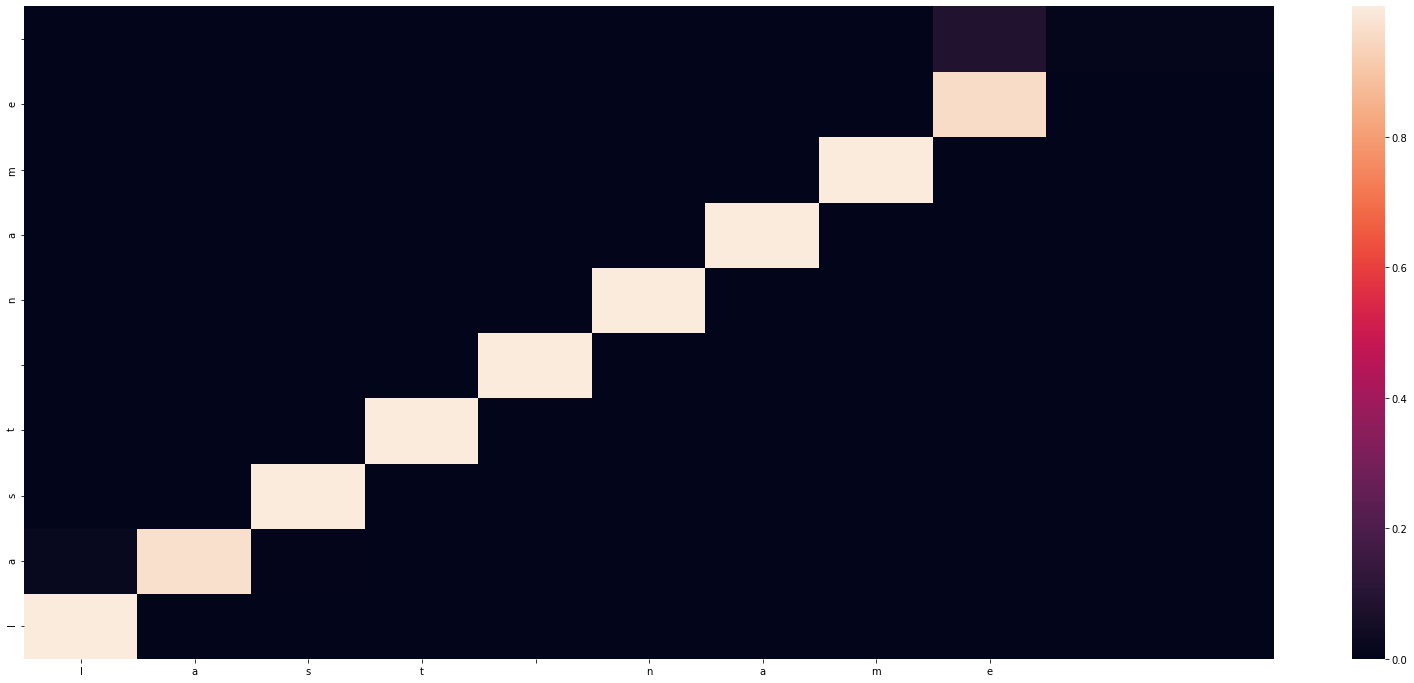

Decoded sentence: last name

-
Input sentence: social s ecurity number
GT sentence: 	social security number



<Figure size 432x288 with 0 Axes>

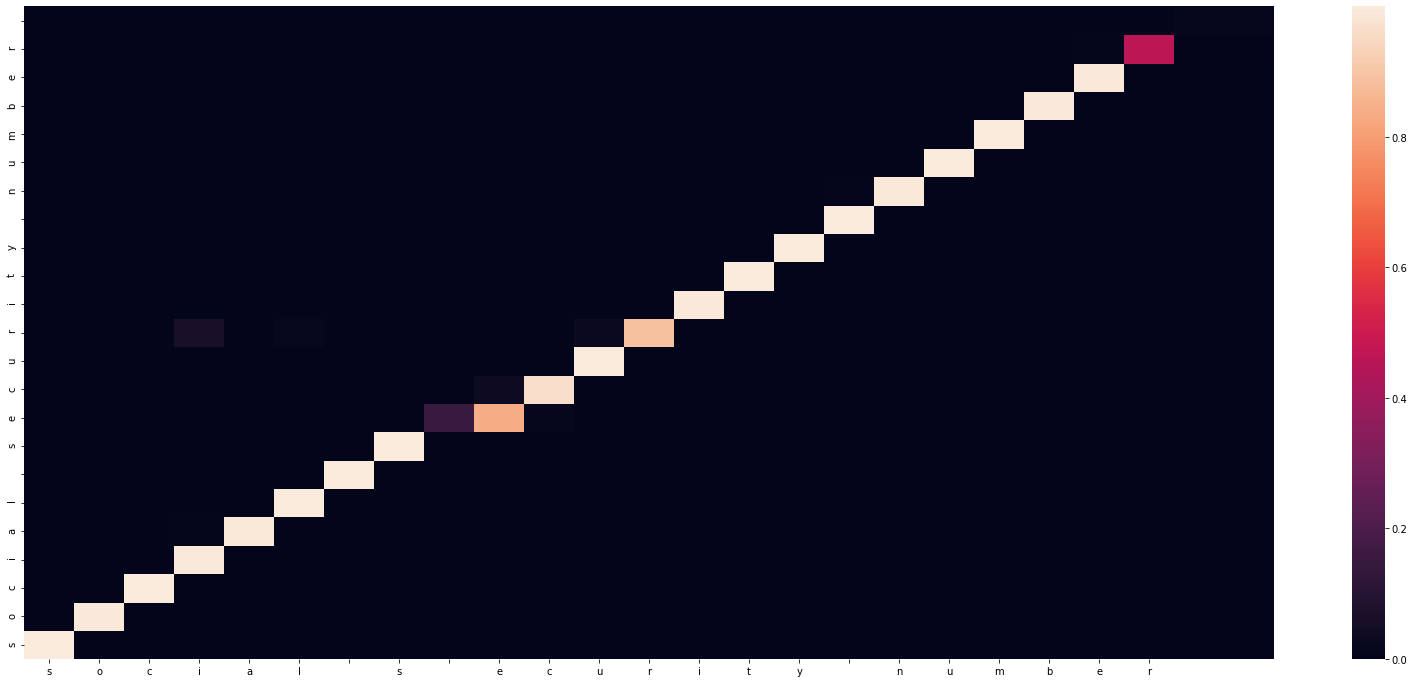

Decoded sentence: social security number

-
Input sentence: birth date
GT sentence: 	birth date



<Figure size 432x288 with 0 Axes>

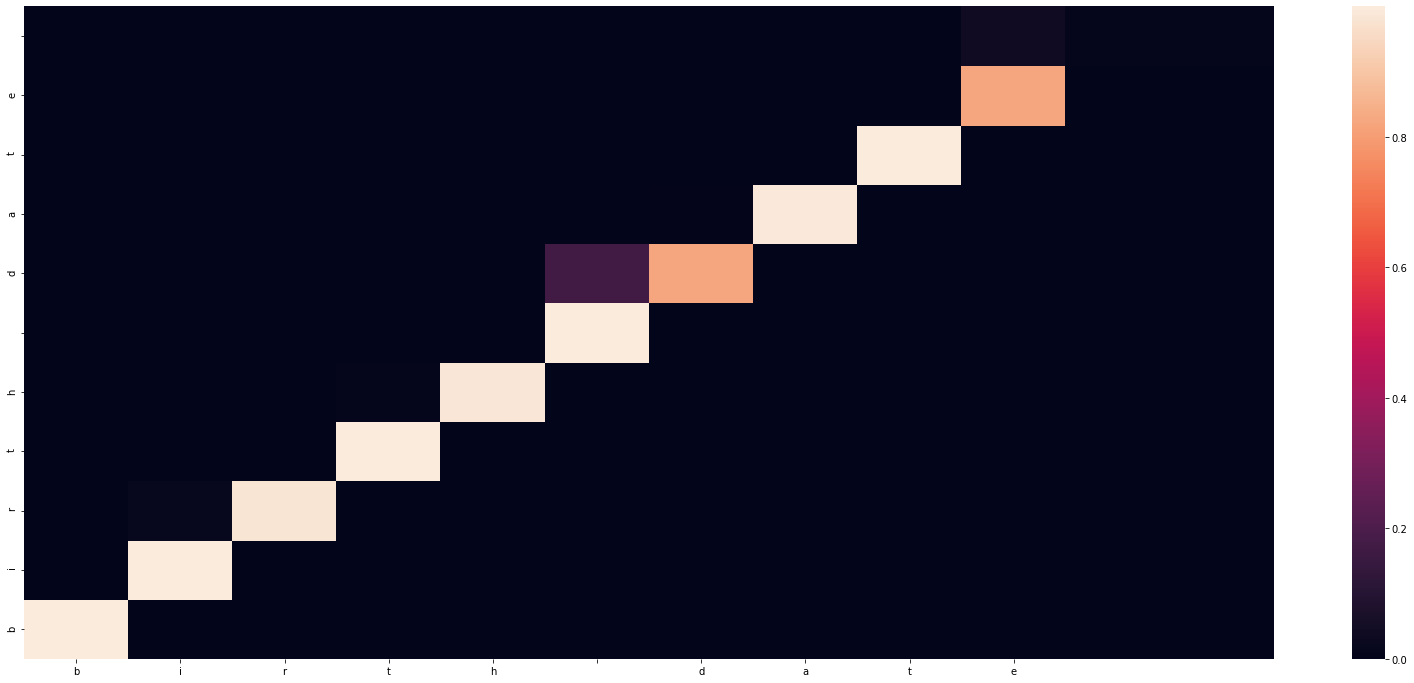

Decoded sentence: birth date

-
Input sentence: gender
GT sentence: 	gender



<Figure size 432x288 with 0 Axes>

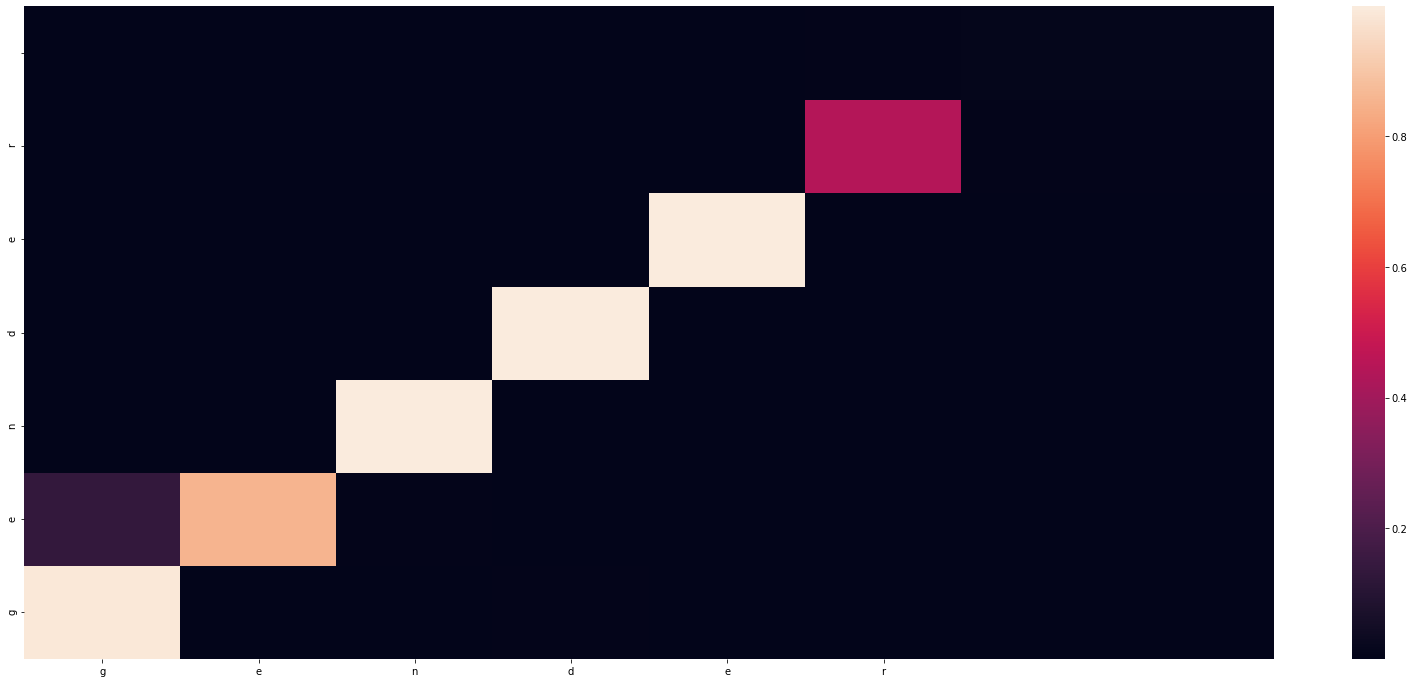

Decoded sentence: gender

-
Input sentence: language preference
GT sentence: 	language preference



<Figure size 432x288 with 0 Axes>

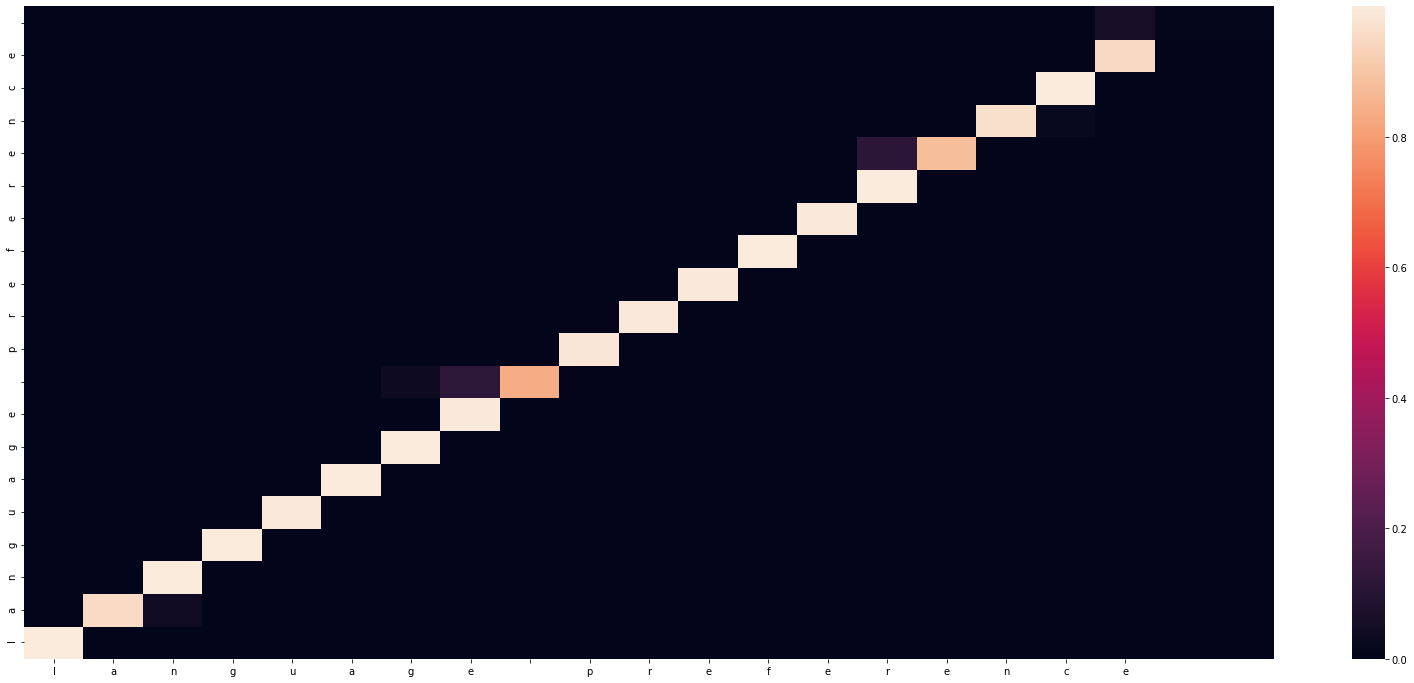

Decoded sentence: language preference

-
Input sentence: address line 
GT sentence: 	address line 



<Figure size 432x288 with 0 Axes>

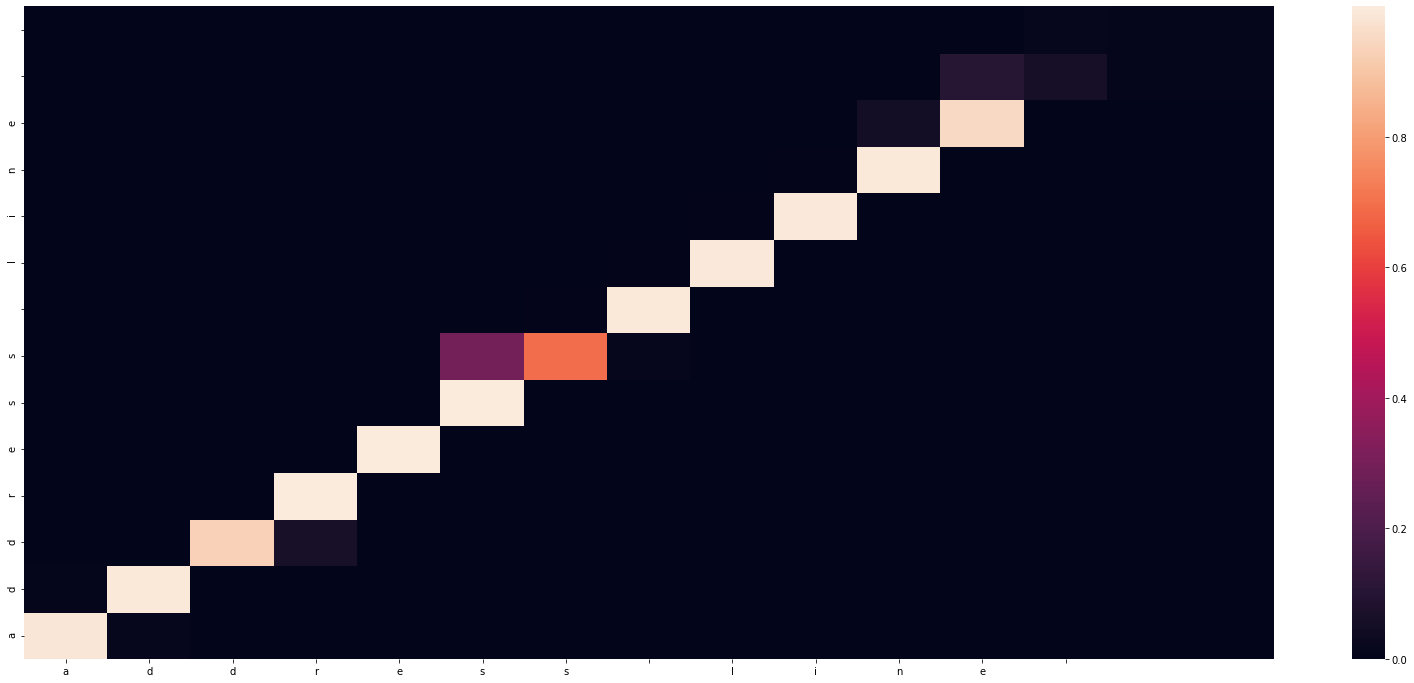

Decoded sentence: address line 

-
Input sentence: gw 
GT sentence: 	city



<Figure size 432x288 with 0 Axes>

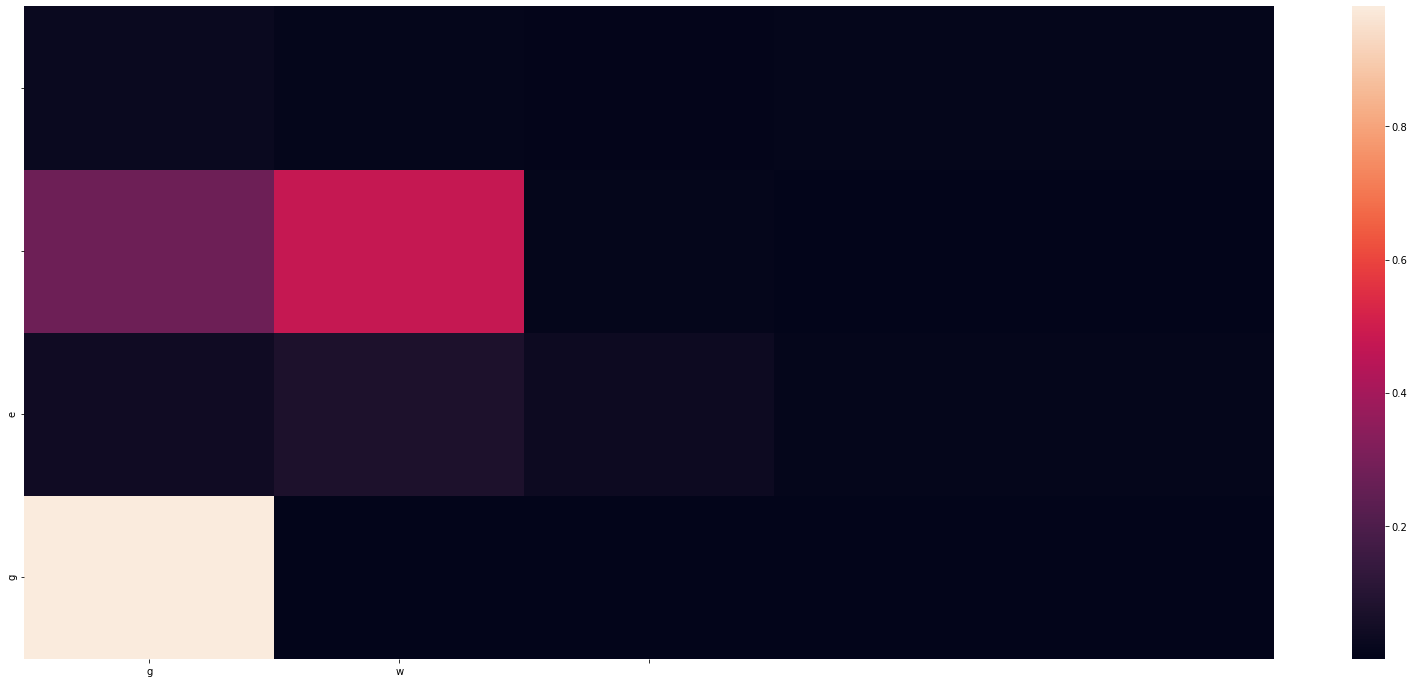

Decoded sentence: ge 

-
Input sentence: statefprmince 
GT sentence: 	stateprovince



<Figure size 432x288 with 0 Axes>

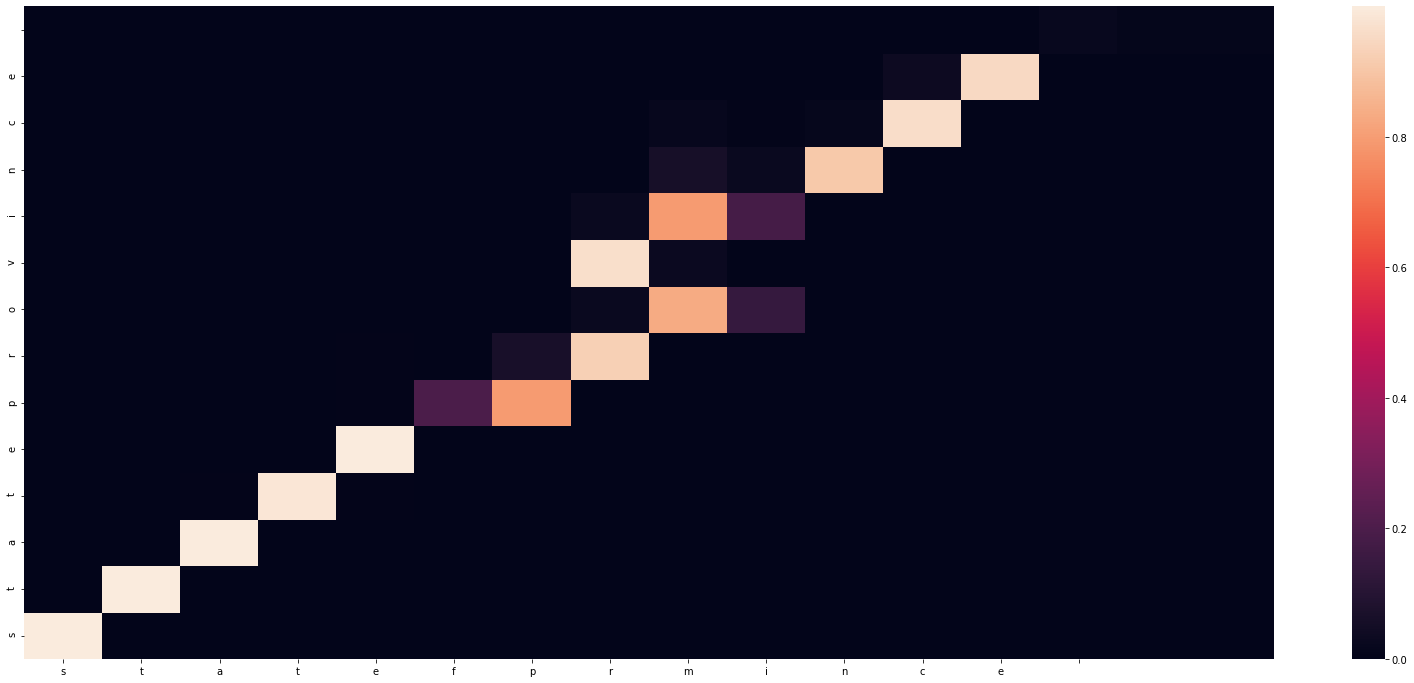

Decoded sentence: stateprovince

-
Input sentence: postal code
GT sentence: 	postal code



<Figure size 432x288 with 0 Axes>

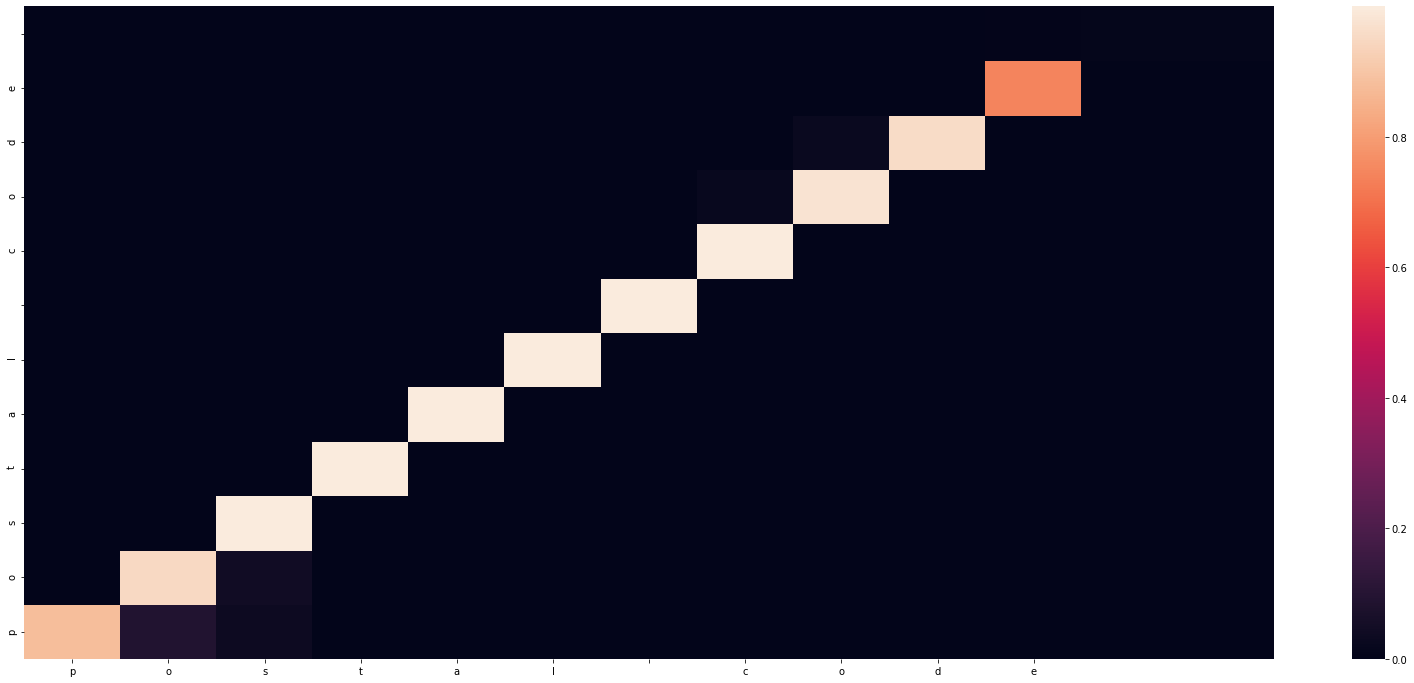

Decoded sentence: postal code

-
Input sentence: comtry
GT sentence: 	country



<Figure size 432x288 with 0 Axes>

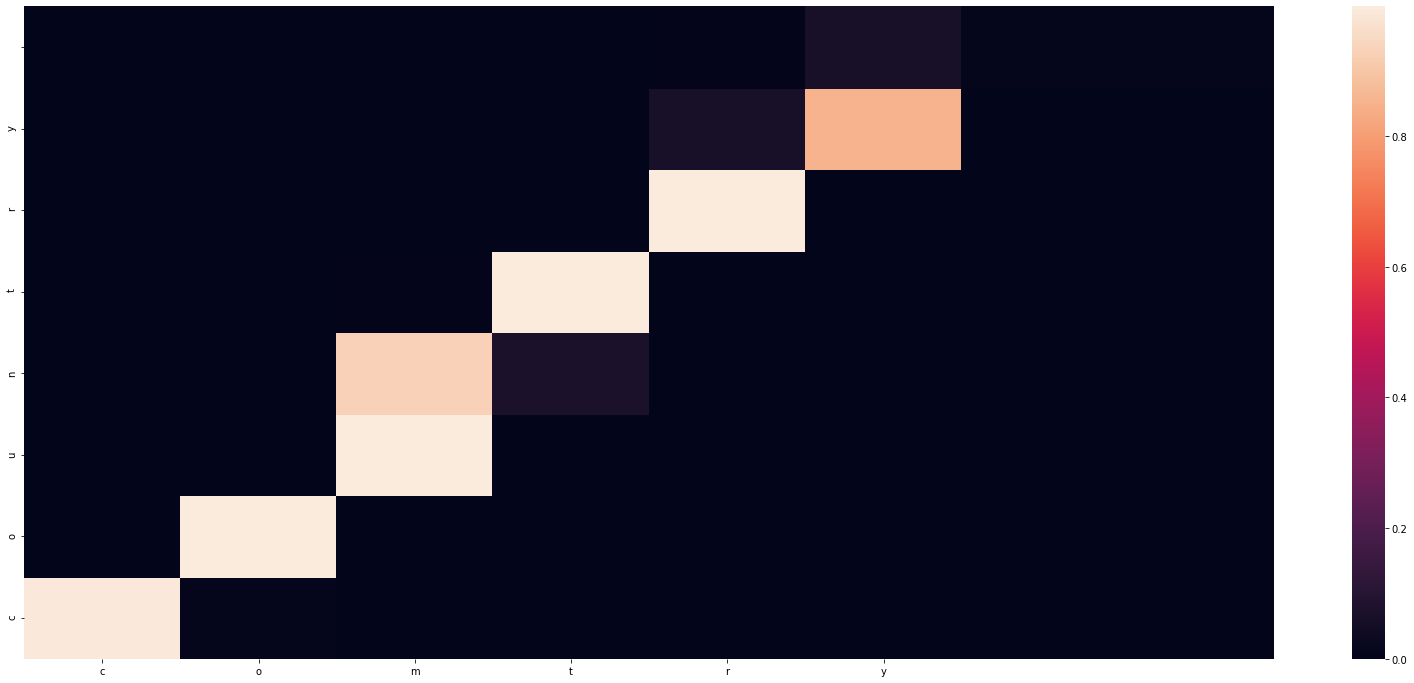

Decoded sentence: country

-
Input sentence: best phone number to be reached during the day
GT sentence: 	best phone number to be reached during the day



<Figure size 432x288 with 0 Axes>

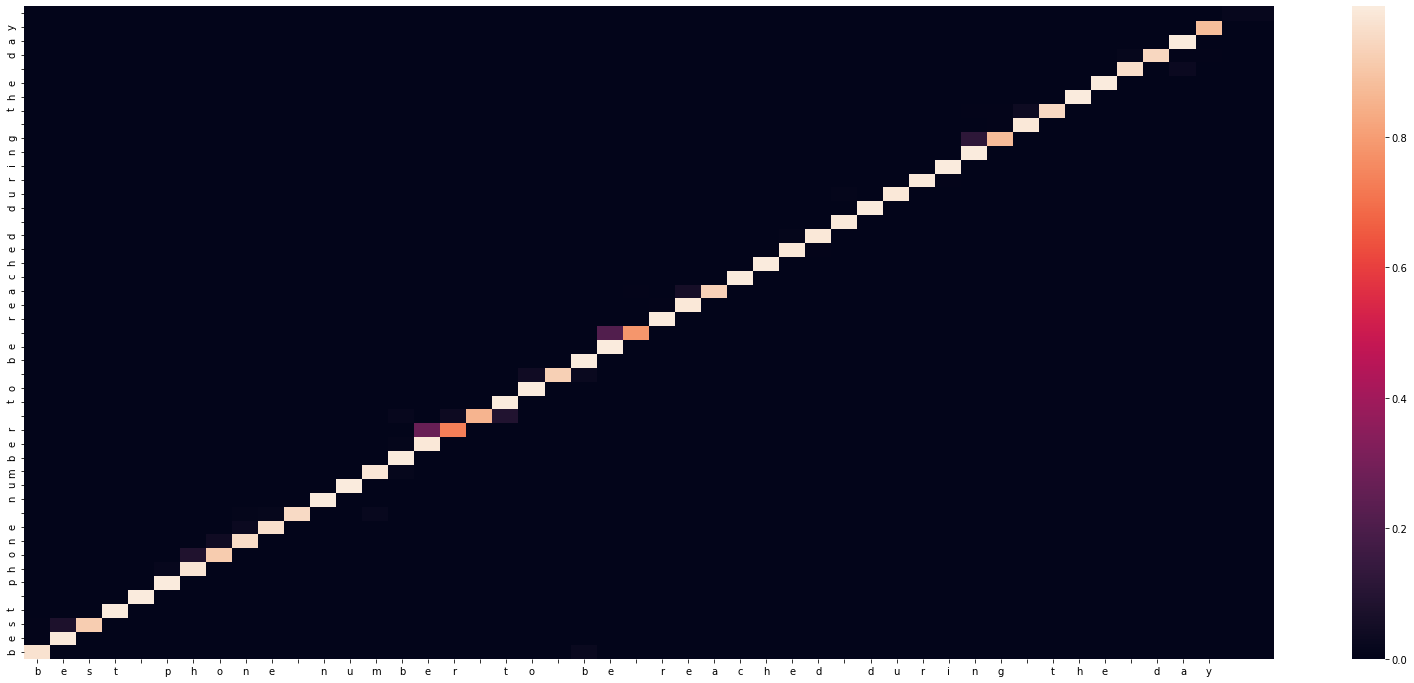

Decoded sentence: best phone number to be reached during the day

-
Input sentence: email address
GT sentence: 	email address



<Figure size 432x288 with 0 Axes>

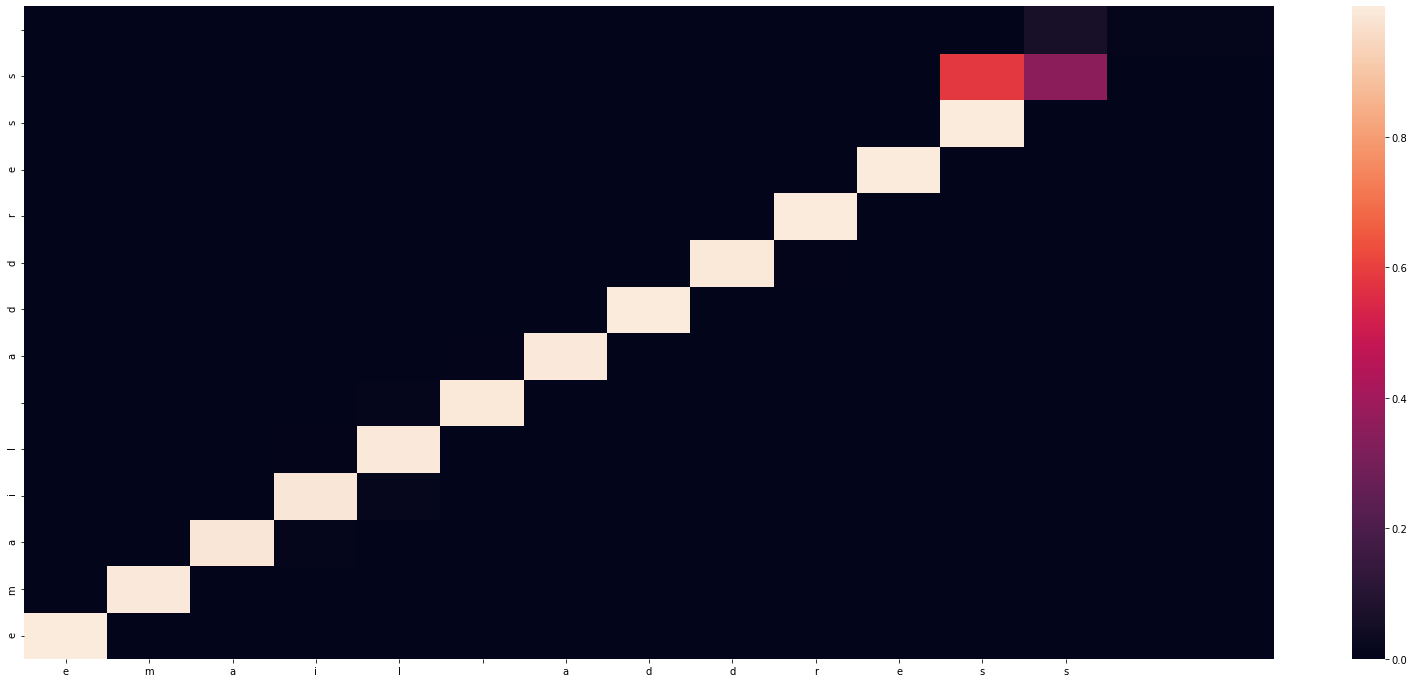

Decoded sentence: email address

-
Input sentence: 
GT sentence: 	page  of 



<Figure size 432x288 with 0 Axes>

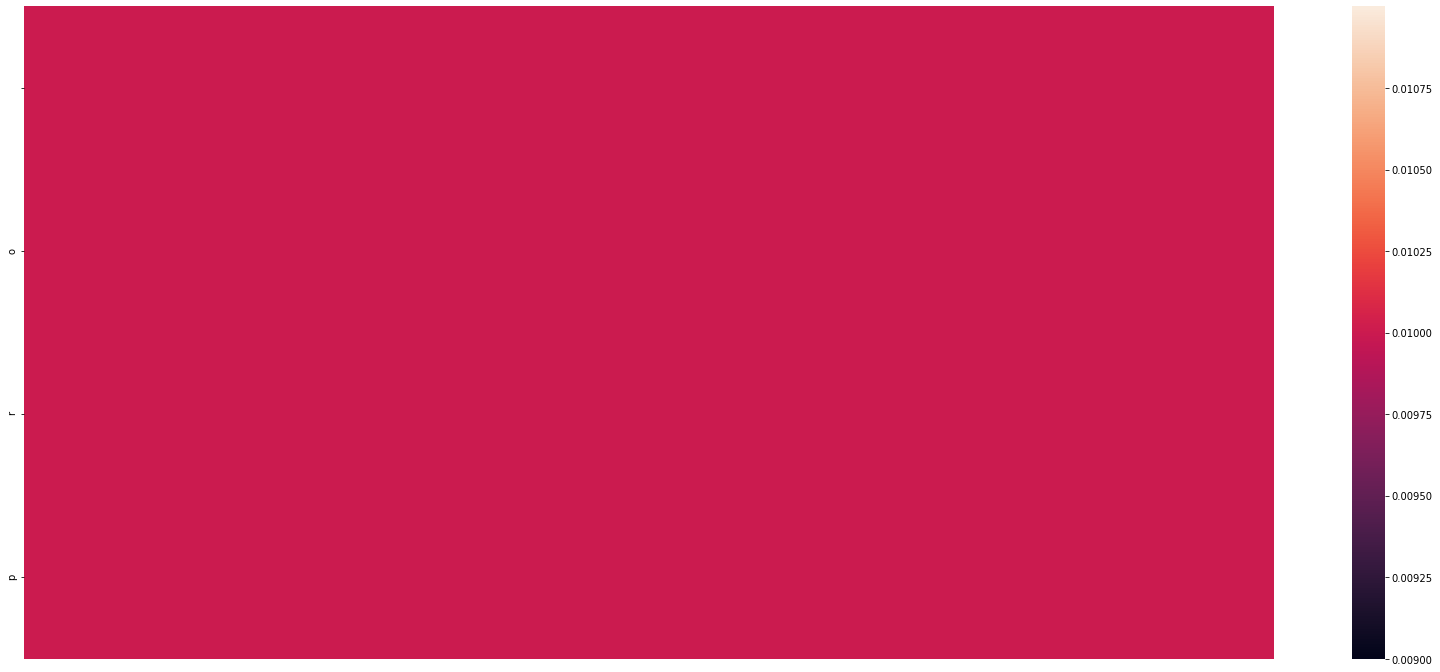

Decoded sentence: pro

-
Input sentence: f” radiology
GT sentence: 	radiology



<Figure size 432x288 with 0 Axes>

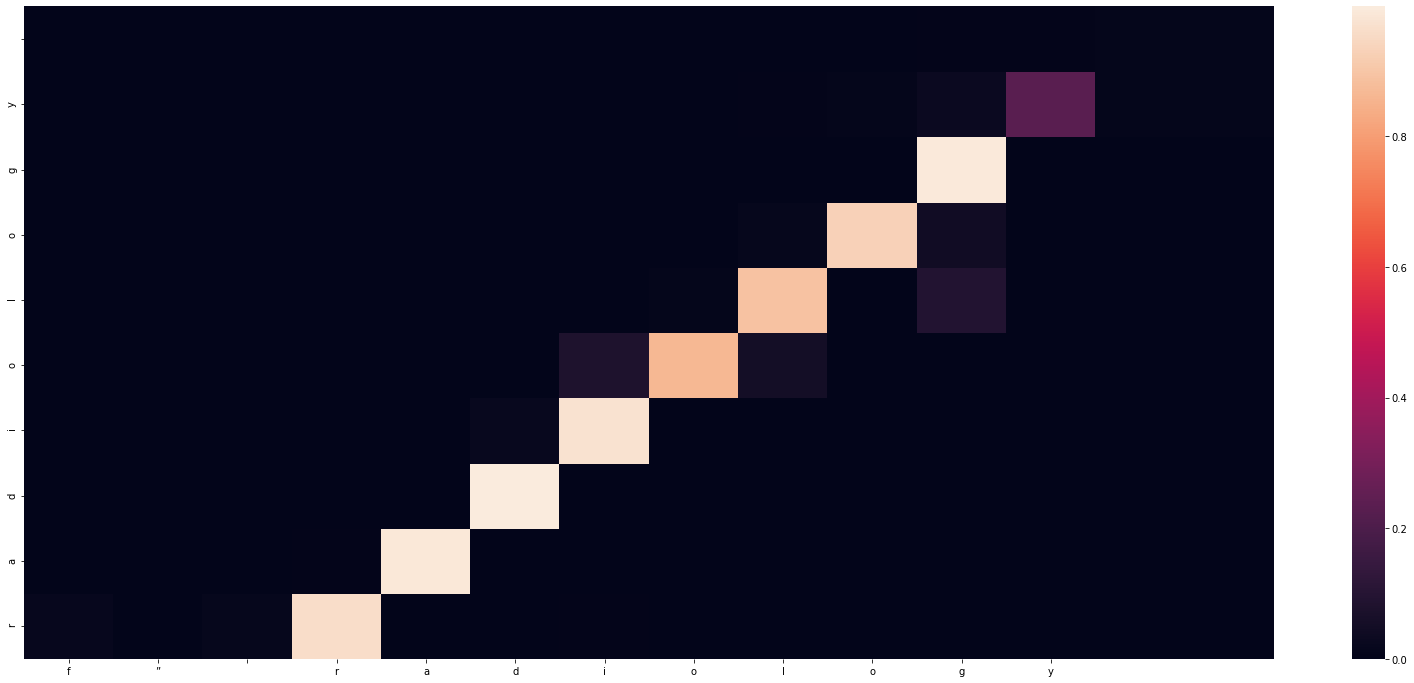

Decoded sentence: radiology

-
Input sentence:  report
GT sentence: 	report



<Figure size 432x288 with 0 Axes>

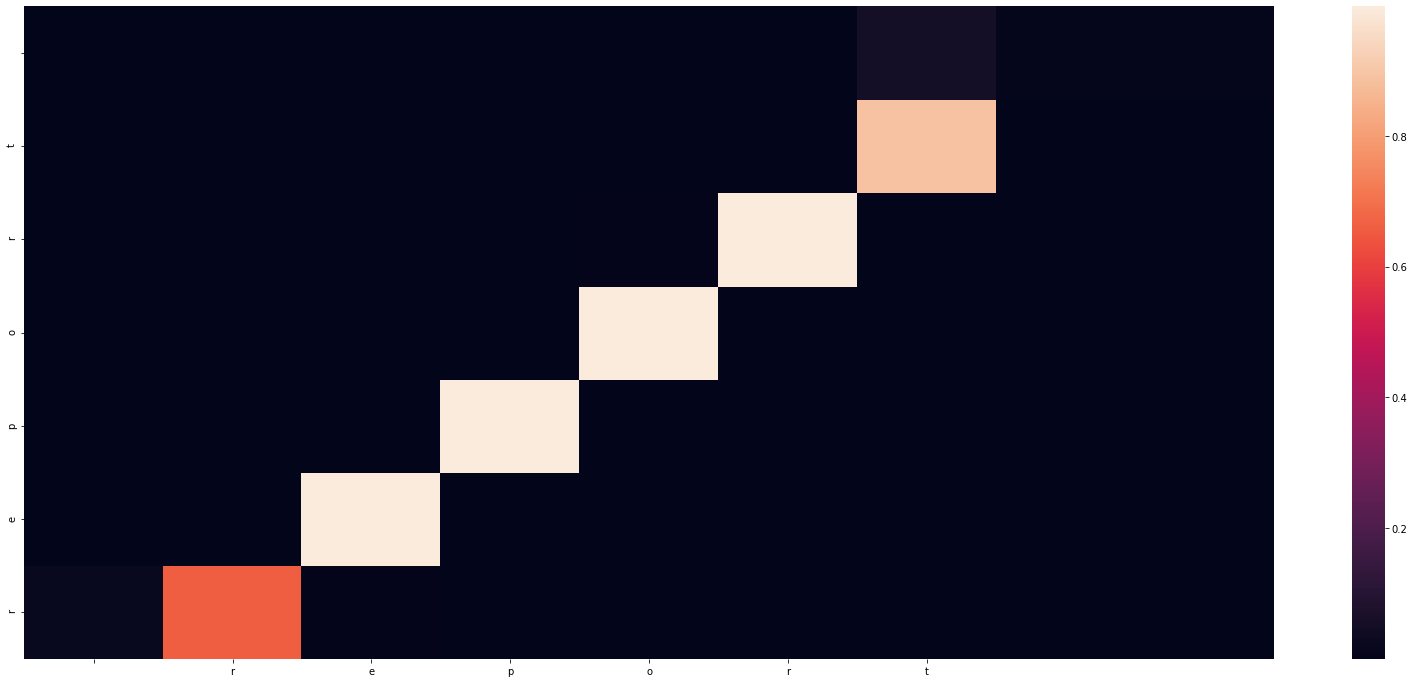

Decoded sentence: report

-
Input sentence: 
GT sentence: 	wwwraysnet



<Figure size 432x288 with 0 Axes>

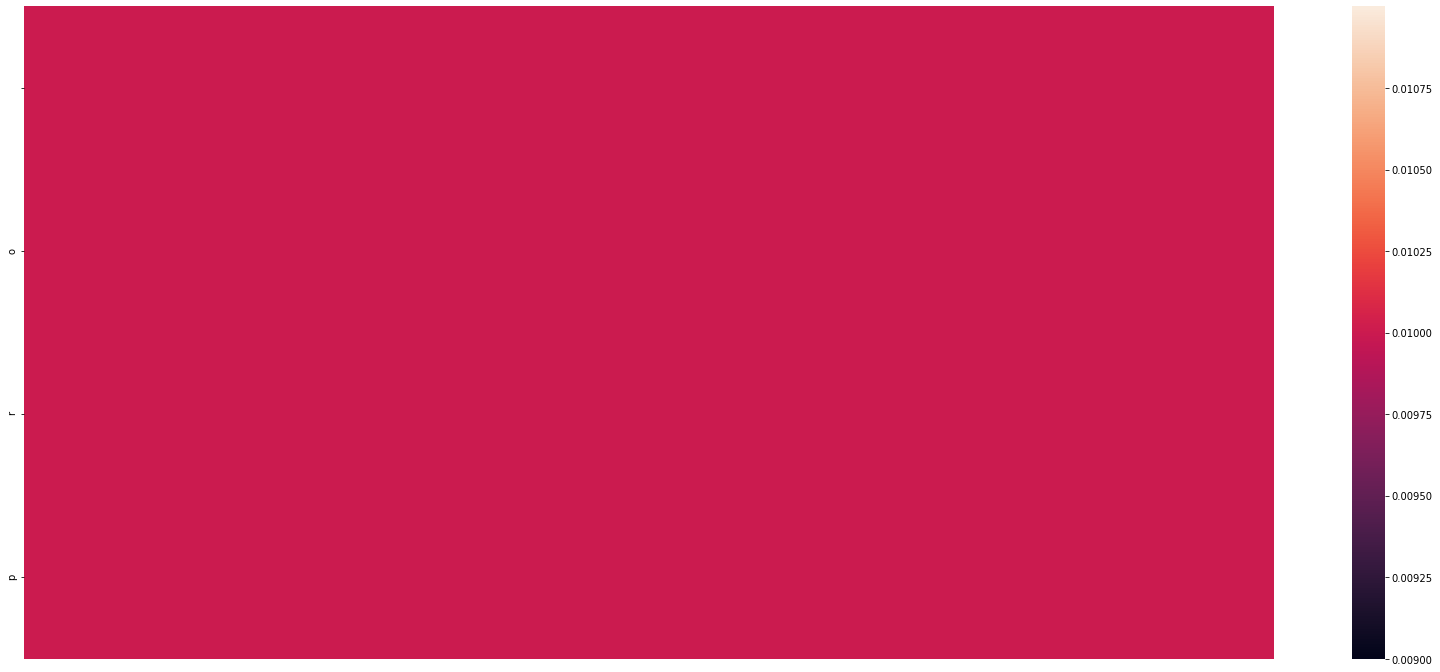

Decoded sentence: pro

-
Input sentence: 
GT sentence: 	patient mrn accession no ref physician



<Figure size 432x288 with 0 Axes>

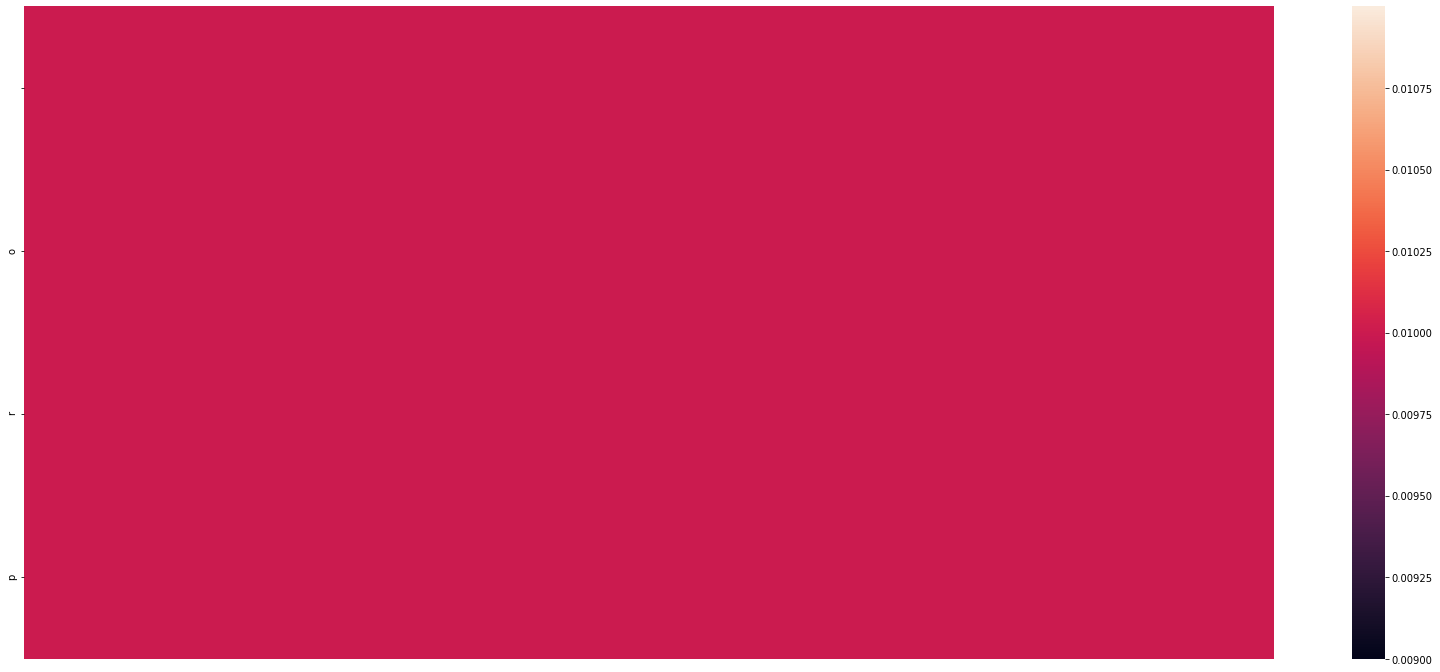

Decoded sentence: pro

-
Input sentence: unknown
GT sentence: 	unknown



<Figure size 432x288 with 0 Axes>

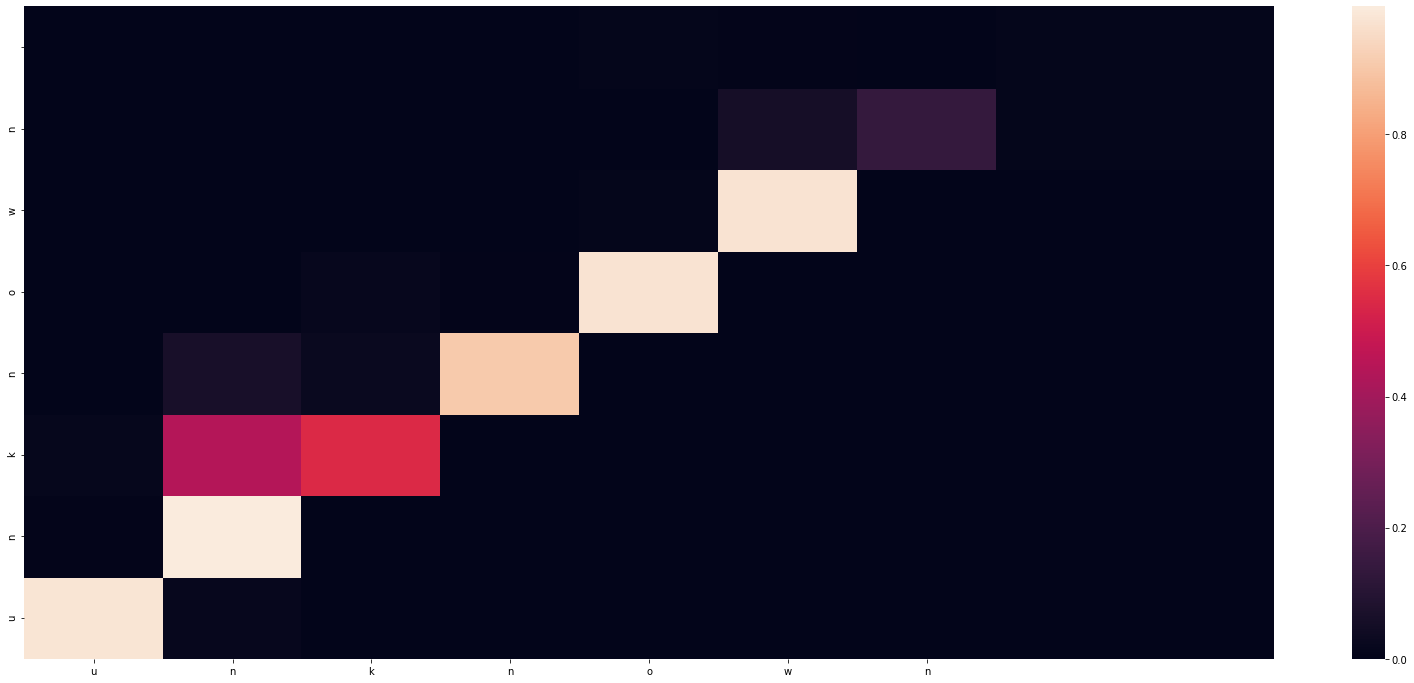

Decoded sentence: unknown

-
Input sentence: 
GT sentence: 	study 



<Figure size 432x288 with 0 Axes>

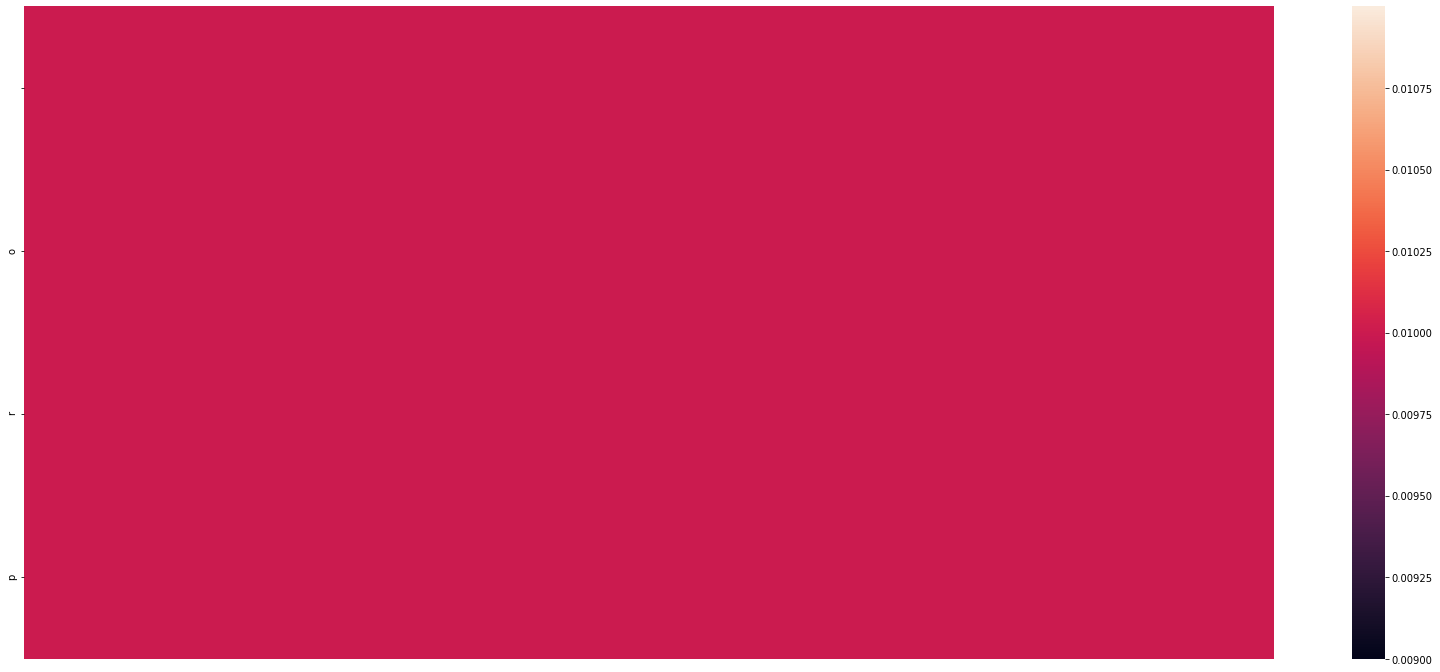

Decoded sentence: pro

-
Input sentence: 
GT sentence: 	study date



<Figure size 432x288 with 0 Axes>

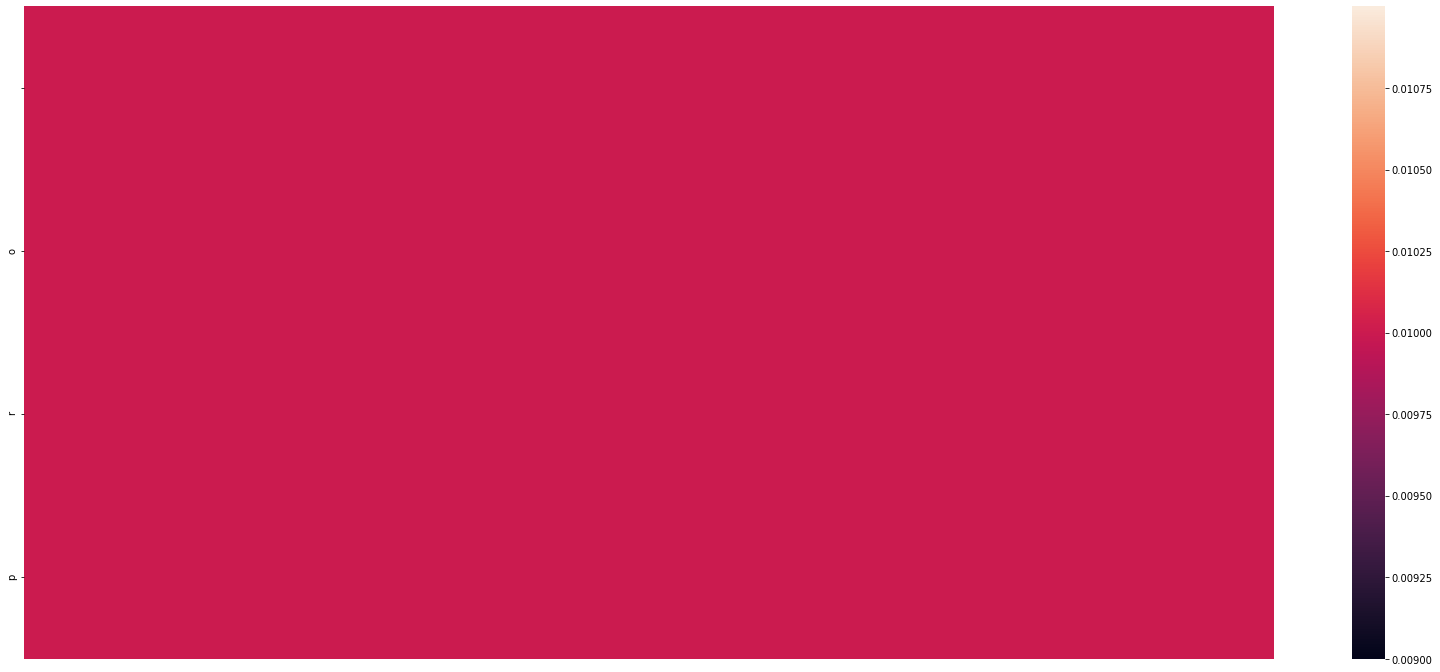

Decoded sentence: pro

-
Input sentence: 
GT sentence: 	hospital code  



<Figure size 432x288 with 0 Axes>

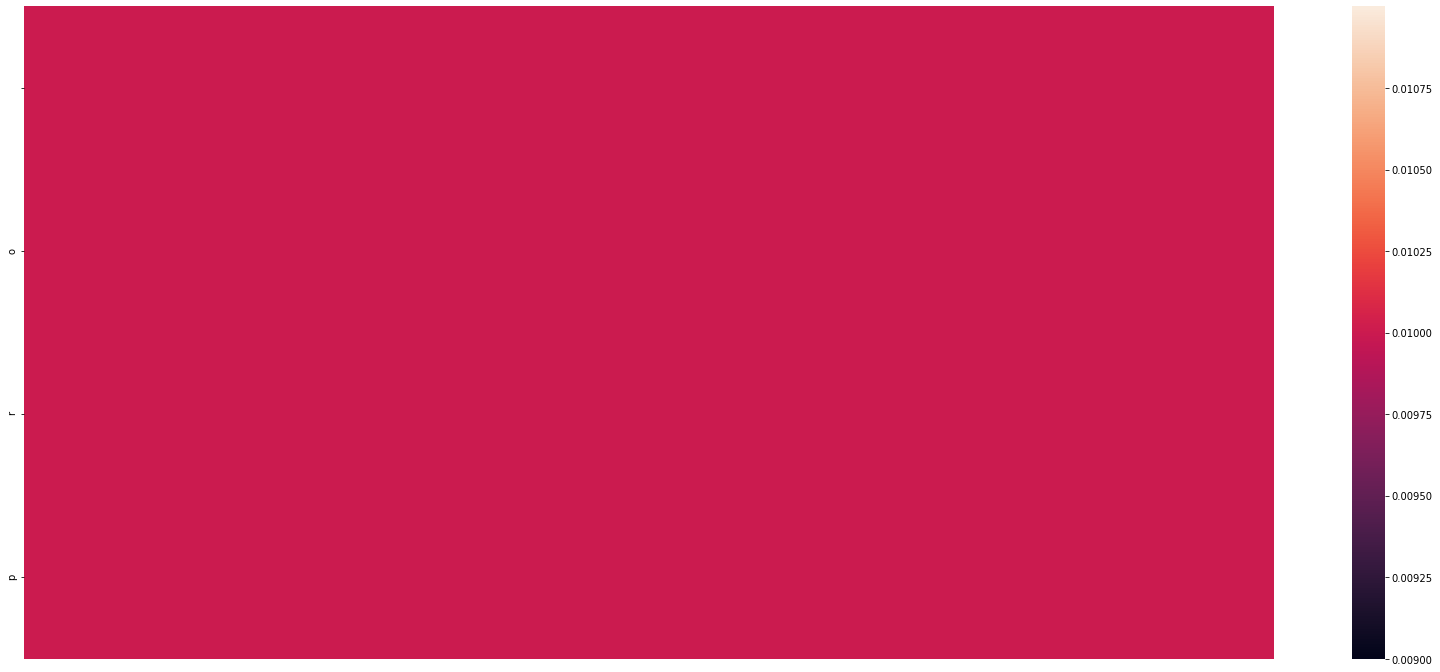

Decoded sentence: pro

-
Input sentence: 
GT sentence: 	dob



<Figure size 432x288 with 0 Axes>

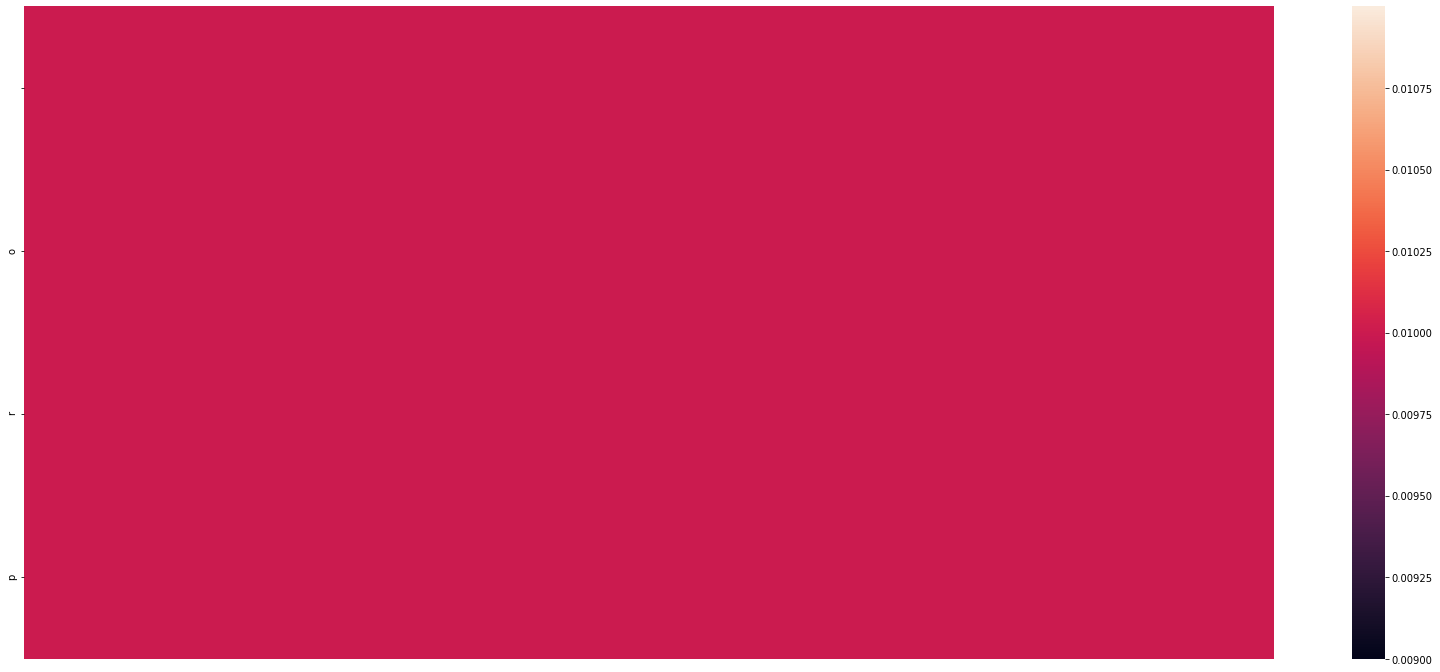

Decoded sentence: pro

-
Input sentence: 
GT sentence: 	tech notes v lt wrist  wc initial  dr wortman  xray wrist COMMA comp cr more view  uncol



<Figure size 432x288 with 0 Axes>

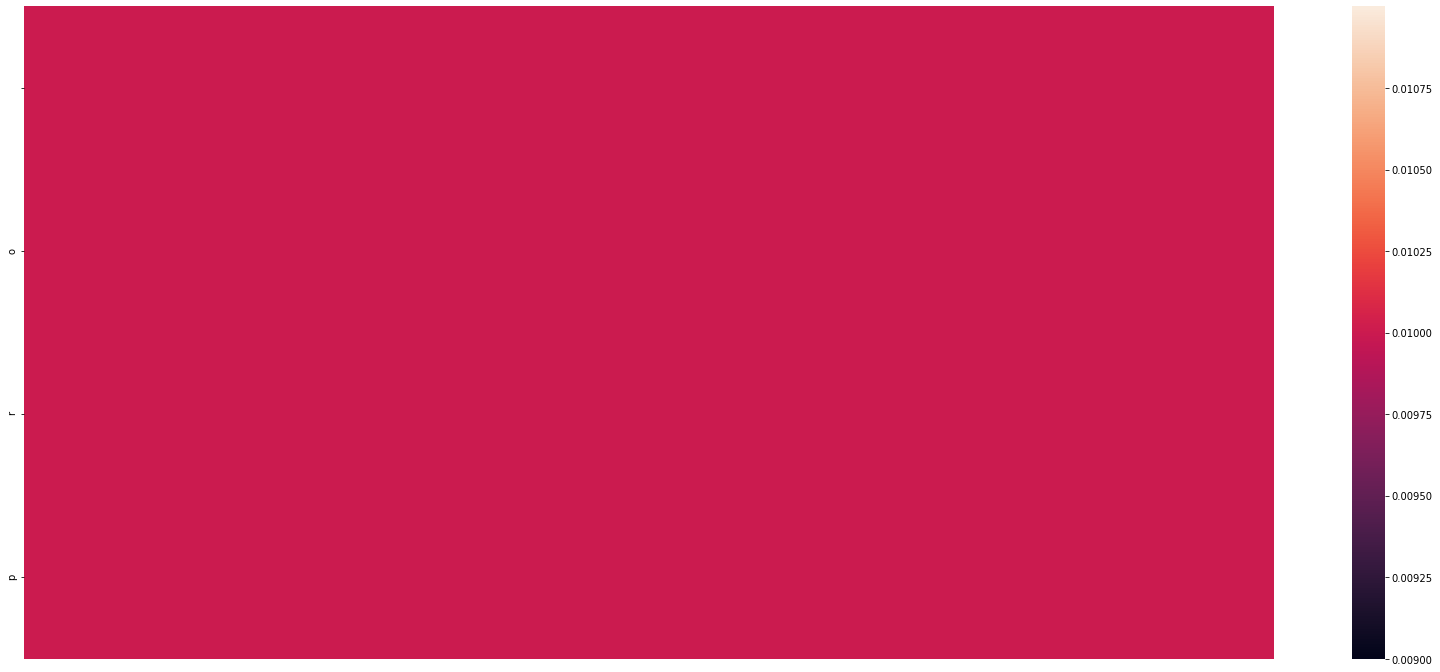

Decoded sentence: pro

-
Input sentence: 
GT sentence: 	f



<Figure size 432x288 with 0 Axes>

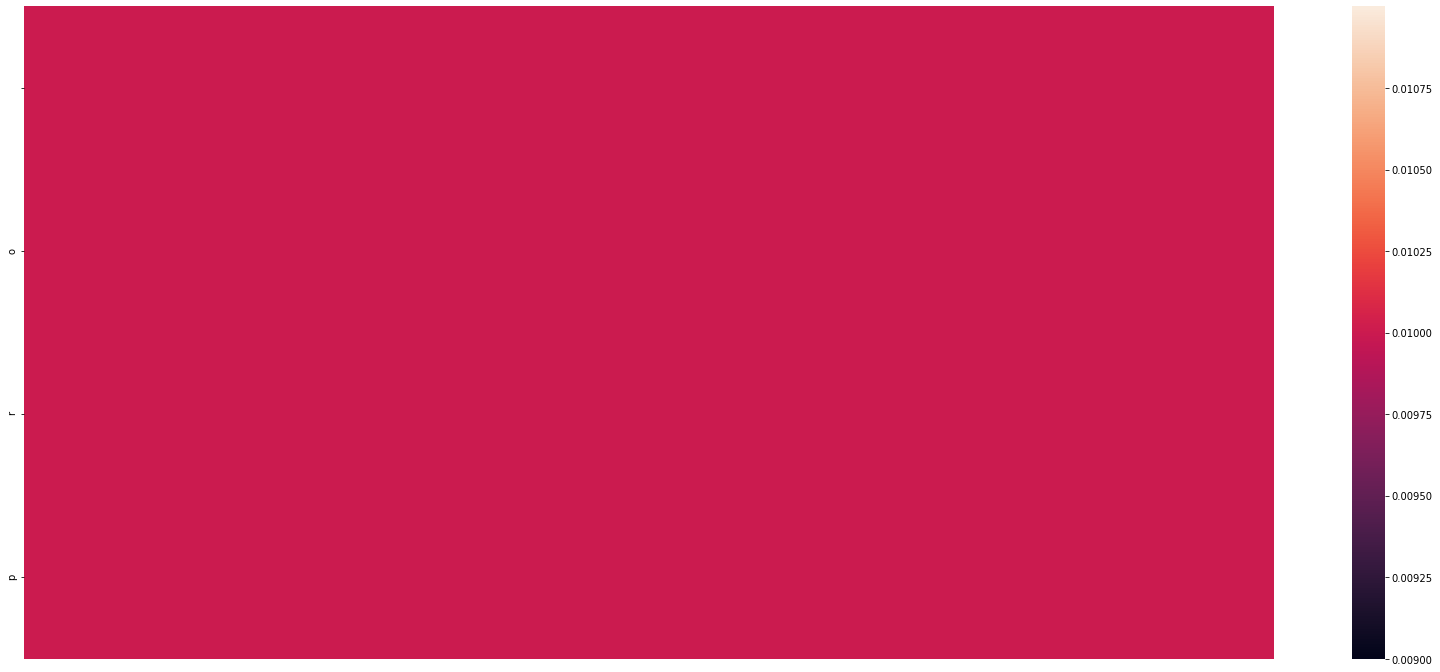

Decoded sentence: pro

-
Input sentence: techiqn  vim left mist
GT sentence: 	technique  views left wrist



<Figure size 432x288 with 0 Axes>

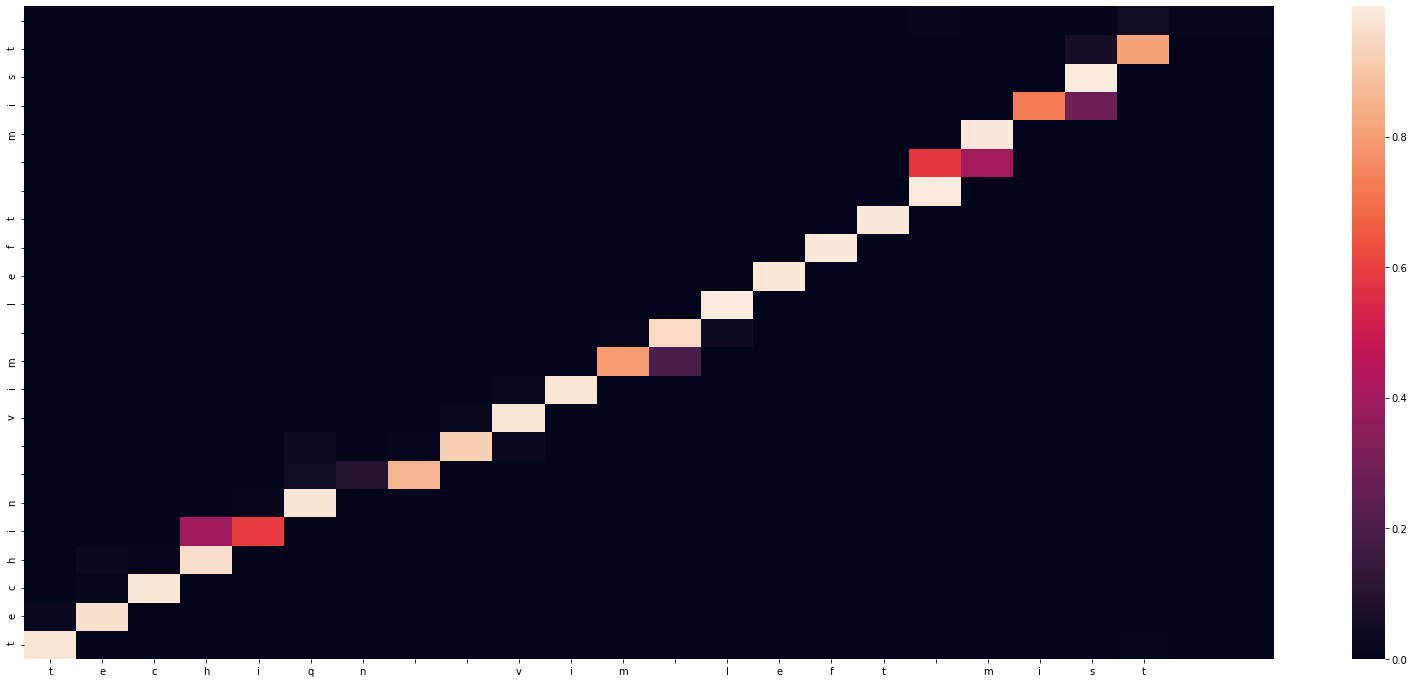

Decoded sentence: techin  vim left  mist

-
Input sentence: 
GT sentence: 	cormarison none availabie



<Figure size 432x288 with 0 Axes>

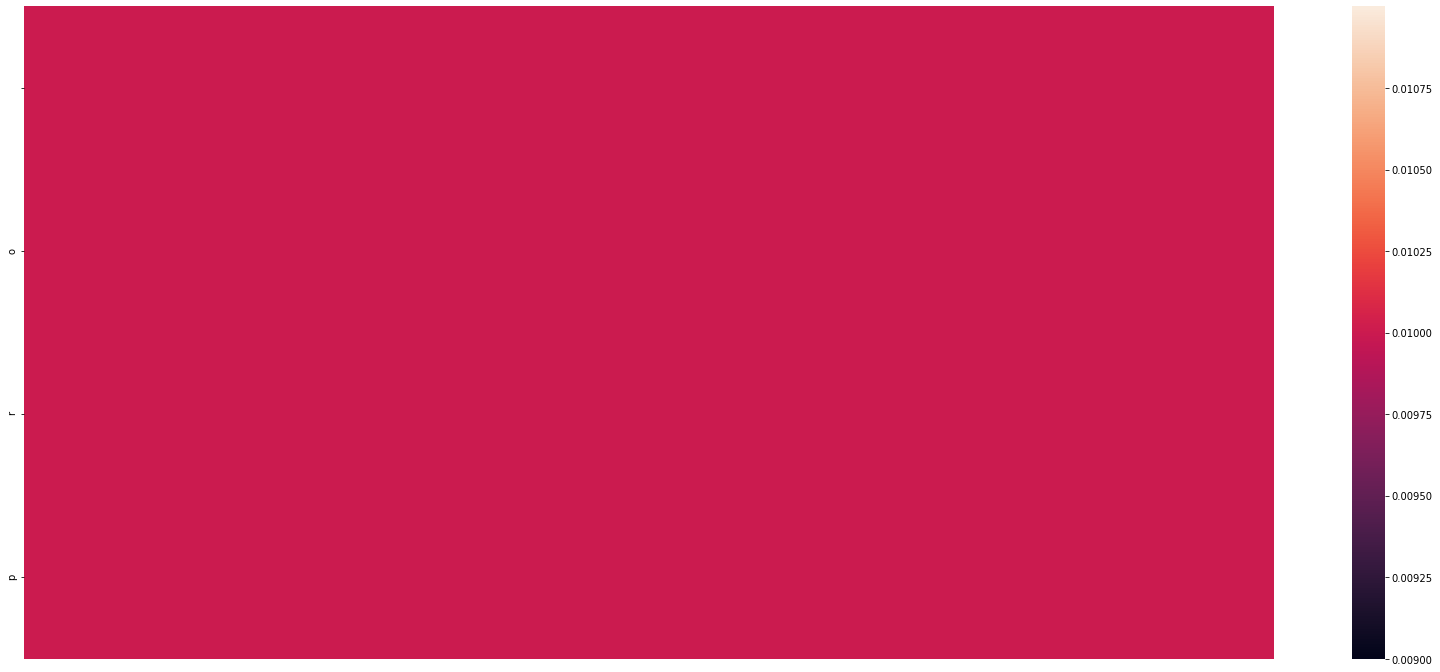

Decoded sentence: pro

-
Input sentence: 
GT sentence: 	comparison none available



<Figure size 432x288 with 0 Axes>

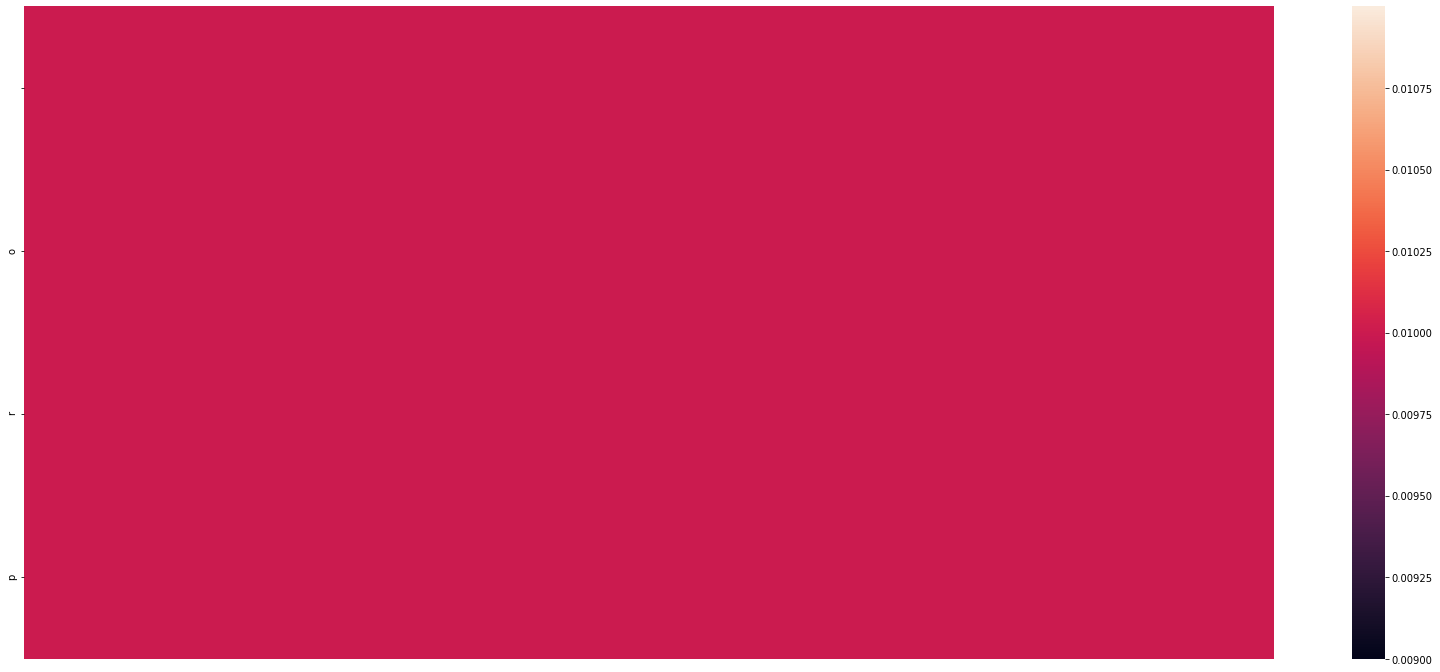

Decoded sentence: pro

-
Input sentence: findings
GT sentence: 	findings



<Figure size 432x288 with 0 Axes>

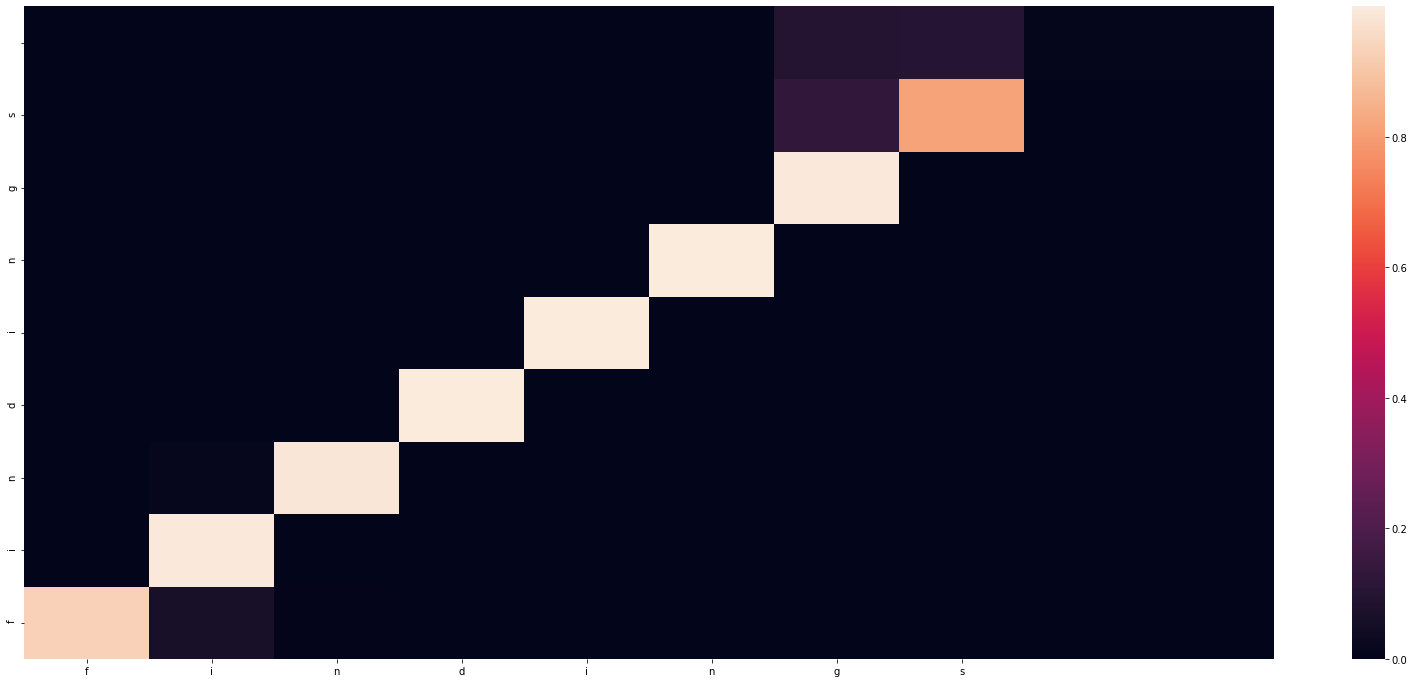

Decoded sentence: findings

-
Input sentence: awmmossiﬁcdunﬁyuencﬁdalbmdmcﬁoﬂ
GT sentence: 	a wellcorticated ossific density seen distal to the ulnar styloid



<Figure size 432x288 with 0 Axes>

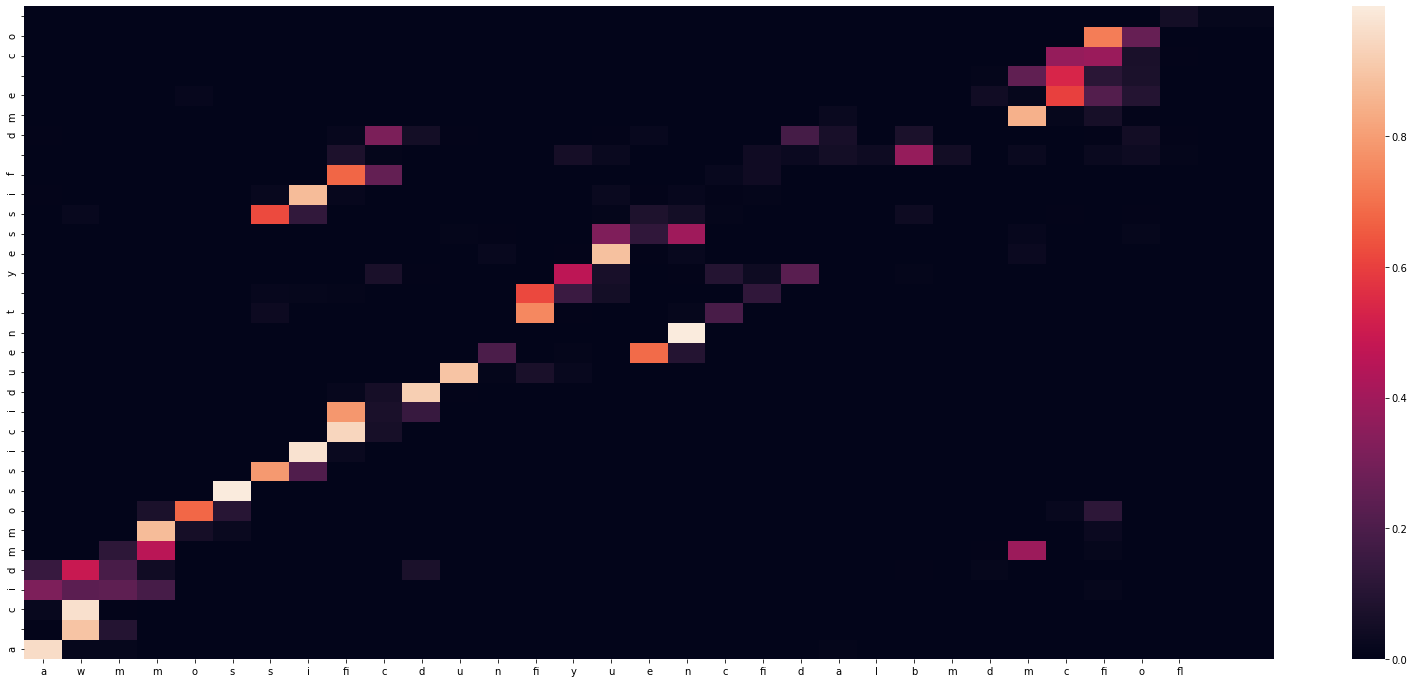

Decoded sentence: a cidmmossiciduent yessif dme co

-
Input sentence: nofoaal abmmaﬁtyisseenhﬂn mountings
GT sentence: 	no focal abnormality is seen in the standing soft tissues



<Figure size 432x288 with 0 Axes>

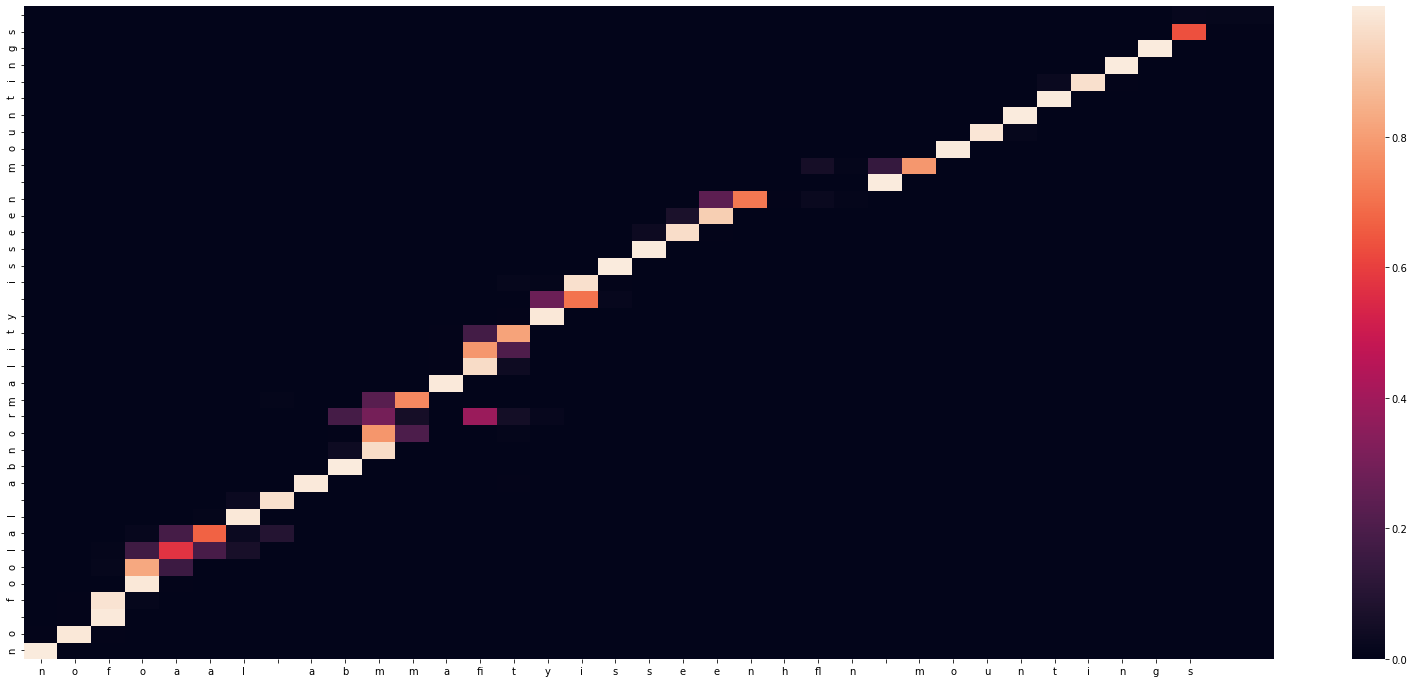

Decoded sentence: no foolal abnormality isseen mountings

-
Input sentence: impression
GT sentence: 	impression



<Figure size 432x288 with 0 Axes>

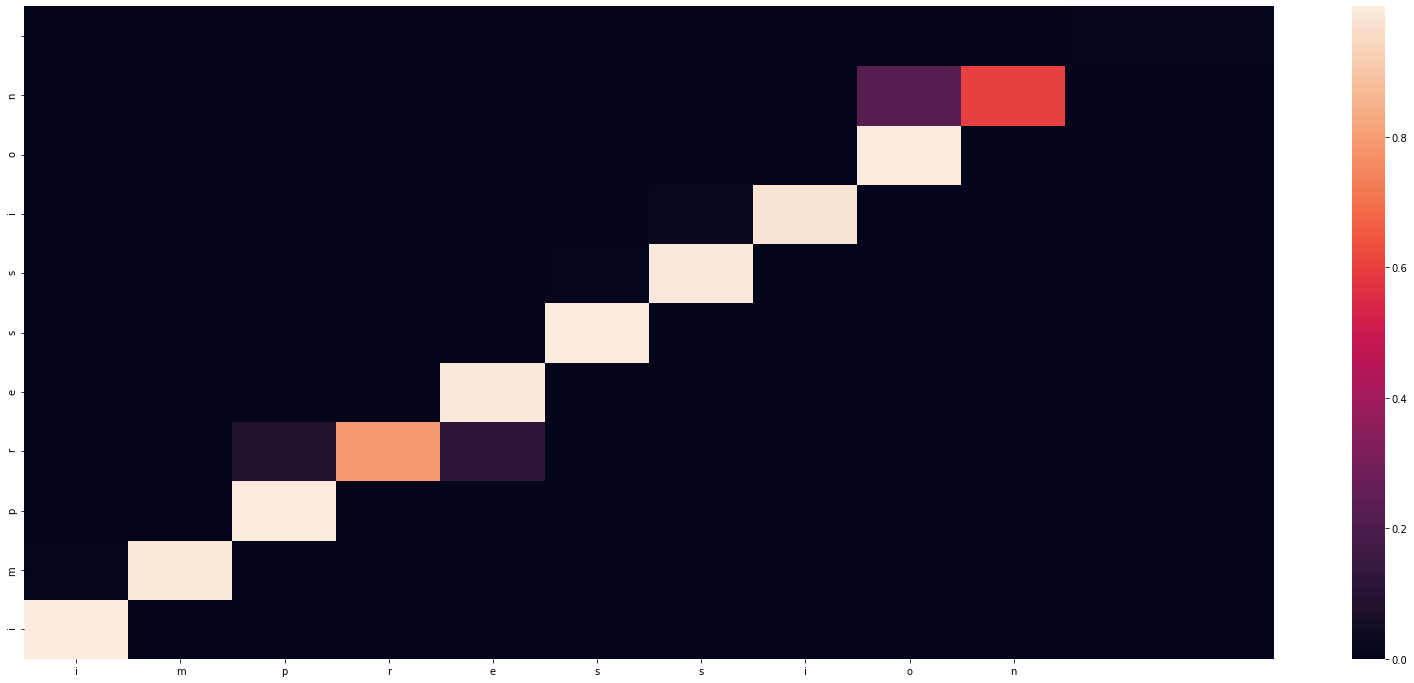

Decoded sentence: impression

-
Input sentence: agitationleaner
GT sentence: 	 wellcorticated ossific density distal to the ulnar styloid possible sequela of remote trauma or unfused ossification center



<Figure size 432x288 with 0 Axes>

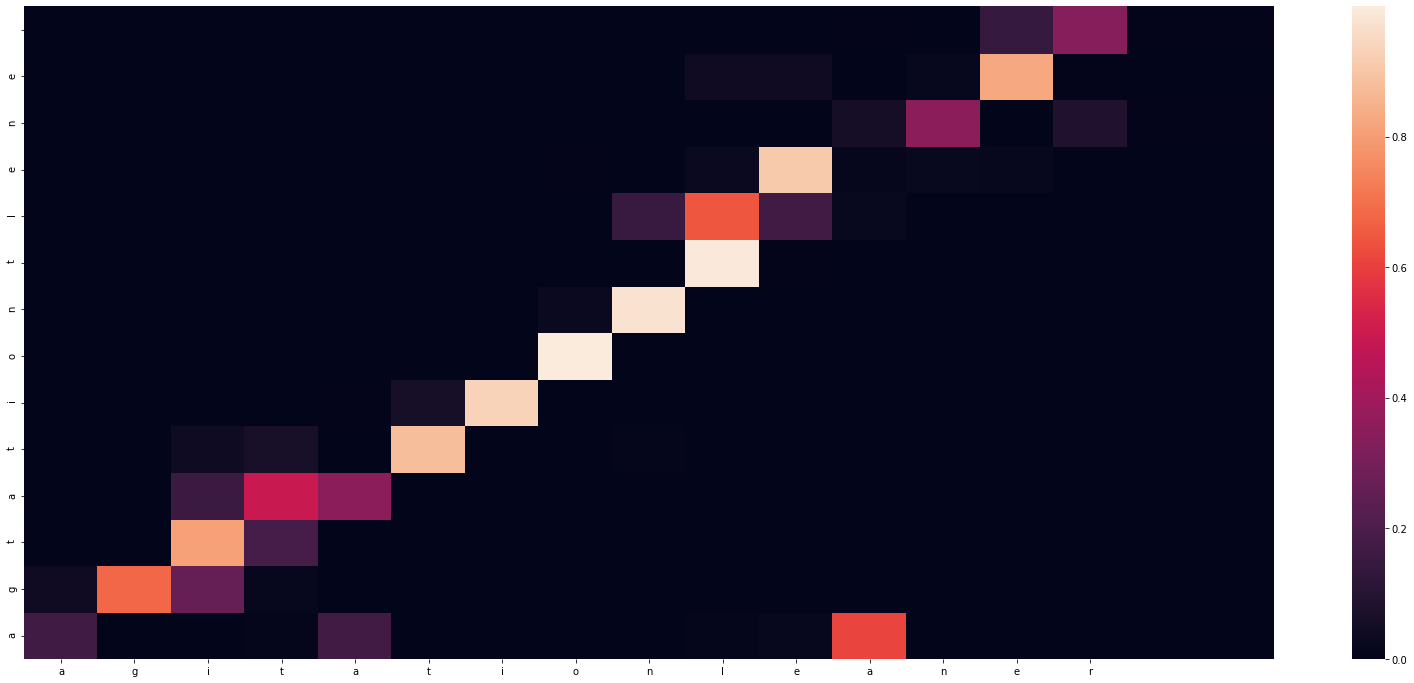

Decoded sentence: agtationtlene

-
Input sentence:  noawemamliy harmed
GT sentence: 	 no acute osseous abnormality identified



<Figure size 432x288 with 0 Axes>

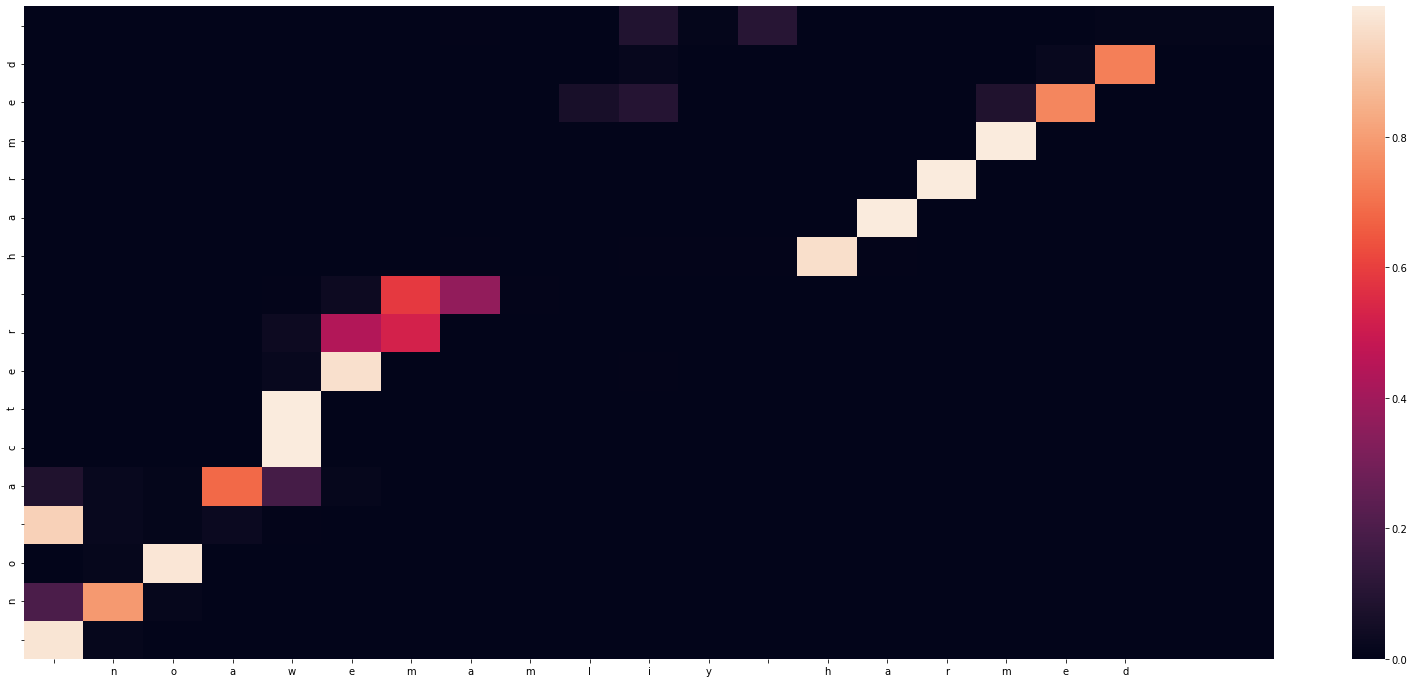

Decoded sentence:  no acter harmed

-
Input sentence: daytime phone
GT sentence: 	daytime phone



<Figure size 432x288 with 0 Axes>

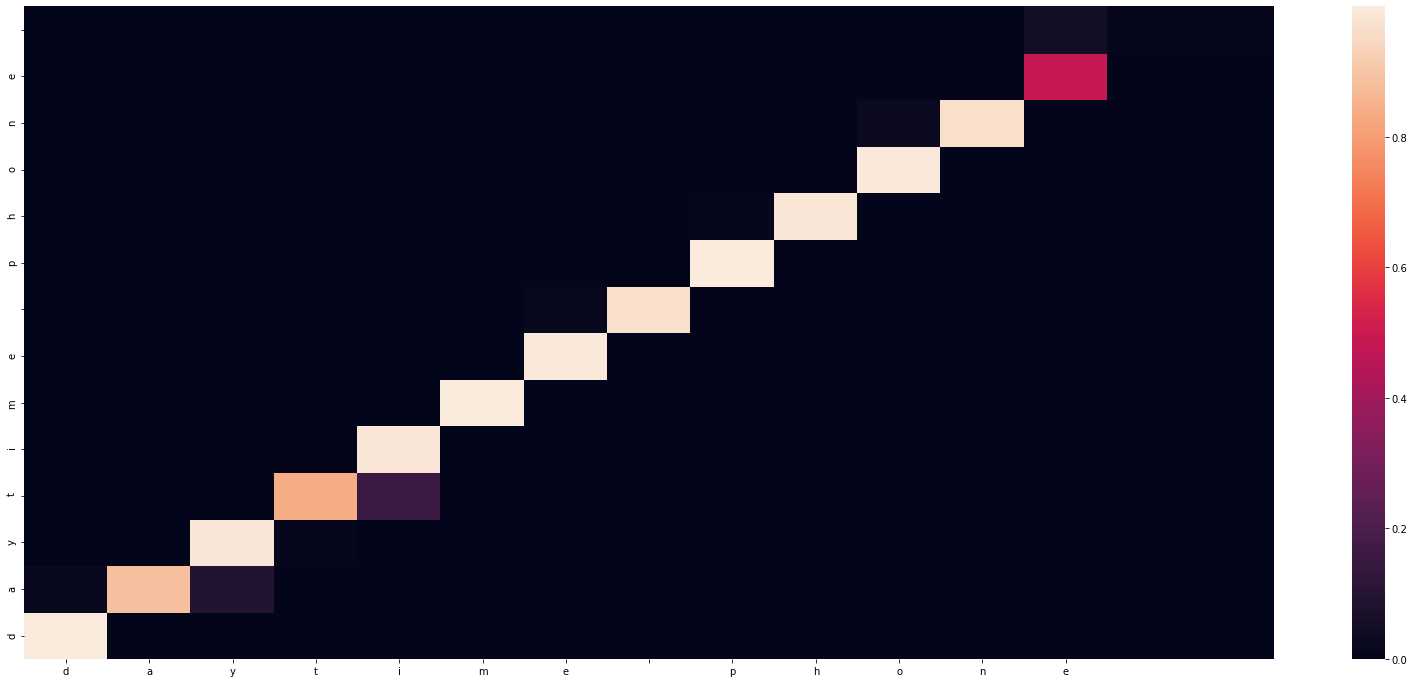

Decoded sentence: daytime phone

-
Input sentence: claim eran r information
GT sentence: 	claim event information



<Figure size 432x288 with 0 Axes>

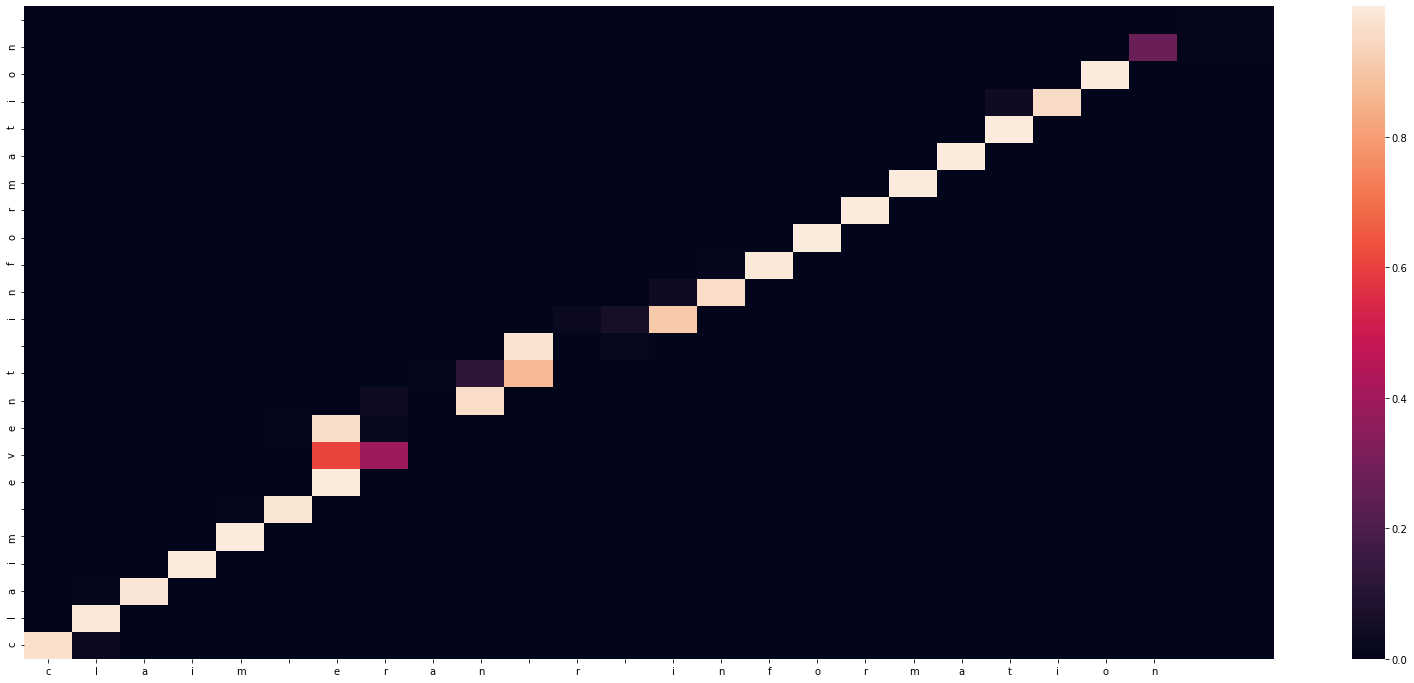

Decoded sentence: claim event information

-
Input sentence: stopped ‘workinng yes
GT sentence: 	stopped working yes



<Figure size 432x288 with 0 Axes>

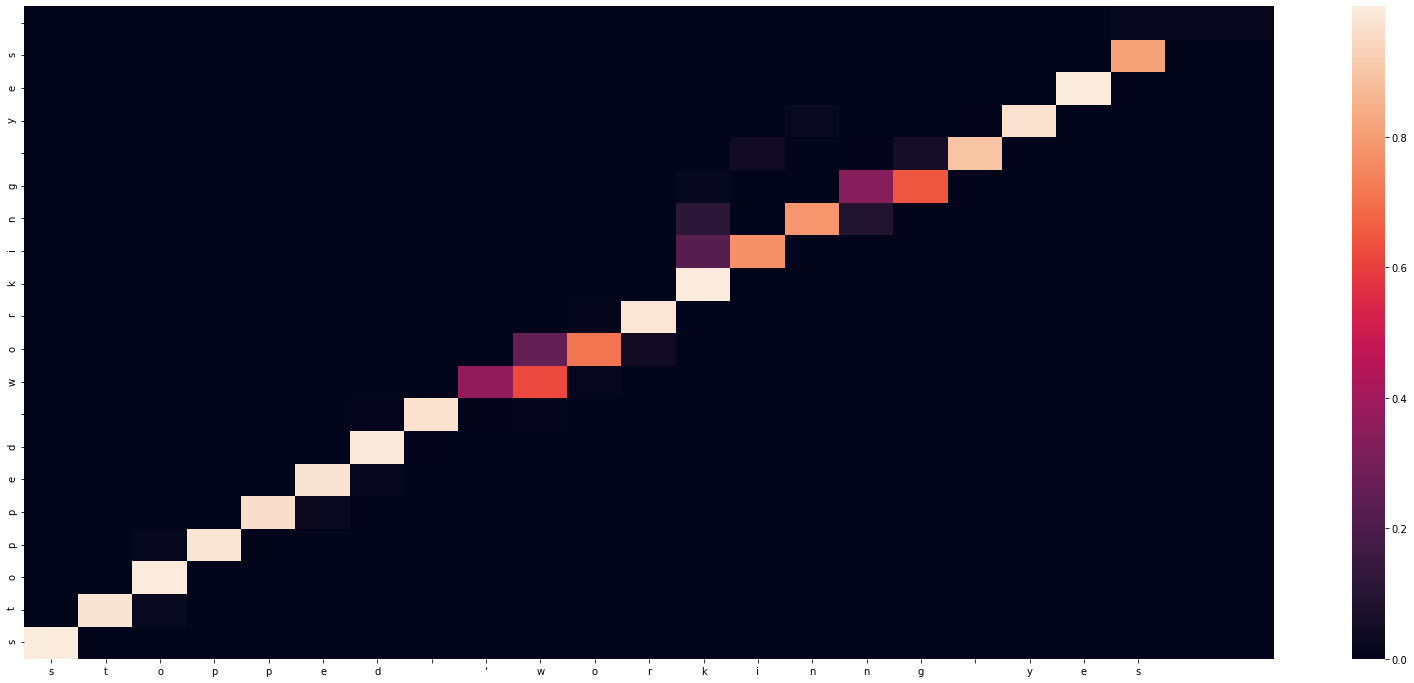

Decoded sentence: stopped working yes

-
Input sentence: date last physically at ‘work
GT sentence: 	date last physically at work



<Figure size 432x288 with 0 Axes>

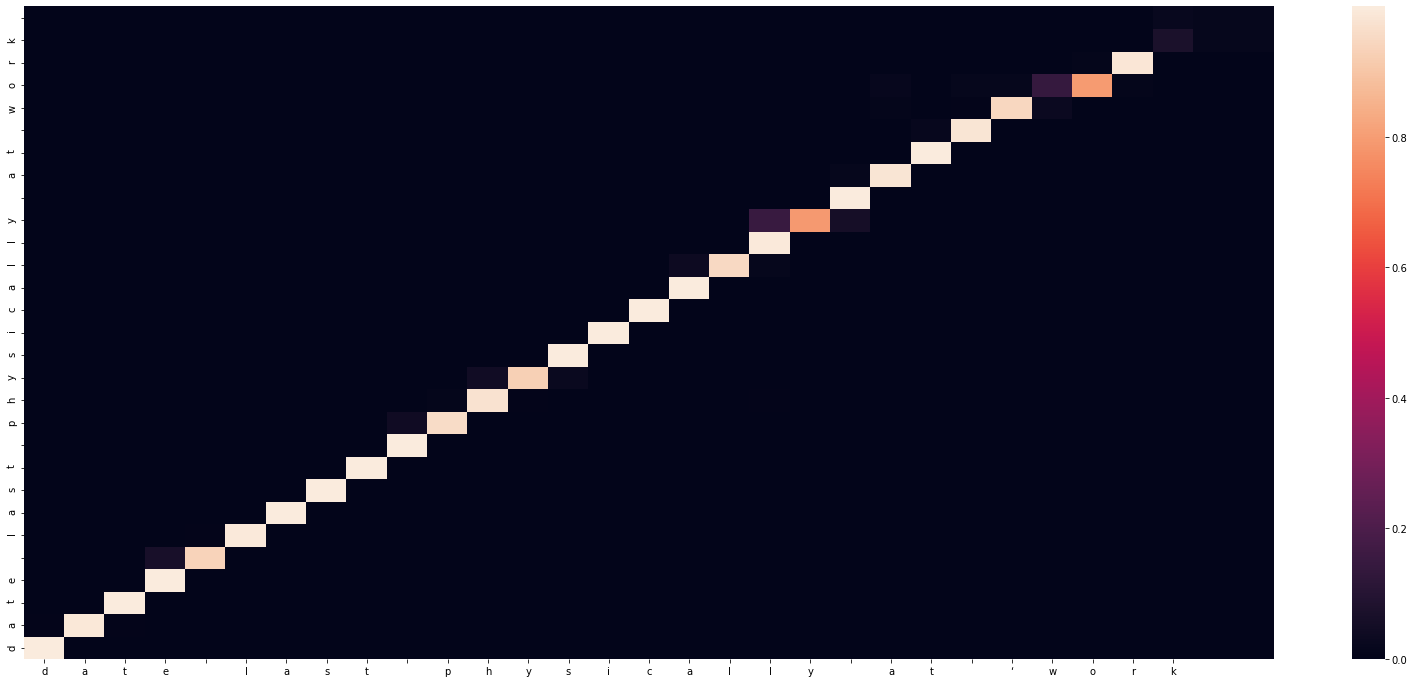

Decoded sentence: date last physically at work

-
Input sentence: hours ‘worked on last day 
GT sentence: 	hours worked on last day 



<Figure size 432x288 with 0 Axes>

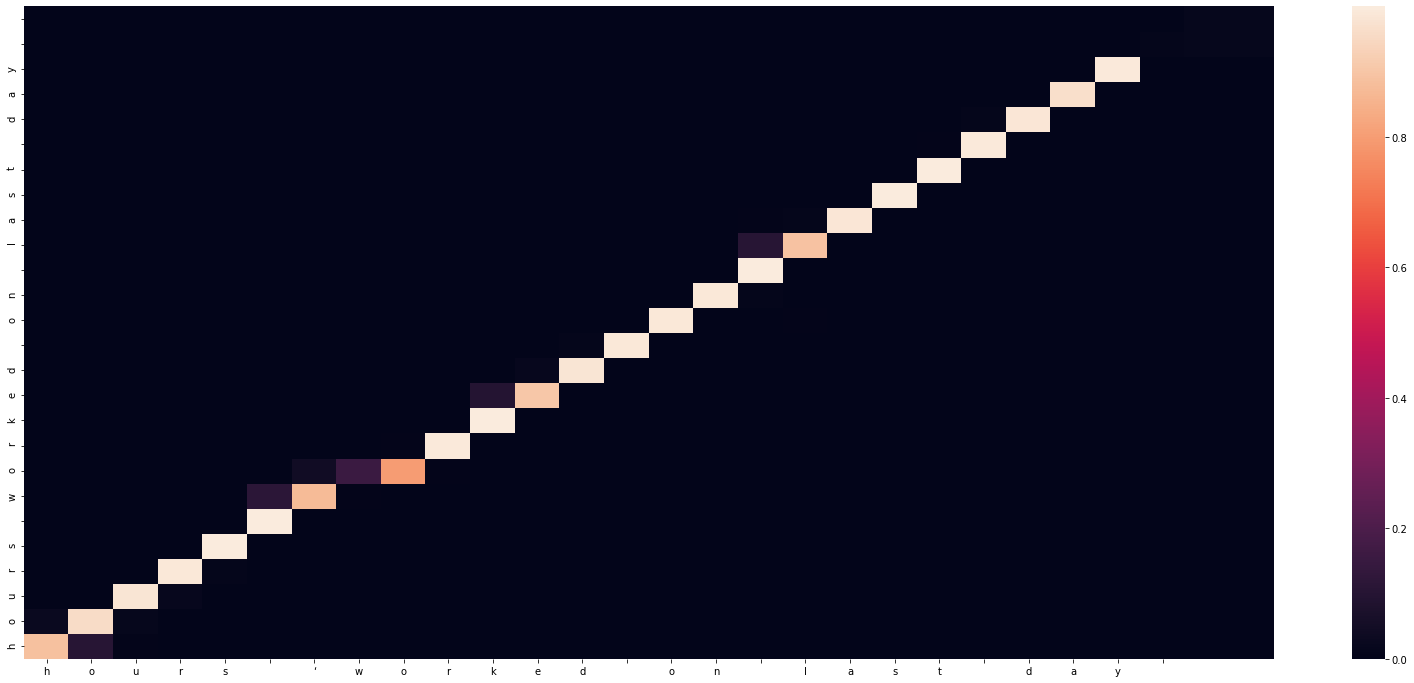

Decoded sentence: hours worked on last day 

-
Input sentence: hours scheduled to work on last day
GT sentence: 	hours scheduled to work on last day



<Figure size 432x288 with 0 Axes>

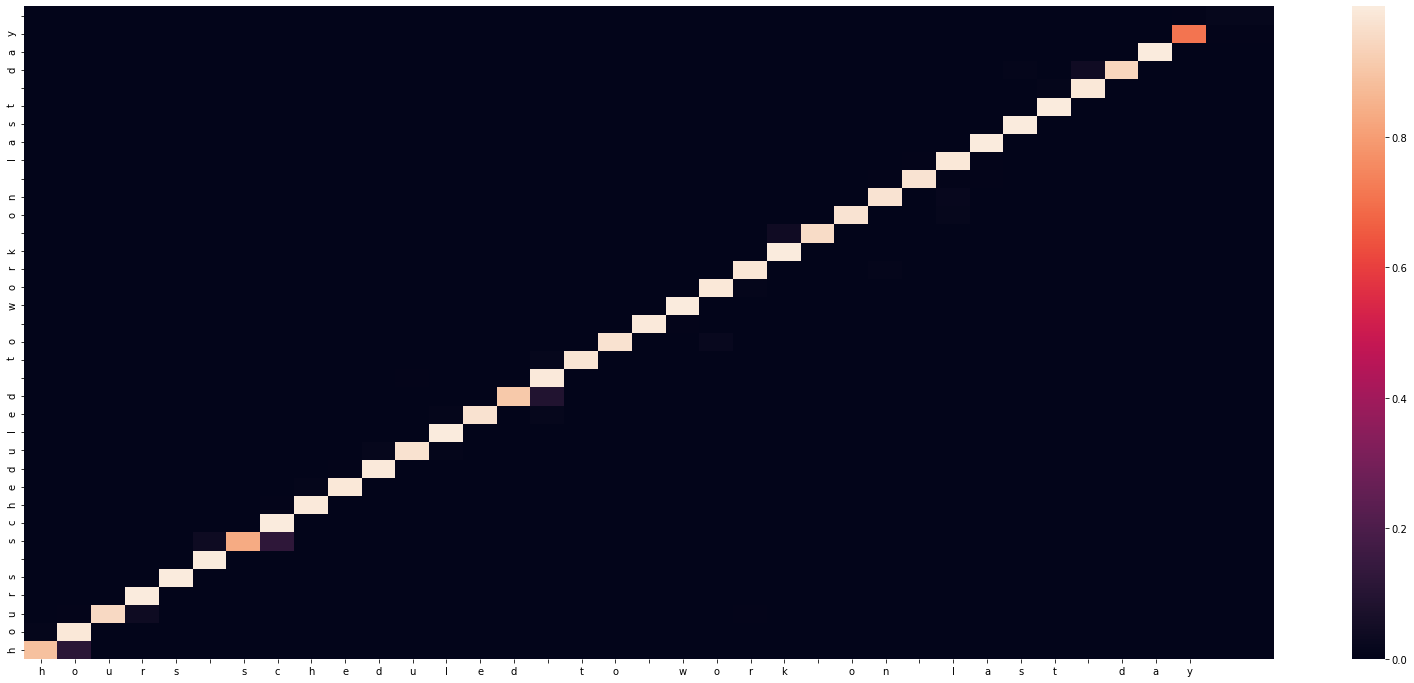

Decoded sentence: hours scheduled to work on last day

-
Input sentence: explanation ofchange in schedule i was on light duty to injury of wrist but last date worked due to other injury ofknee is what put me out ofwork
GT sentence: 	explanation of change in schedule i was on light duty to injury of wrist but COMMA last date worked due to other injury of knee is what put me out of work



IndexError: ignored

In [ ]:
for seq_index in range(100):

    target_text = lines.target[seq_index]
    text = lines.input[seq_index]
    print('-')
    print('Input sentence:', text)    
    print('GT sentence:', target_text)
    decoded_sentence = visualize_attention(text, encoder_model, decoder_model, max_encoder_seq_length, num_decoder_tokens, input_token_index, reverse_target_tok_index, tok_split_fn, sep='')

    
    print('Decoded sentence:', decoded_sentence) 

# Evaluation



___In seq2seq tasks, accuracy is not always a good metric:___


- Accuracy definition is different according to the definition of _what is a token?_. As can be seen above, char level has much higher accuracy, but that doesn't mean a better NMT system!

What we care about is getting the correct sequence of _words_

- The input and target sequences are not necessarily aligned. We might have:
  - Deletions
  - Substitutions
  - Insertions


For that, we calculate the 1-edit distance as follows:

In [ ]:
def calculate_WER_sent(gt, pred):
    '''
    calculate_WER('calculating wer between two sentences', 'calculate wer between two sentences')
    '''
    gt_words = gt.lower().split(' ')
    pred_words = pred.lower().split(' ')
    d = np.zeros(((len(gt_words) + 1), (len(pred_words) + 1)), dtype=np.uint8)
    # d = d.reshape((len(gt_words)+1, len(pred_words)+1))

    # Initializing error matrix
    for i in range(len(gt_words) + 1):
        for j in range(len(pred_words) + 1):
            if i == 0:
                d[0][j] = j
            elif j == 0:
                d[i][0] = i

    # computation
    for i in range(1, len(gt_words) + 1):
        for j in range(1, len(pred_words) + 1):
            if gt_words[i - 1] == pred_words[j - 1]:
                d[i][j] = d[i - 1][j - 1]
            else:
                substitution = d[i - 1][j - 1] + 1
                insertion = d[i][j - 1] + 1
                deletion = d[i - 1][j] + 1
                d[i][j] = min(substitution, insertion, deletion)
    return d[len(gt_words)][len(pred_words)]
def calculate_WER(gt, pred):
    '''

    :param gt: list of sentences of the ground truth
    :param pred: list of sentences of the predictions
    both lists must have the same length
    :return: accumulated WER
    '''
#    assert len(gt) == len(pred)
    WER = 0
    nb_w = 0
    for i in range(len(gt)):
        #print(gt[i])
        #print(pred[i])
        WER += calculate_WER_sent(gt[i], pred[i])
        nb_w += len(gt[i])

    return WER / nb_w

Using this metric, we can better compare word to char models:

In [ ]:
target_sents = list(lines.target[:100])
target_sents = [x[1:-1] for x in target_sents]
word_decoded_sents = [' '.join(x.split()[1:-1]) for x in word_decoded_sents]
char_decoded_sents = [x[1:-1] for x in char_decoded_sents]


In [ ]:

WER_word = calculate_WER(target_sents, word_decoded_sents)
WER_char = calculate_WER(target_sents, char_decoded_sents)
print('Word level NMT WER = ', str(WER_word))
print('Char level NMT WER = ', str(WER_char))


Word level NMT WER =  0.1464725255676894
Char level NMT WER =  0.13069856127578436


As can be seen above, char level encoding improves a lot on the Encoder side. The metric is a bit misleading since it's on char level, but still the WER improvement is clear. 

A new issue arises, where we see some "_hallucination_" in the decoded chars. This is because the notion of _words_ are lost from the Decoder side.

In other words, we did not have _real_ words on the Encoder side, so we made a char level Embeddings. But we want to generate _real_ words at the Decoder, which is lost due to char level Decoder.

# Possible fixes:
- Custom loss: after the char2char model generates its output, decoder chat by char, then split/tokenize into `decoded_seq` as sequence of words. This enables to calculate a custom loss at the word level (which we care about). Possible losses are:
  - CTC loss: `ctc_loss(gt_seq, decoded_seq)`
  - WER loss: `calculate_WER(gt_seq, decoded_seq)`

- char2word: input=char level, output=word level
  - Learn word boundaries/notion end2end
  - Leading to similar situation as custom loss; the loss will be higher as long as we don't decode the exact needed word.

  - Could be integrated with pre-trained decoder on word level NLM. 

# Char2Word

In [ ]:
lines = pd.DataFrame({'input':inputs, 'target':targets})
num_samples = 10000
lines = lines[0:num_samples]
pad_tok = 'PAD'
sep_tok = ' '
st_tok = 'START_'
end_tok = '_END'
def data_prep(lines):
  cleanup(lines)
  lines.target = lines.target.apply(lambda x : st_tok + ' ' + x + ' ' + end_tok)
data_prep(lines)

input_tok_split_fn = tok_split_char2char
target_tok_split_fn=tok_split_word2word 

lstm_sz = emb_sz = 50


input_tokens, target_tokens, num_encoder_tokens, num_decoder_tokens, max_encoder_seq_length, max_decoder_seq_length = data_stats(lines, input_tok_split_fn, target_tok_split_fn)
print('Number of samples:', len(lines))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

max_encoder_seq_length = 116 
max_decoder_seq_length = 100

  
special_tokens = [pad_tok, sep_tok, st_tok, end_tok]
num_encoder_tokens += len(special_tokens)
num_decoder_tokens += len(special_tokens)



input_token_index, target_token_index, reverse_input_tok_index, reverse_target_tok_index = vocab(input_tokens, target_tokens)

maxlen = 90
minlen = 4
def check_len(line, tok_split_fn):
  l = len(tok_split_fn(line))
  if l < minlen or l > maxlen:
    return False
  return True
  
encoder_input_data, decoder_input_data, decoder_target_data  = vectorize(lines, max_encoder_seq_length, max_decoder_seq_length, num_decoder_tokens, input_tok_split_fn, target_tok_split_fn)

model, encoder_model, decoder_model = seq2seq_attention(num_encoder_tokens, num_decoder_tokens, emb_sz, emb_sz)
print(model.summary())
plot_model(model)

model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=128,
          epochs=10,
          validation_split=0.05)
          


Number of samples: 5548
Number of unique input tokens: 46
Number of unique output tokens: 4154
Max sequence length for inputs: 2412
Max sequence length for outputs: 404
[<tf.Tensor 'concatenate_1/concat:0' shape=(None, 100) dtype=float32>, <tf.Tensor 'concatenate_2/concat:0' shape=(None, 100) dtype=float32>]
Tensor("lstm_2/transpose_2:0", shape=(None, None, 100), dtype=float32)
Tensor("bidirectional_1/concat:0", shape=(None, None, 100), dtype=float32)
attention Tensor("attention/truediv:0", shape=(None, None, None), dtype=float32)
encoder-decoder  model:
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 5270 samples, validate on 278 samples
Epoch 1/10
5270/5270 [==============================] - 62s 12ms/step - loss: 0.2659 - acc: 0.1893 - val_loss: 0.3324 - val_acc: 0.1885
Epoch 2/10
5270/5270 [==============================] - 58s 11ms/step - loss: 0.2214 - acc: 0.2128 - val_loss: 0.3321 - val_acc: 0.2337
Epoch 3/10
5270/5270 [==============================] - 59s 11ms/step - loss: 0.2109 - acc: 0.2471 - val_loss: 0.3293 - val_acc: 0.2509
Epoch 4/10
5270/5270 [==============================] - 58s 11ms/step - loss: 0.2031 - acc: 0.2904 - val_loss: 0.3248 - val_acc: 0.3077
Epoch 5/10
5270/5270 [==============================] - 58s 11ms/step - loss: 0.1966 - acc: 0.3117 - val_loss: 0.3225 - val_acc: 0.3064
Epoch 6/10
5270/5270 [==============================] - 58s 11ms/step - loss: 0.1916 - acc: 0.3161 - val_loss: 0.3268 - val_acc: 0.3043
Epoch 7/10
5270/5270 [==============================] - 58s 11ms/step - loss: 0.1870 - acc: 0.3207 - val_loss: 0.3182 - val_acc: 0.3050
E

-
Input sentence: 0    claim type vb accident  accidental injury
Name: input, dtype: object
GT sentence: TART_ claim type vb accident  accidental injury _EN
Decoded sentence: dateofcoverageofcoverage_END
-
Input sentence: 1    “tho th  reported even  happen ed to enployeef...
Name: input, dtype: object
GT sentence: TART_ who the reported event happened to employeepolicyholder _EN
Decoded sentence: ifofthethethethethethethethethethethethethethethethethe
-
Input sentence: 2    pol inyhold elmchm er  form arlon
Name: input, dtype: object
GT sentence: TART_ policyholderowner information _EN
Decoded sentence: totalofcoveragecenter_END
-
Input sentence: 3    first name
Name: input, dtype: object
GT sentence: TART_ first name _EN
Decoded sentence: datedate_END
-
Input sentence: 4    middle nameﬂnitial
Name: input, dtype: object
GT sentence: TART_ middle nameinitial _EN
Decoded sentence: dateof_END
-
Input sentence: 5    last name
Name: input, dtype: object
GT sentence: TART_ last name _EN
Dec

<Figure size 432x288 with 0 Axes>

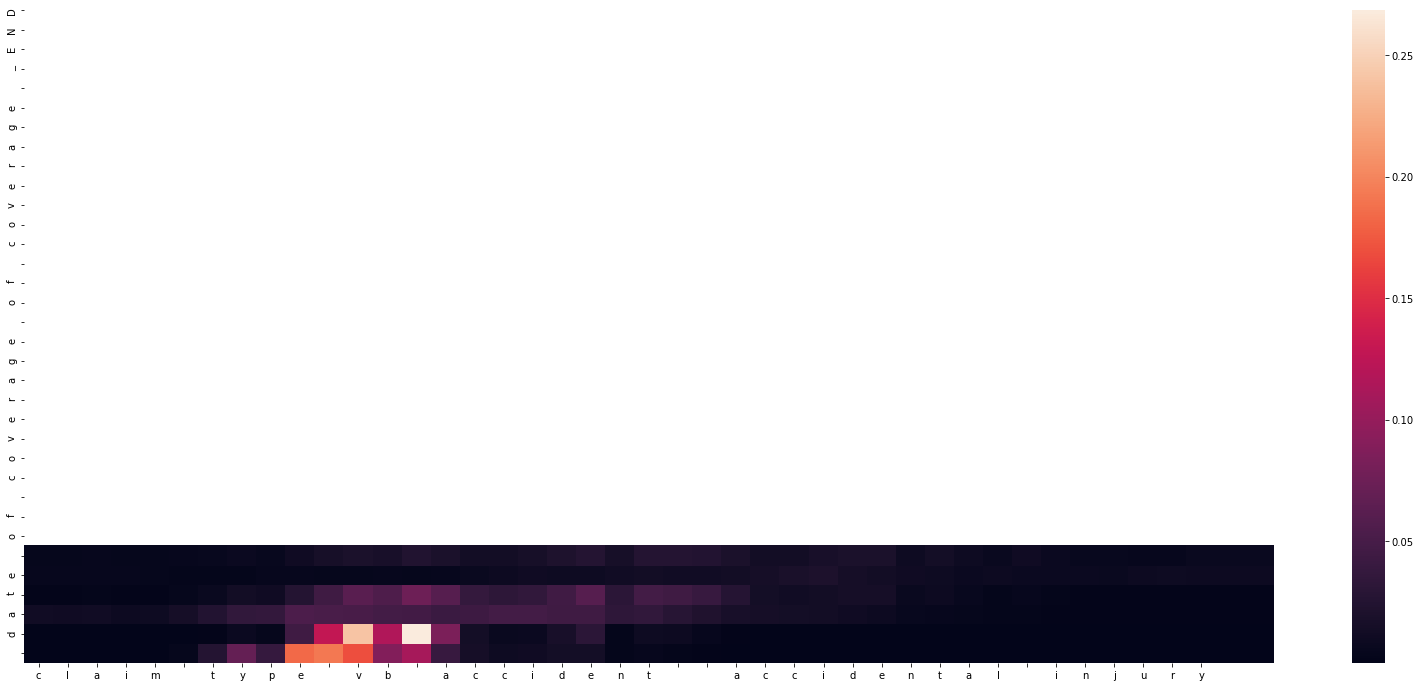

Decoded sentence:  date of coverage of coverage _END
-
Input sentence: “tho th  reported even  happen ed to enployeefpolicyholder
GT sentence: START_ who the reported event happened to employeepolicyholder _END


<Figure size 432x288 with 0 Axes>

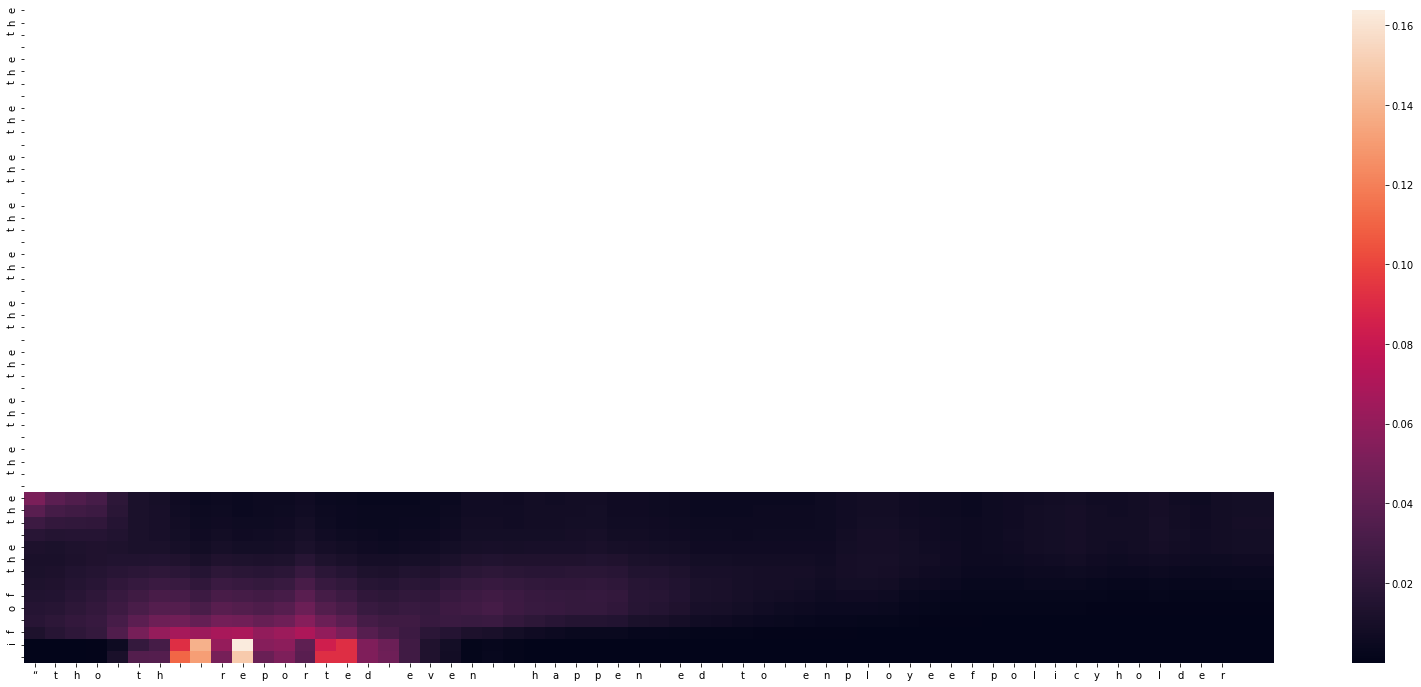

Decoded sentence:  if of the the the the the the the the the the the the
-
Input sentence: pol inyhold elmchm er  form arlon
GT sentence: START_ policyholderowner information _END


<Figure size 432x288 with 0 Axes>

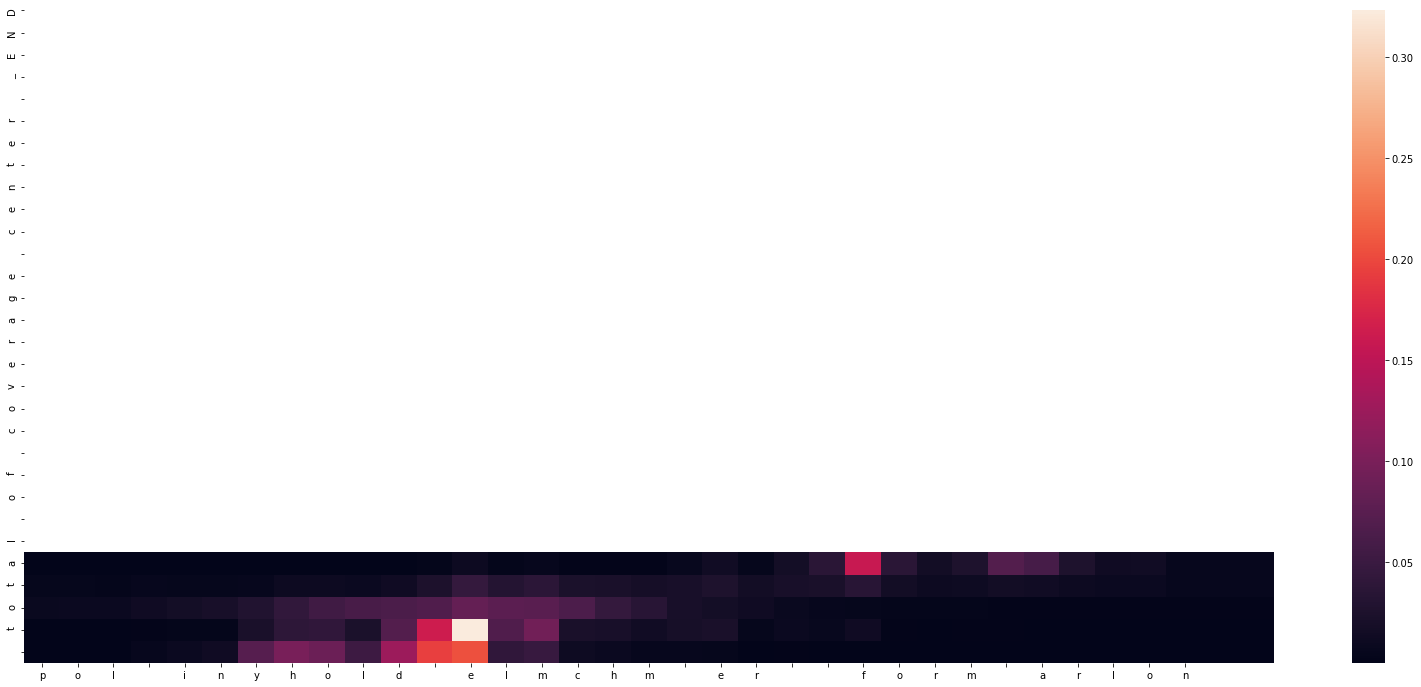

Decoded sentence:  total of coverage center _END
-
Input sentence: first name
GT sentence: START_ first name _END


<Figure size 432x288 with 0 Axes>

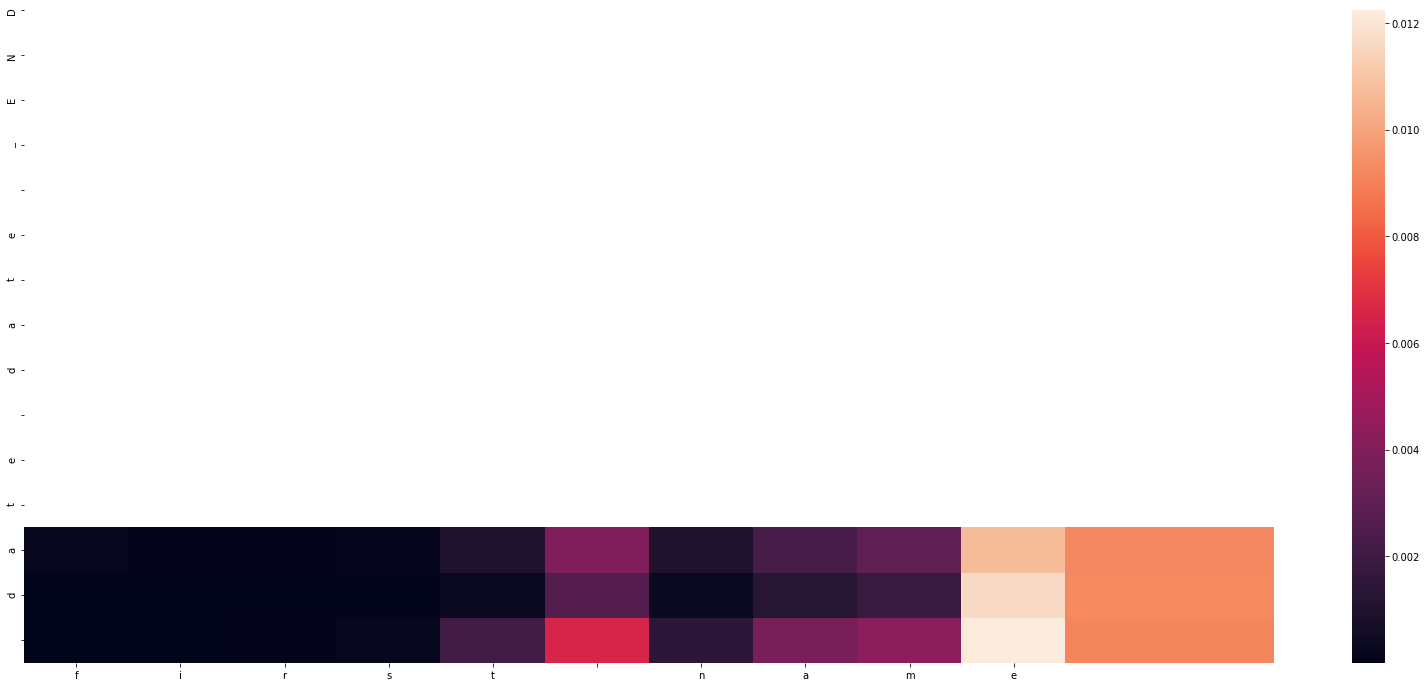

Decoded sentence:  date date _END
-
Input sentence: middle nameﬂnitial
GT sentence: START_ middle nameinitial _END


<Figure size 432x288 with 0 Axes>

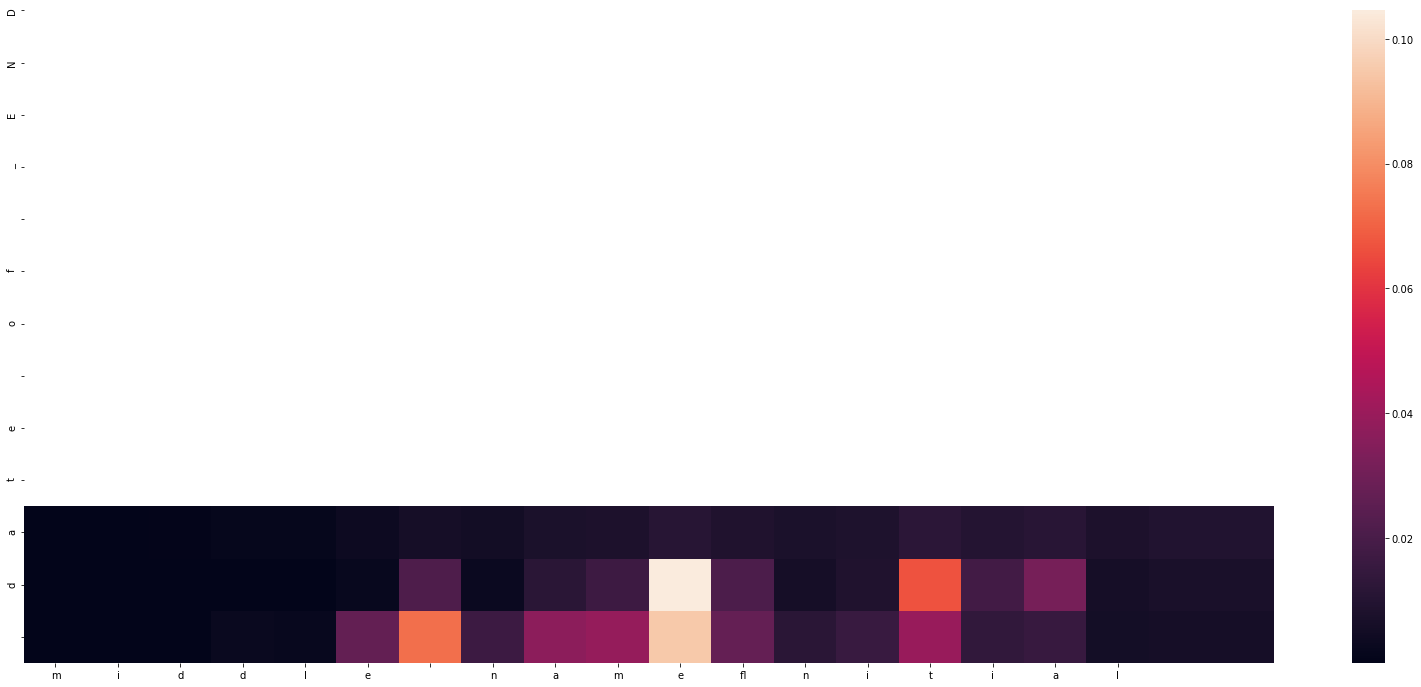

Decoded sentence:  date of _END
-
Input sentence: last name
GT sentence: START_ last name _END


<Figure size 432x288 with 0 Axes>

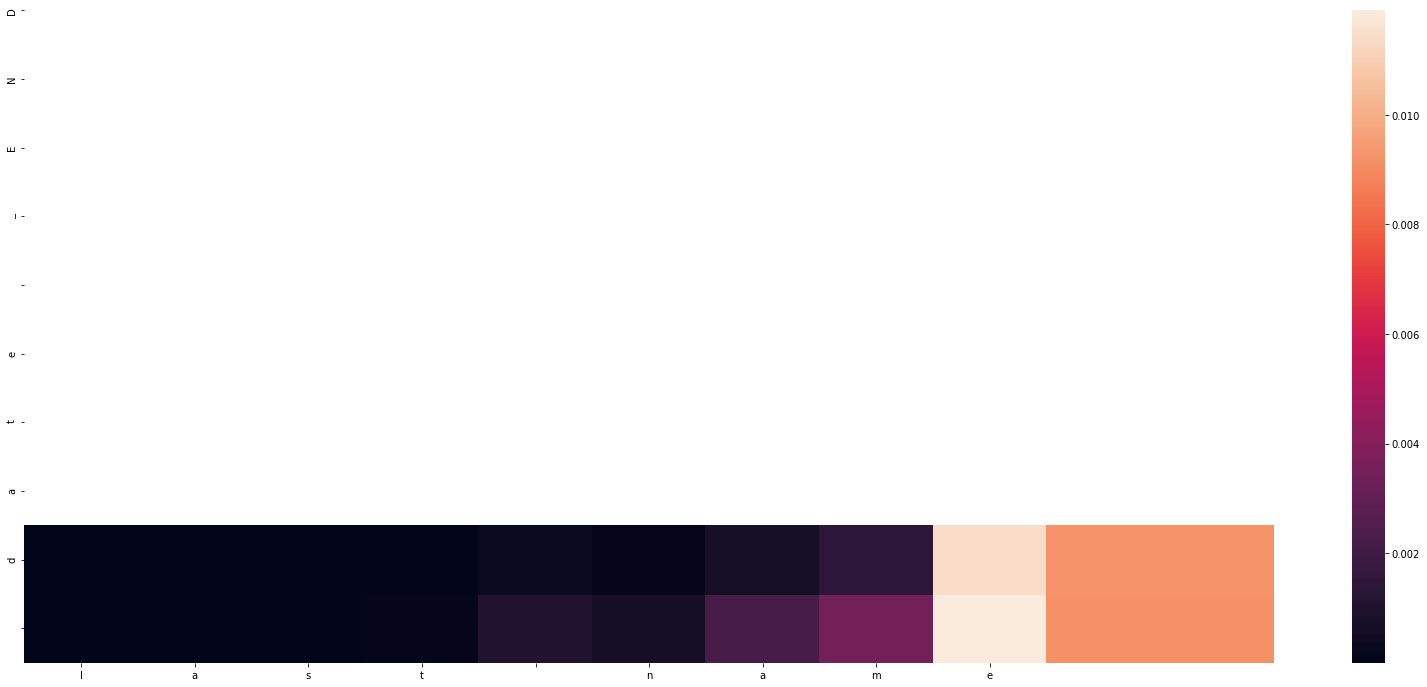

Decoded sentence:  date _END
-
Input sentence: social s ecurity number
GT sentence: START_ social security number _END


<Figure size 432x288 with 0 Axes>

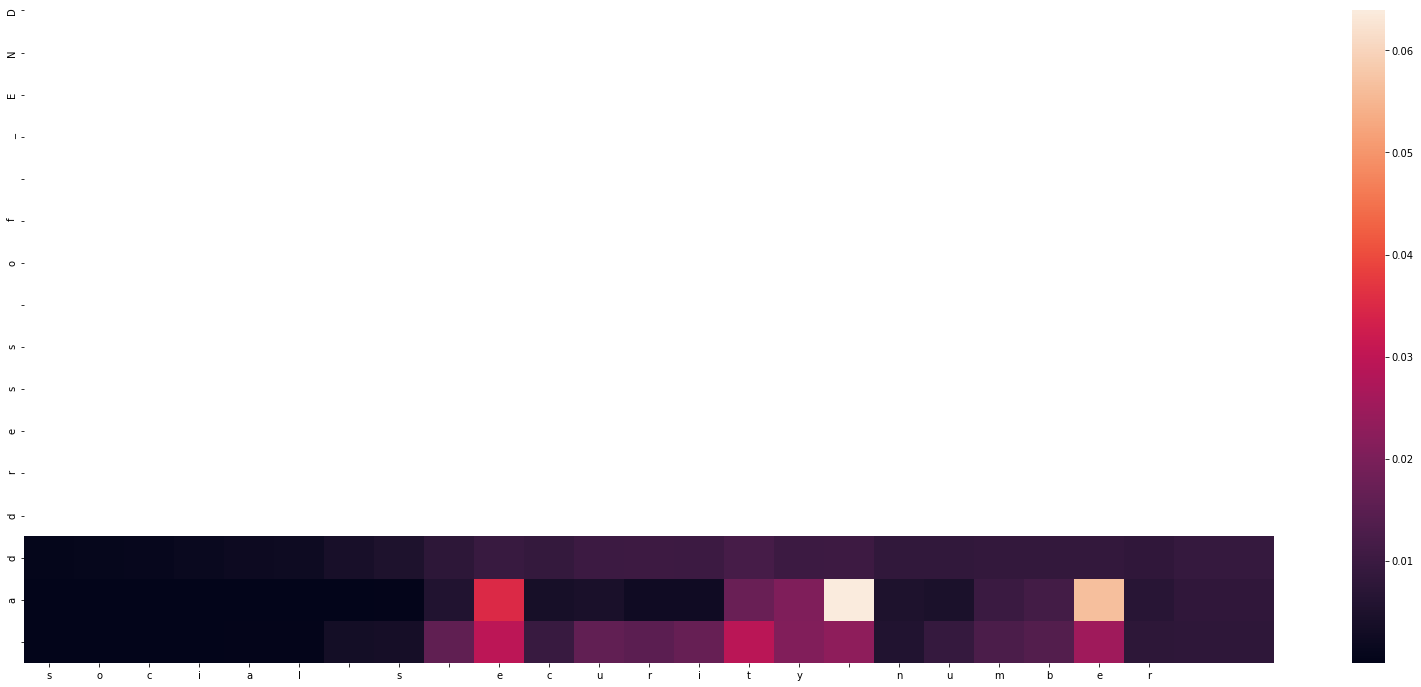

Decoded sentence:  address of _END
-
Input sentence: birth date
GT sentence: START_ birth date _END


<Figure size 432x288 with 0 Axes>

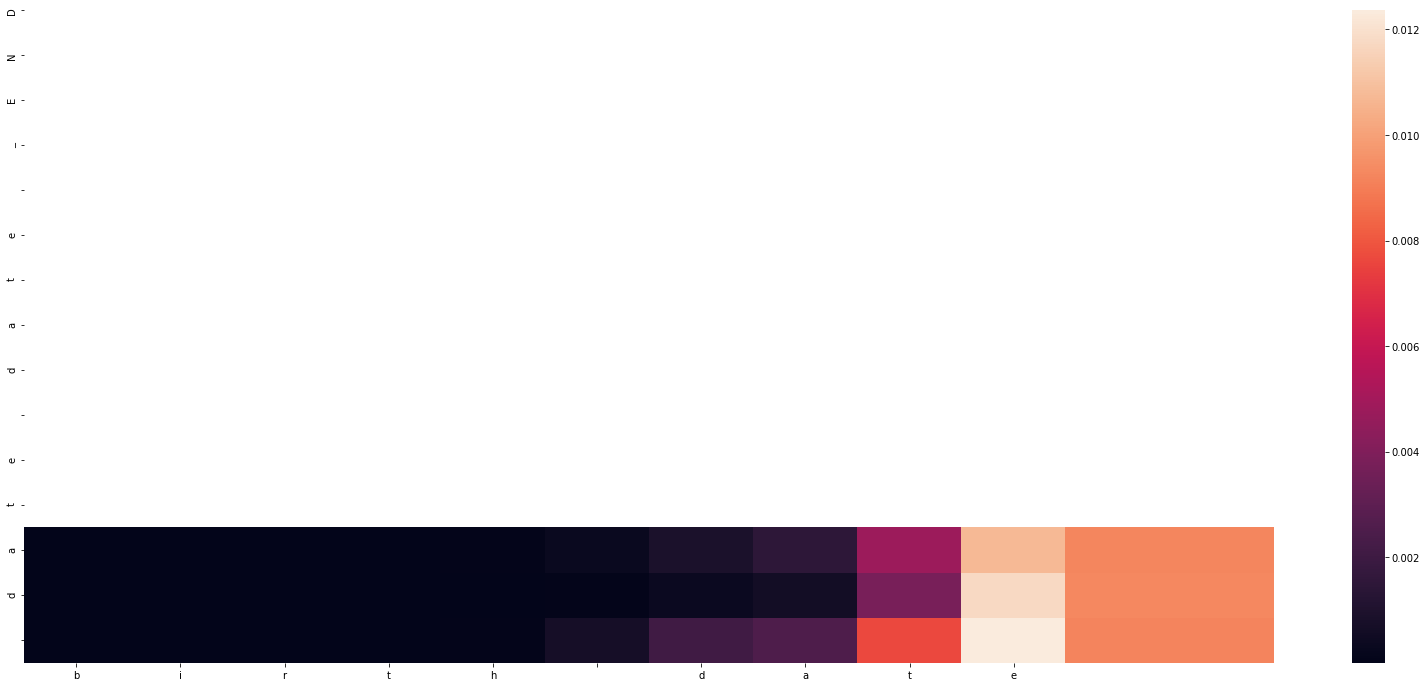

Decoded sentence:  date date _END
-
Input sentence: gender
GT sentence: START_ gender _END


<Figure size 432x288 with 0 Axes>

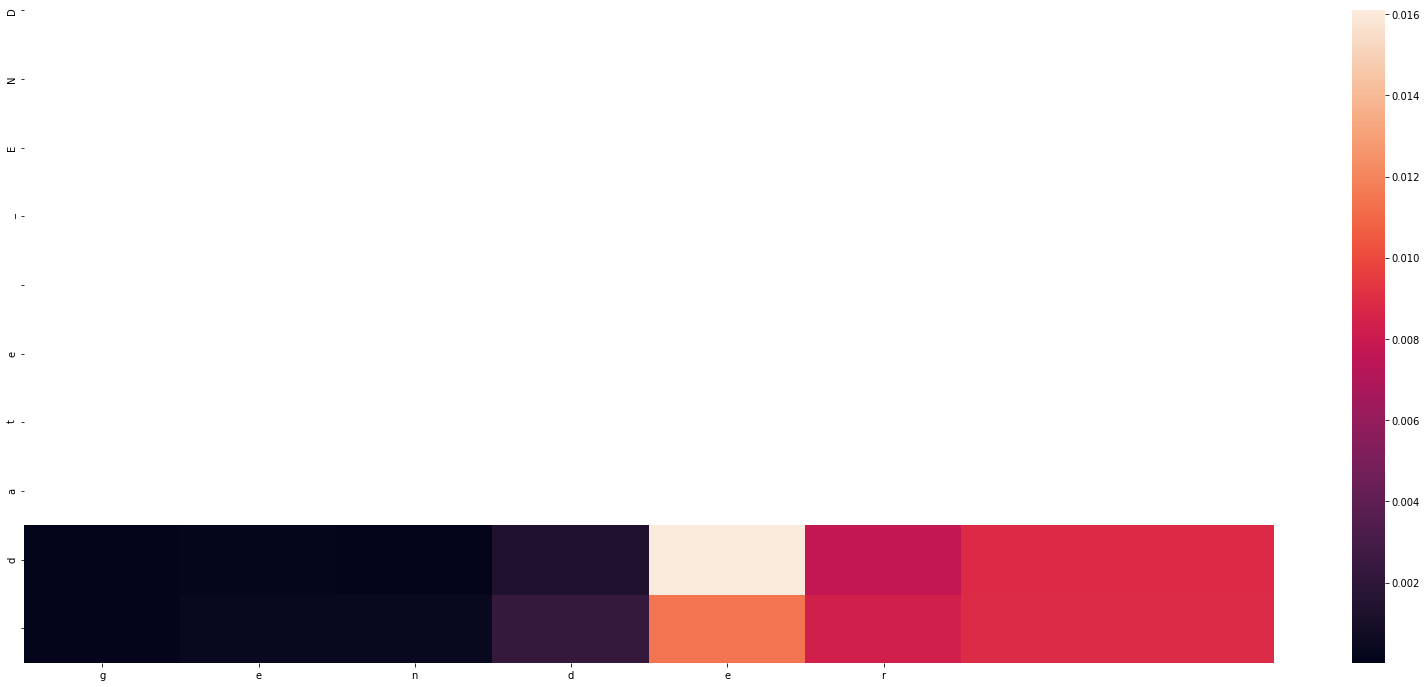

Decoded sentence:  date _END
-
Input sentence: language preference
GT sentence: START_ language preference _END


<Figure size 432x288 with 0 Axes>

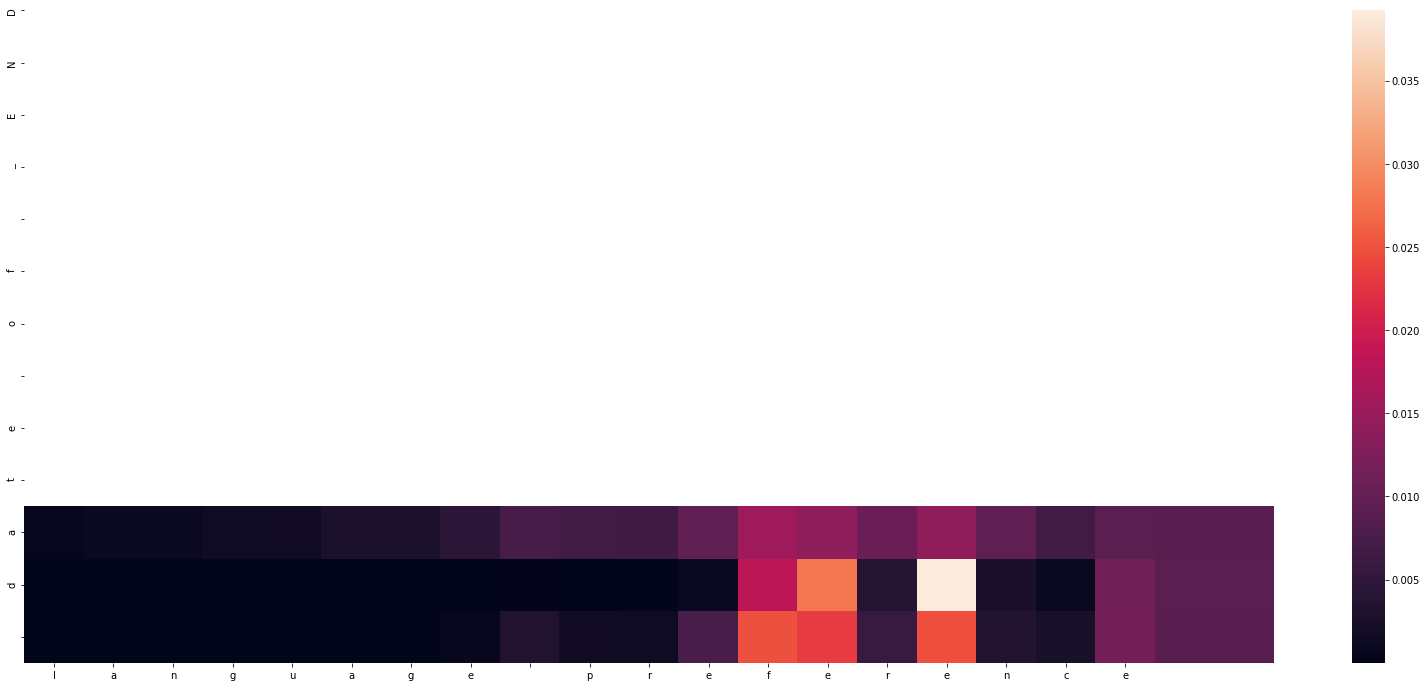

Decoded sentence:  date of _END
-
Input sentence: address line 
GT sentence: START_ address line  _END


<Figure size 432x288 with 0 Axes>

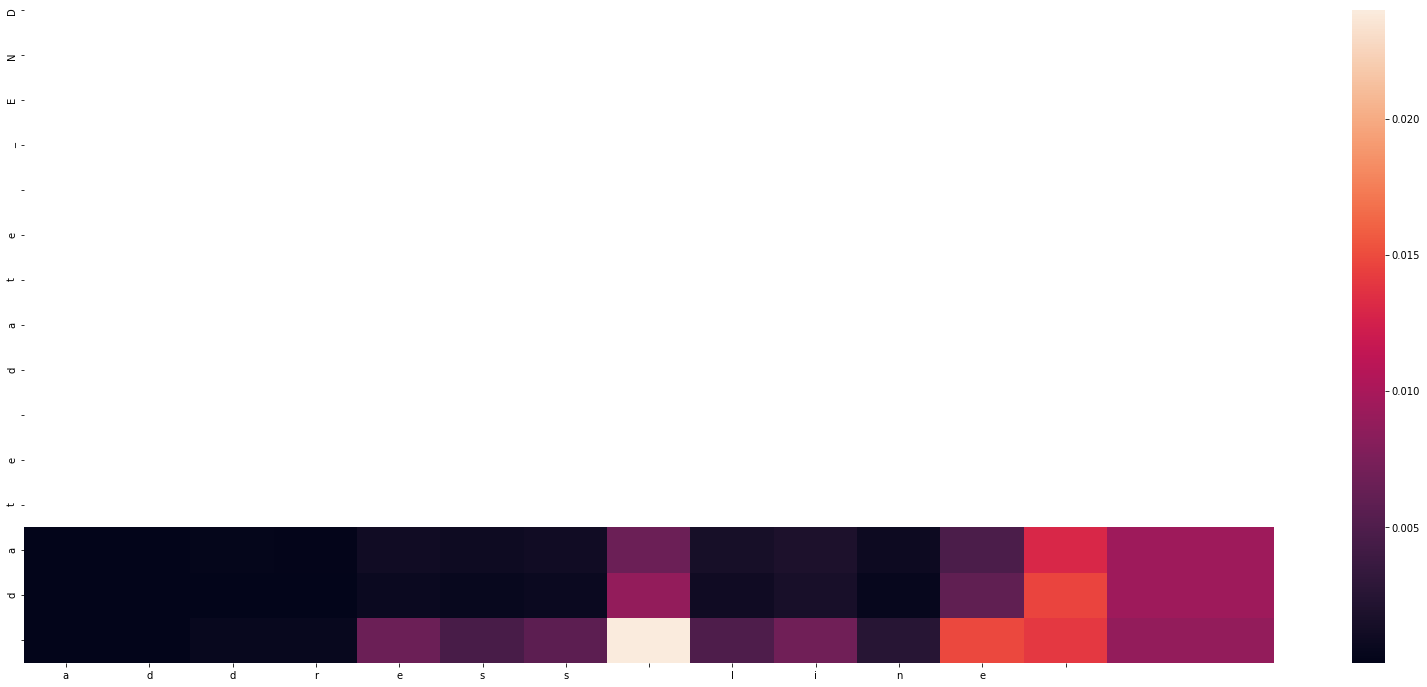

Decoded sentence:  date date _END
-
Input sentence: gw 
GT sentence: START_ city _END


<Figure size 432x288 with 0 Axes>

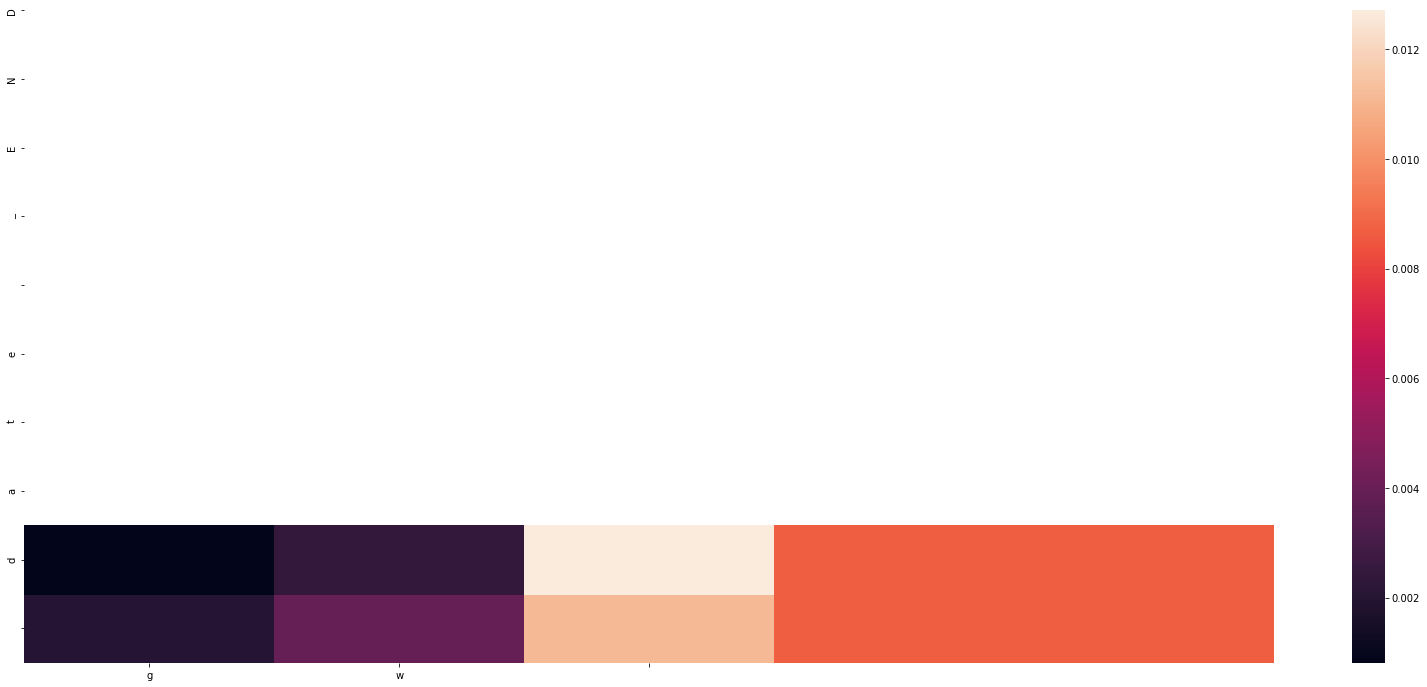

Decoded sentence:  date _END
-
Input sentence: statefprmince 
GT sentence: START_ stateprovince _END


<Figure size 432x288 with 0 Axes>

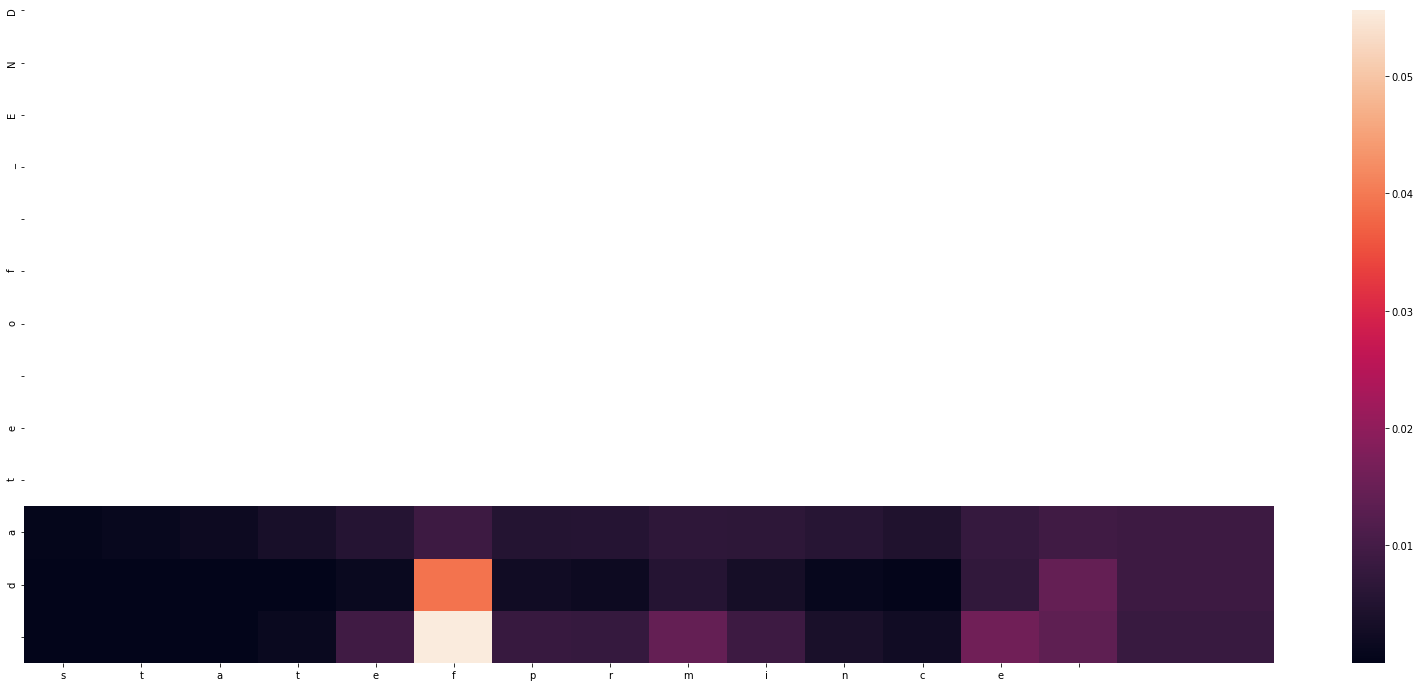

Decoded sentence:  date of _END
-
Input sentence: postal code
GT sentence: START_ postal code _END


<Figure size 432x288 with 0 Axes>

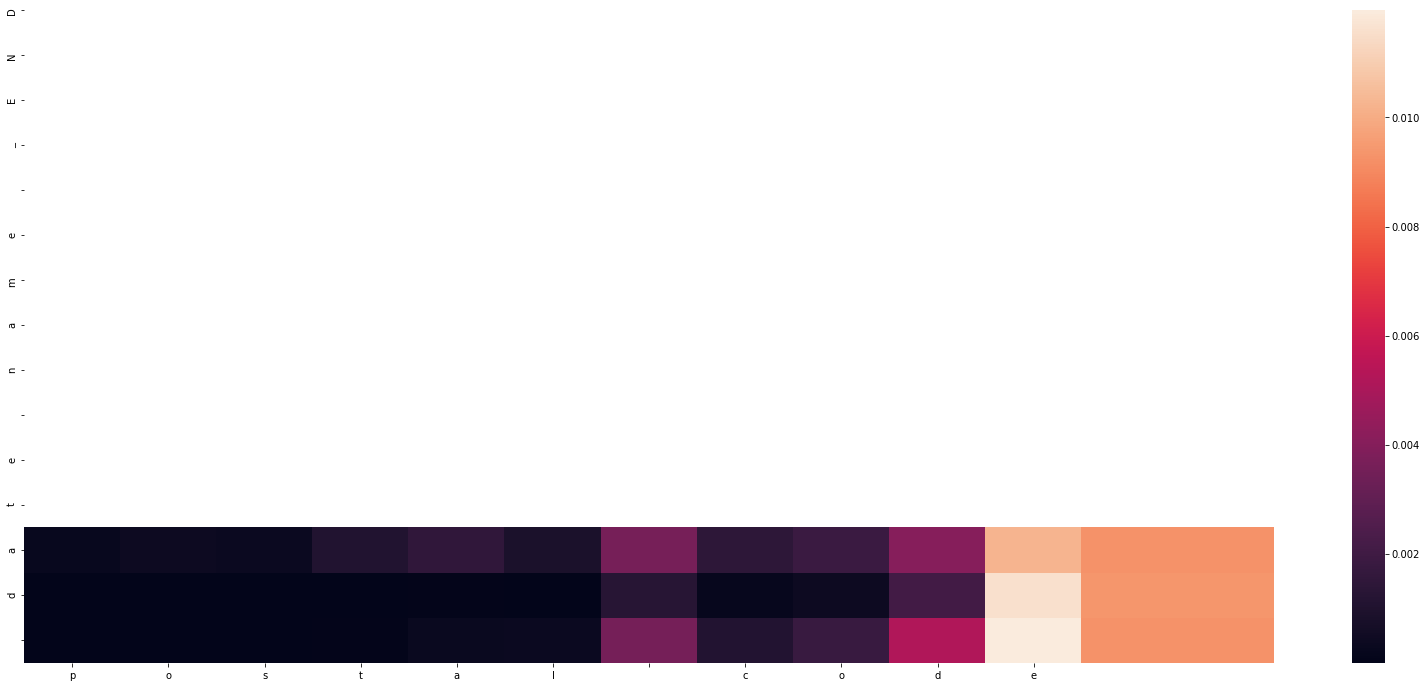

Decoded sentence:  date name _END
-
Input sentence: comtry
GT sentence: START_ country _END


<Figure size 432x288 with 0 Axes>

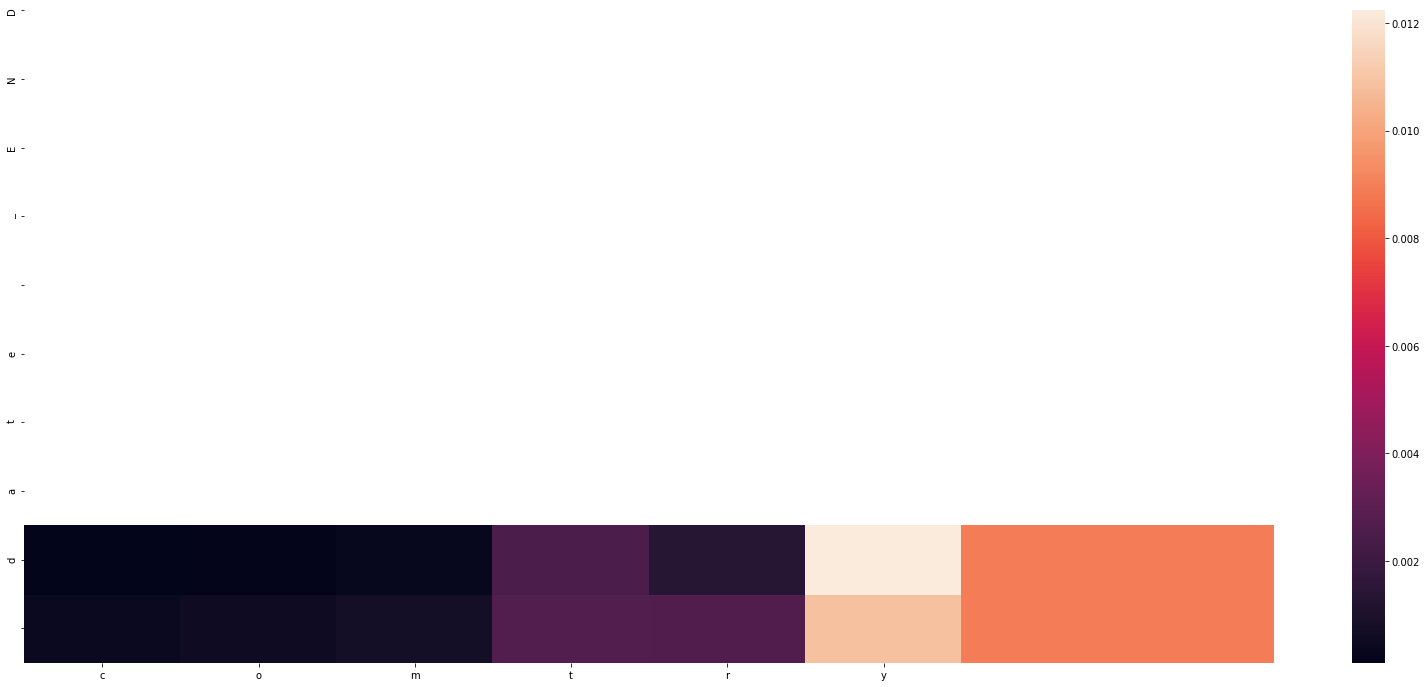

Decoded sentence:  date _END
-
Input sentence: best phone number to be reached during the day
GT sentence: START_ best phone number to be reached during the day _END


<Figure size 432x288 with 0 Axes>

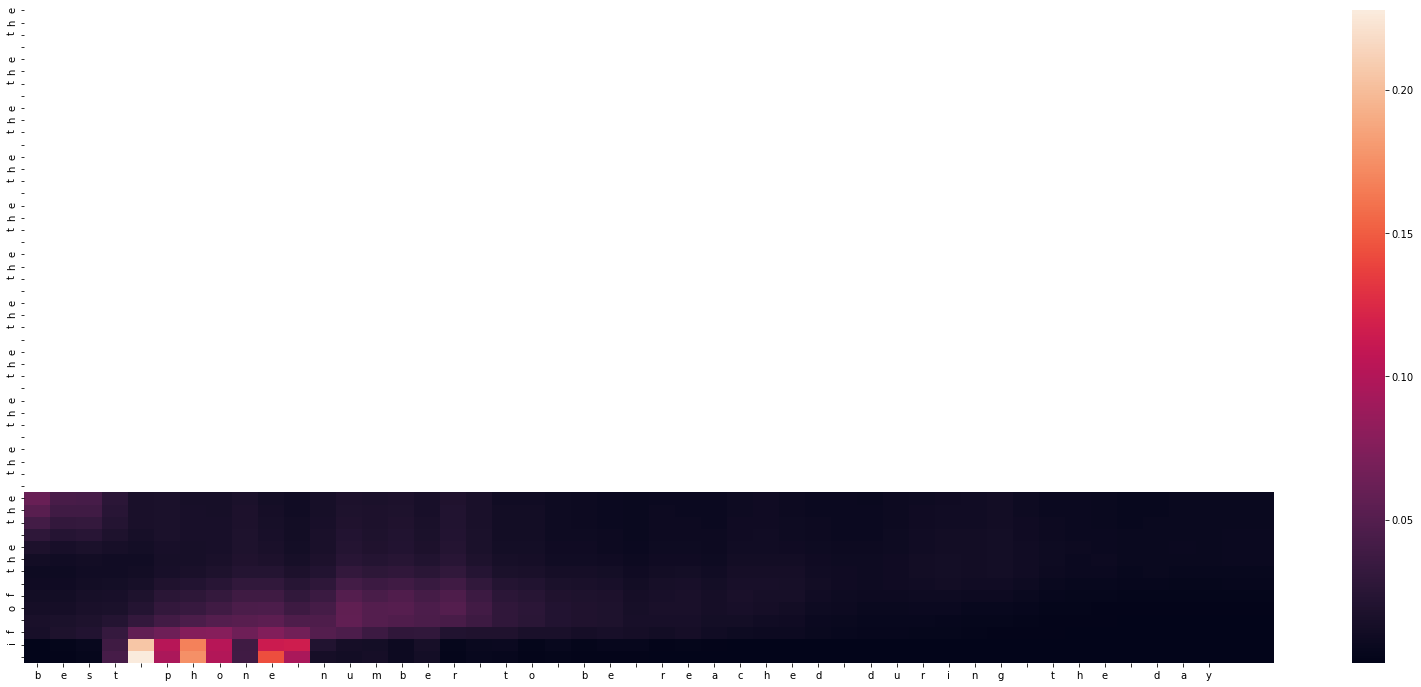

Decoded sentence:  if of the the the the the the the the the the the the
-
Input sentence: email address
GT sentence: START_ email address _END


<Figure size 432x288 with 0 Axes>

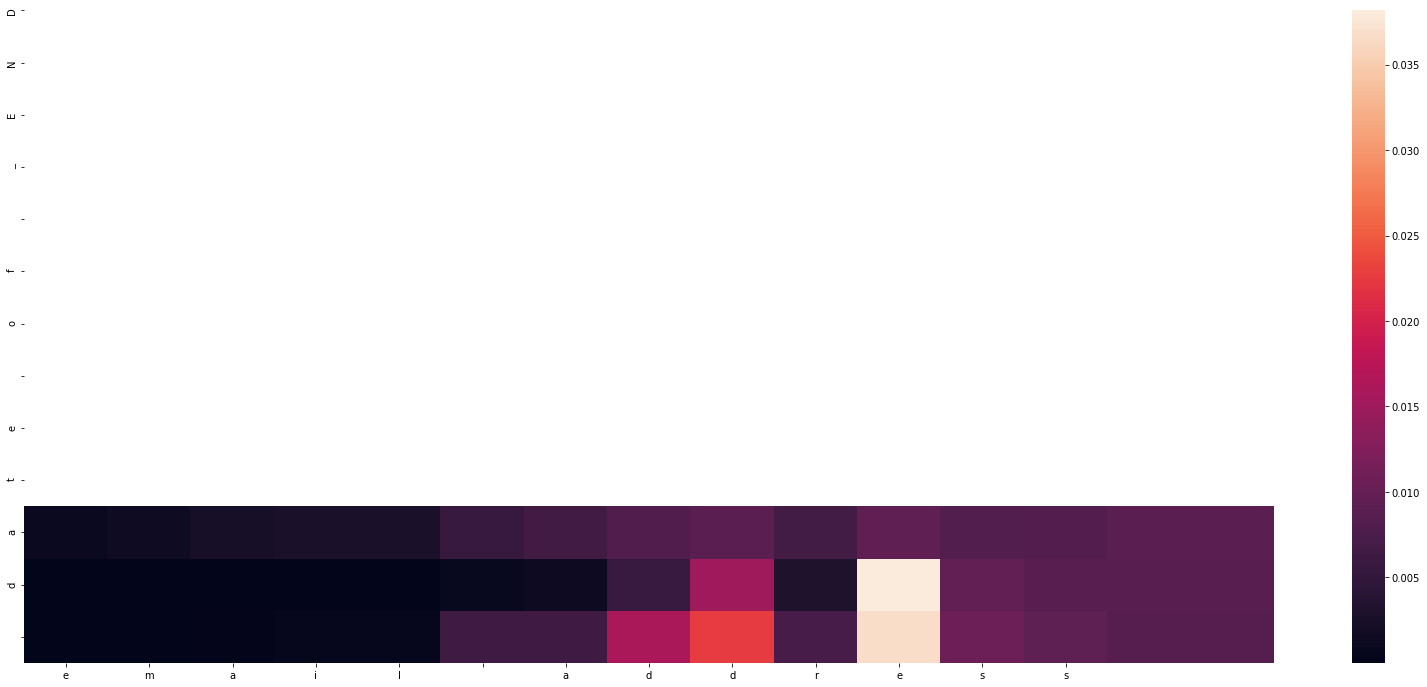

Decoded sentence:  date of _END
-
Input sentence: 
GT sentence: START_ page  of  _END


<Figure size 432x288 with 0 Axes>

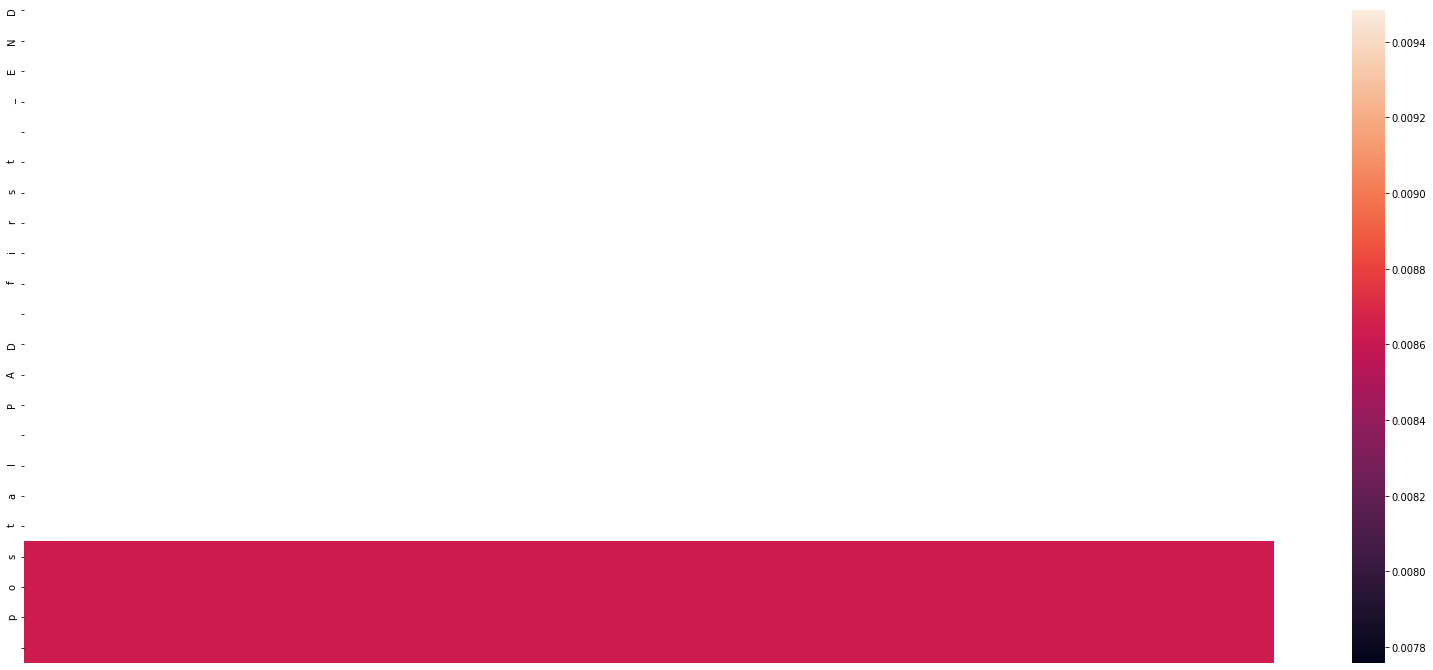

Decoded sentence:  postal PAD first _END
-
Input sentence: f” radiology
GT sentence: START_ radiology _END


<Figure size 432x288 with 0 Axes>

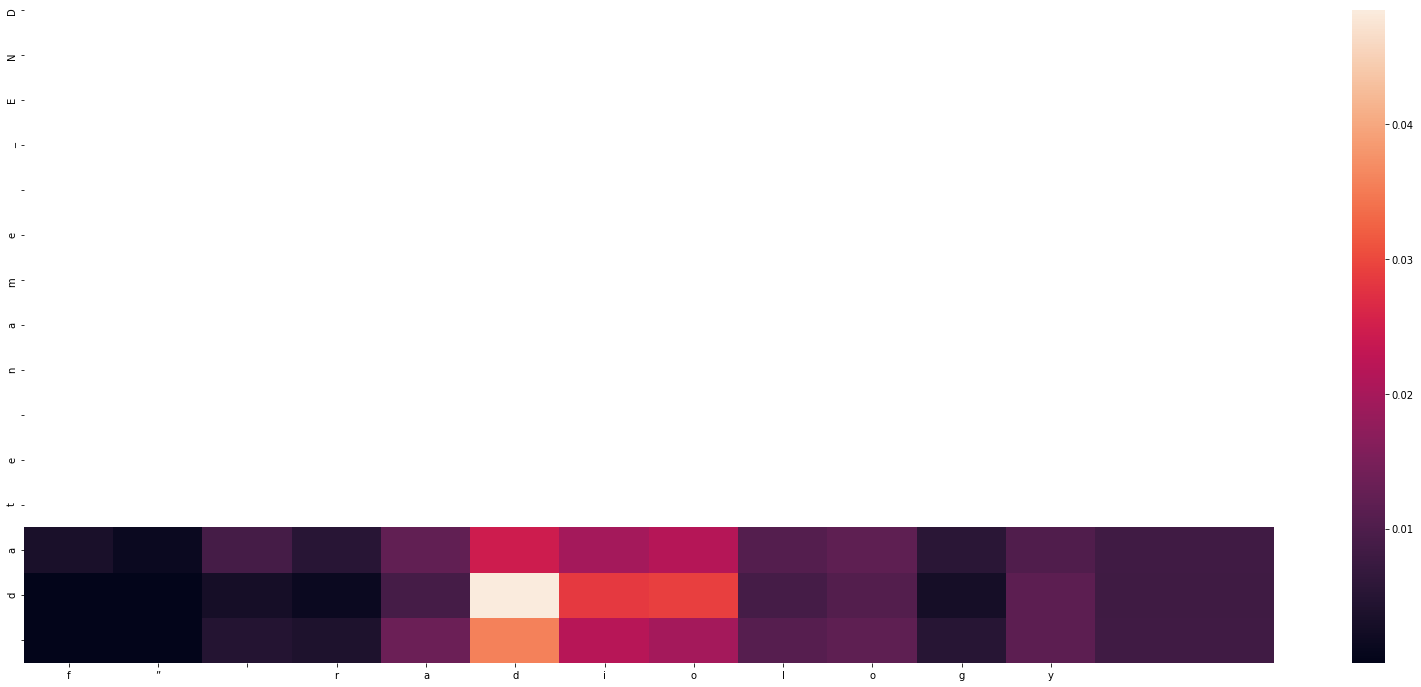

Decoded sentence:  date name _END
-
Input sentence:  report
GT sentence: START_ report _END


<Figure size 432x288 with 0 Axes>

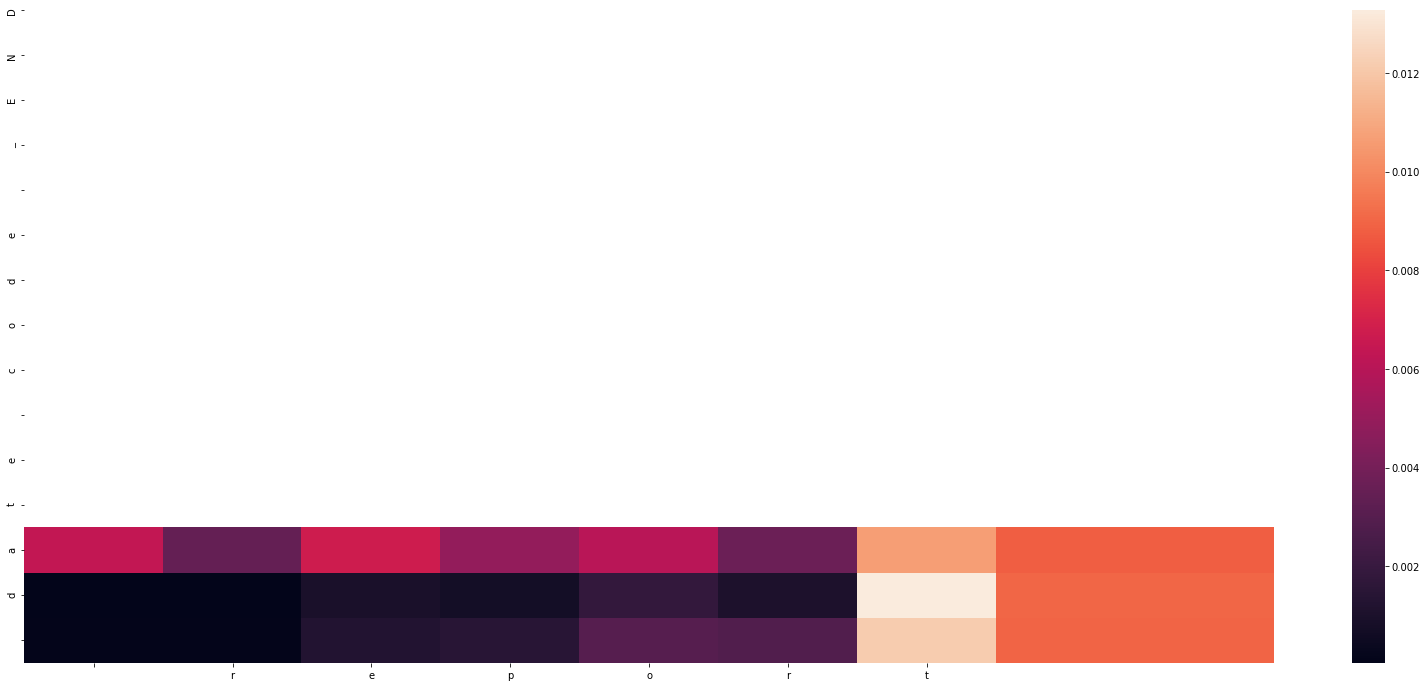

Decoded sentence:  date code _END
-
Input sentence: 
GT sentence: START_ wwwraysnet _END


<Figure size 432x288 with 0 Axes>

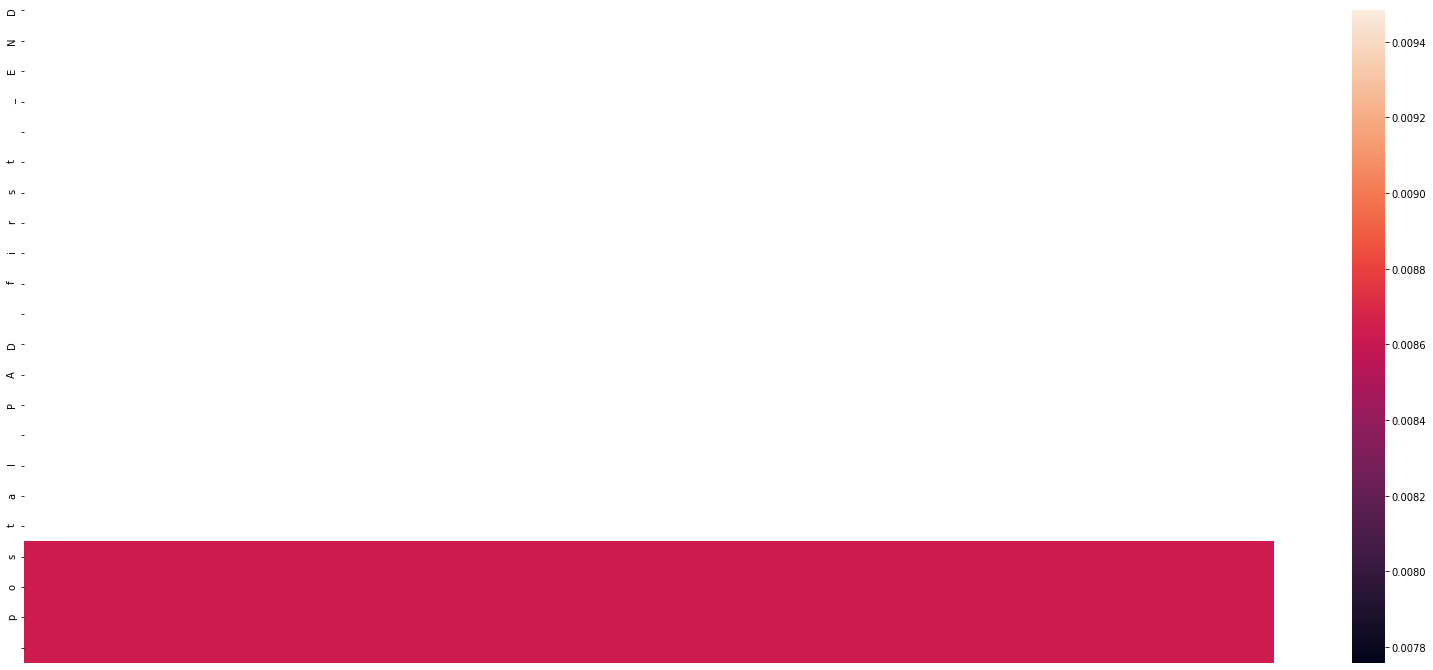

Decoded sentence:  postal PAD first _END
-
Input sentence: 
GT sentence: START_ patient mrn accession no ref physician _END


<Figure size 432x288 with 0 Axes>

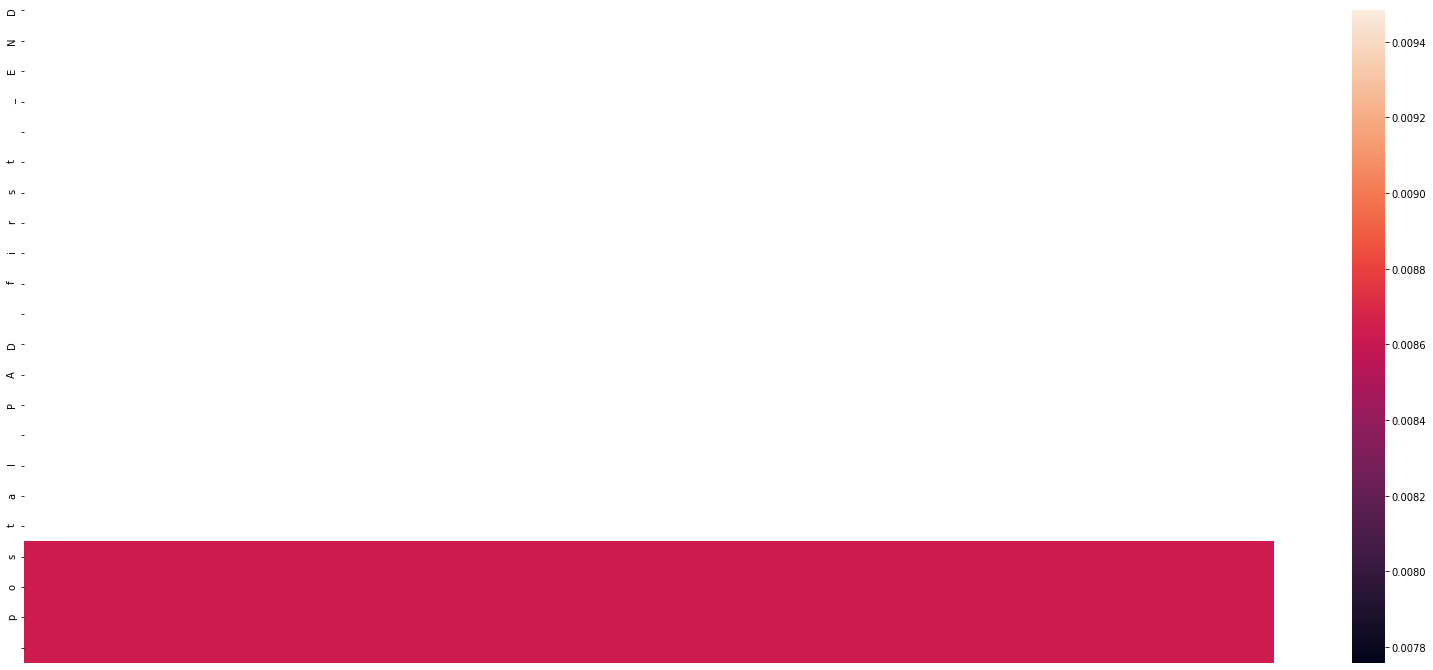

Decoded sentence:  postal PAD first _END
-
Input sentence: unknown
GT sentence: START_ unknown _END


<Figure size 432x288 with 0 Axes>

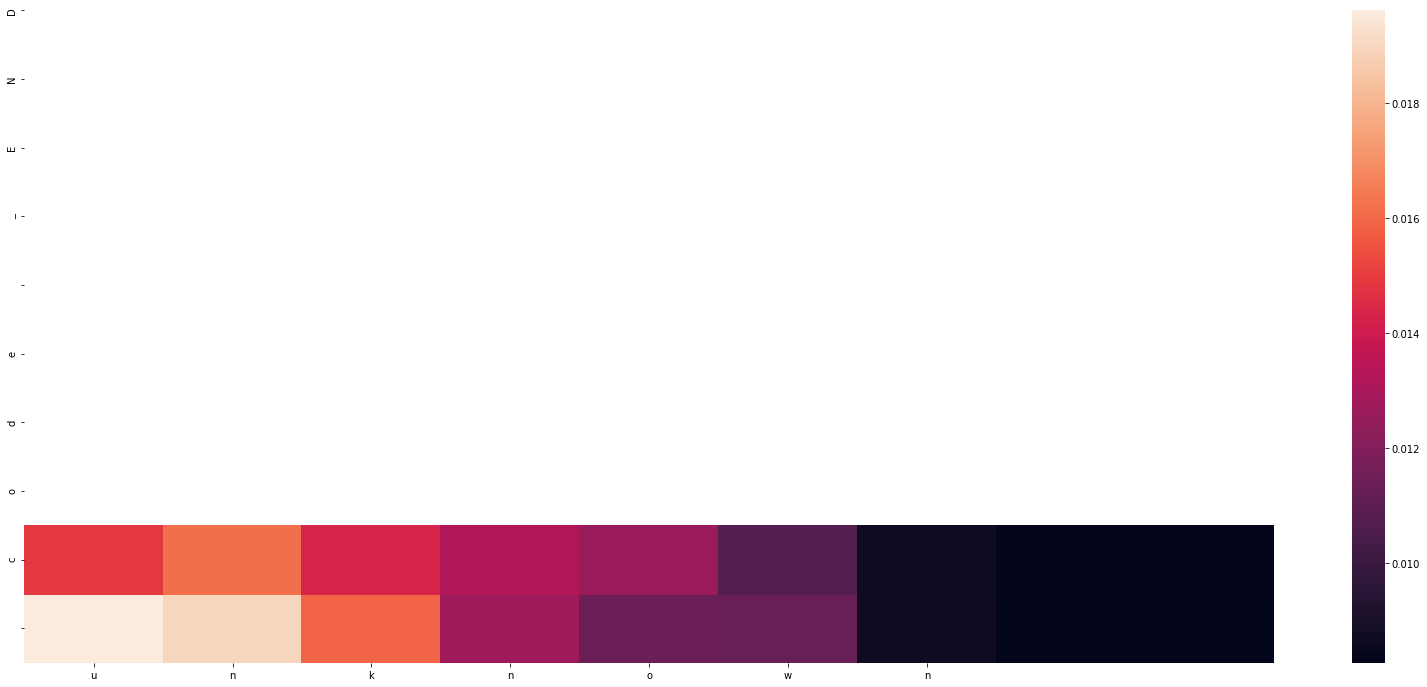

Decoded sentence:  code _END
-
Input sentence: 
GT sentence: START_ study  _END


<Figure size 432x288 with 0 Axes>

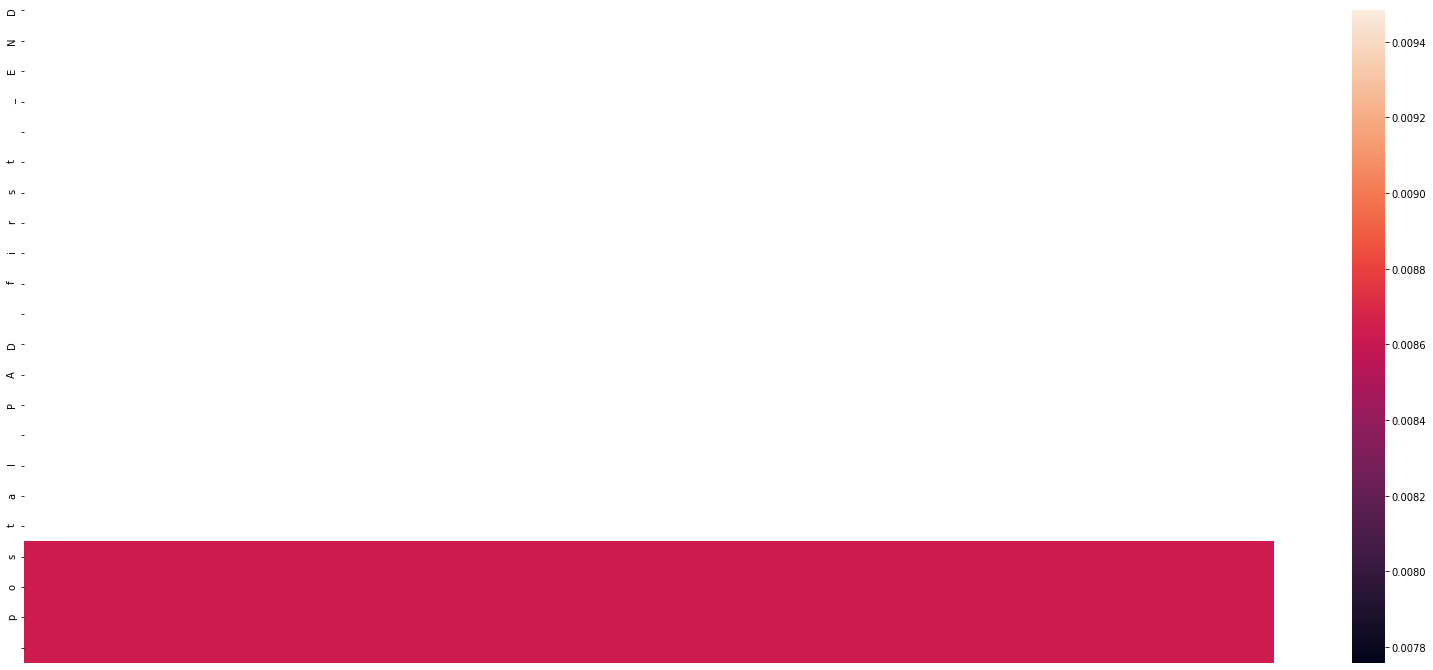

Decoded sentence:  postal PAD first _END
-
Input sentence: 
GT sentence: START_ study date _END


<Figure size 432x288 with 0 Axes>

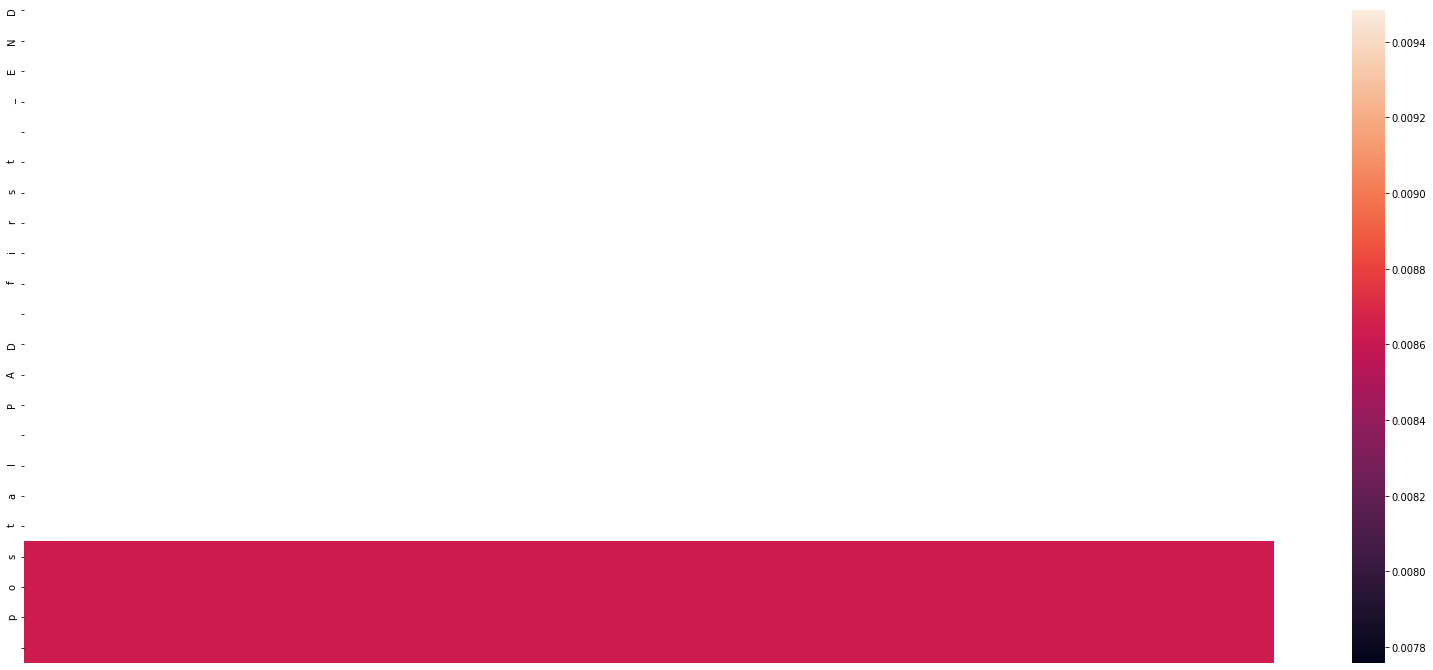

Decoded sentence:  postal PAD first _END
-
Input sentence: 
GT sentence: START_ hospital code   _END


<Figure size 432x288 with 0 Axes>

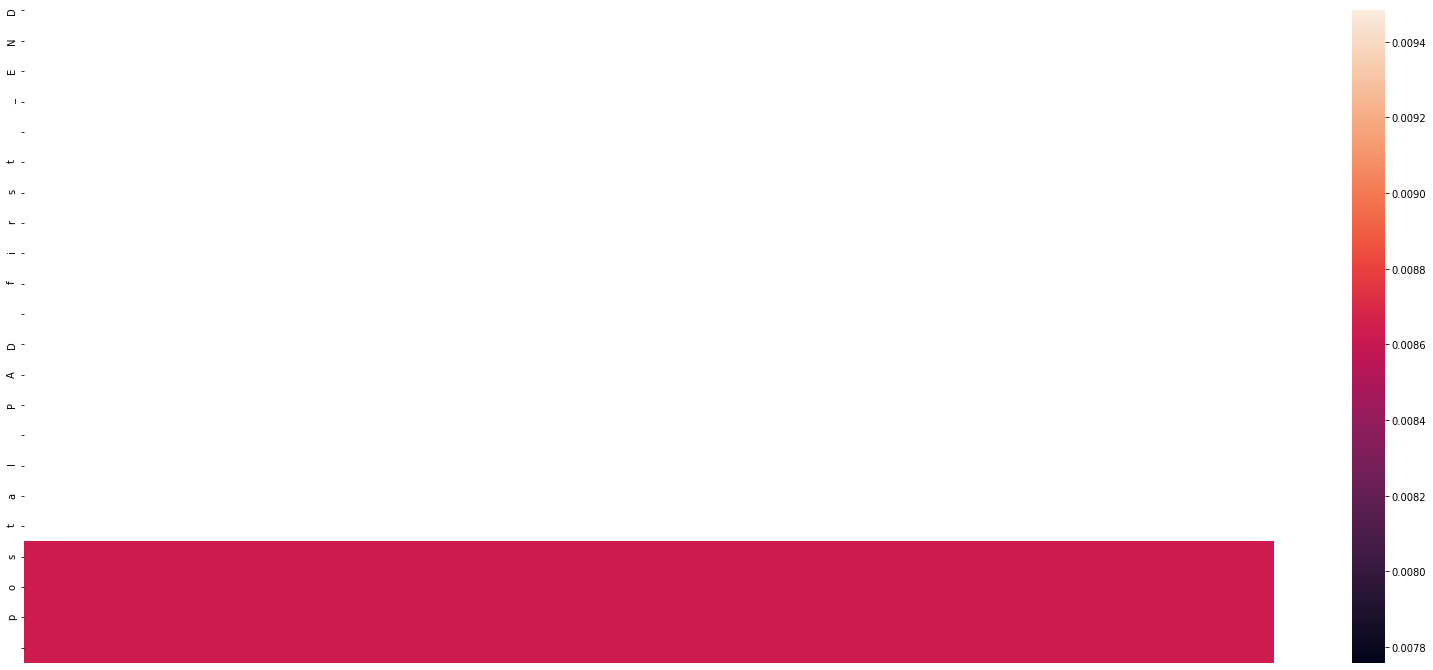

Decoded sentence:  postal PAD first _END
-
Input sentence: 
GT sentence: START_ dob _END


<Figure size 432x288 with 0 Axes>

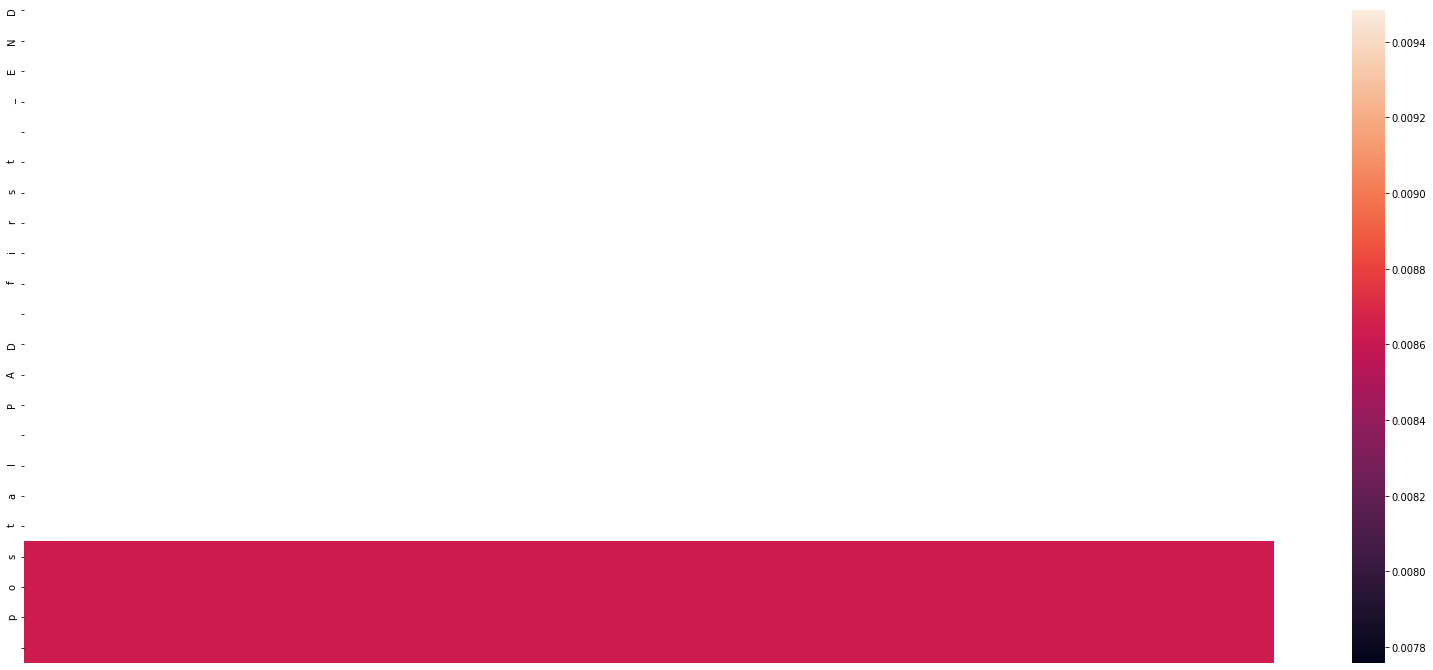

Decoded sentence:  postal PAD first _END
-
Input sentence: 
GT sentence: START_ tech notes v lt wrist  wc initial  dr wortman  xray wrist COMMA comp cr more view  uncol _END


<Figure size 432x288 with 0 Axes>

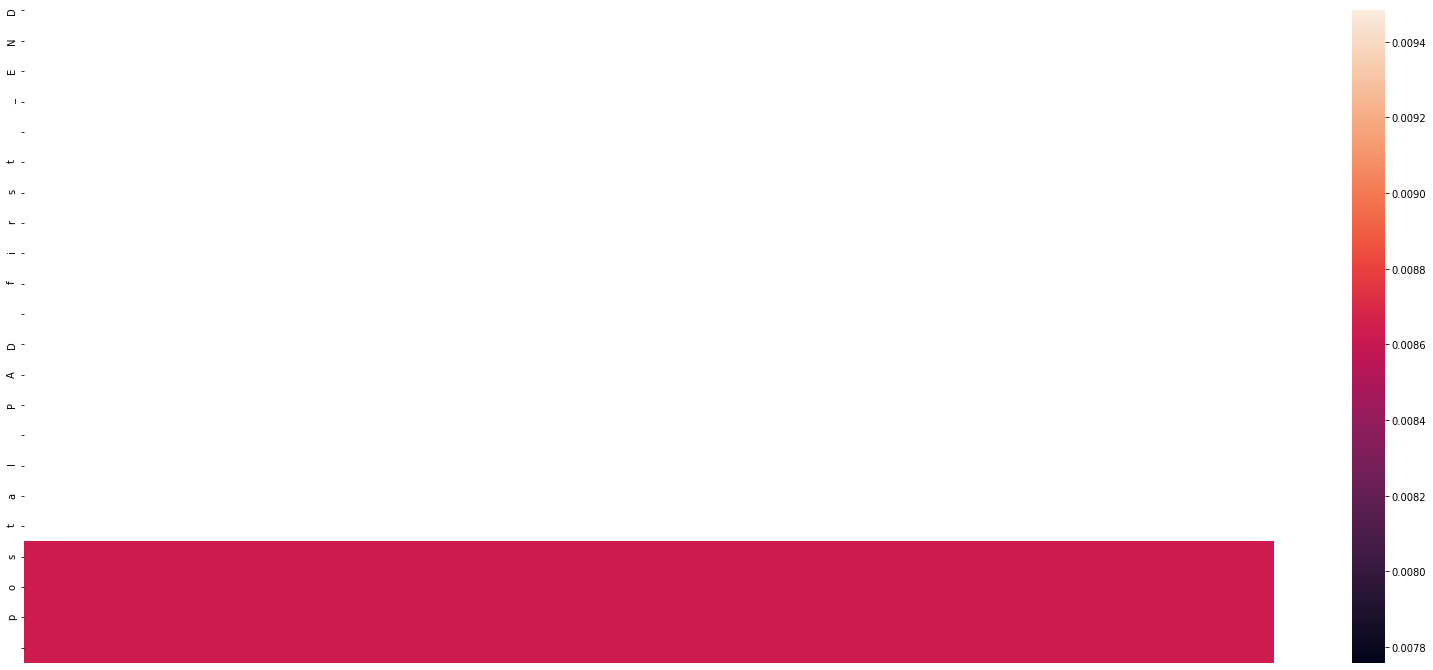

Decoded sentence:  postal PAD first _END
-
Input sentence: 
GT sentence: START_ f _END


<Figure size 432x288 with 0 Axes>

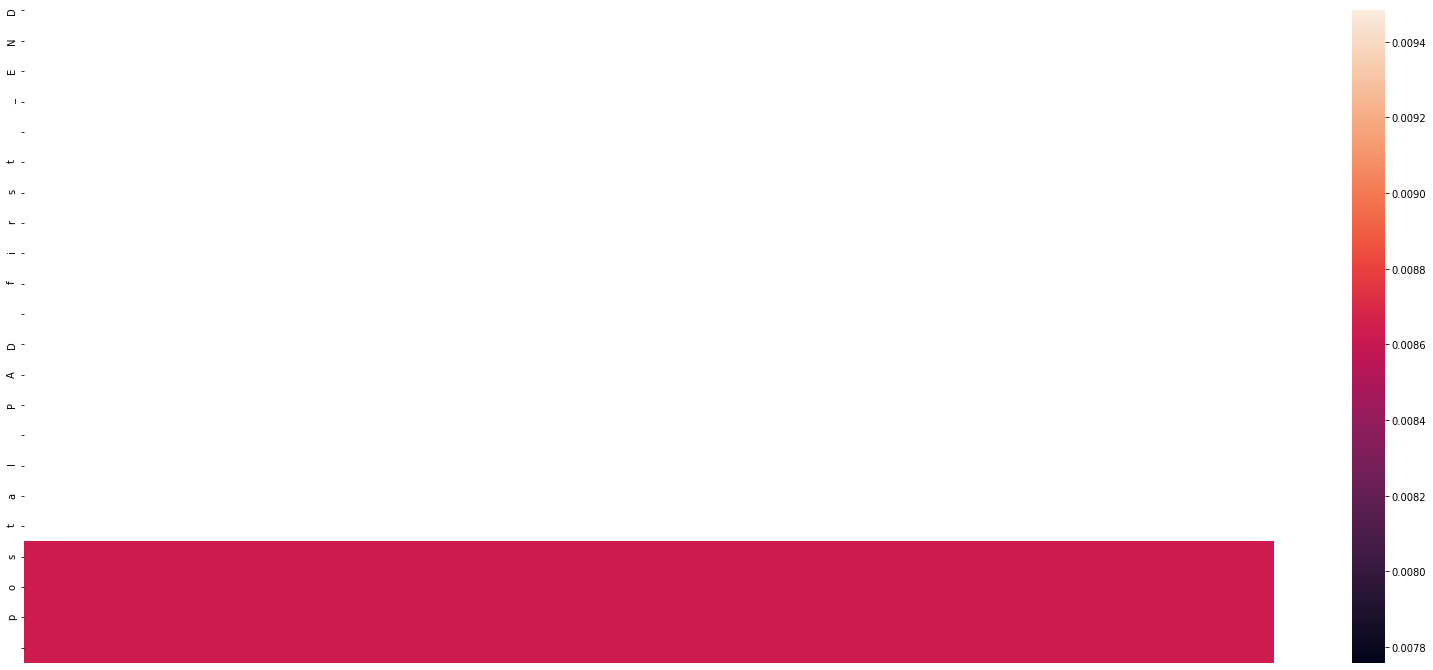

Decoded sentence:  postal PAD first _END
-
Input sentence: techiqn  vim left mist
GT sentence: START_ technique  views left wrist _END


<Figure size 432x288 with 0 Axes>

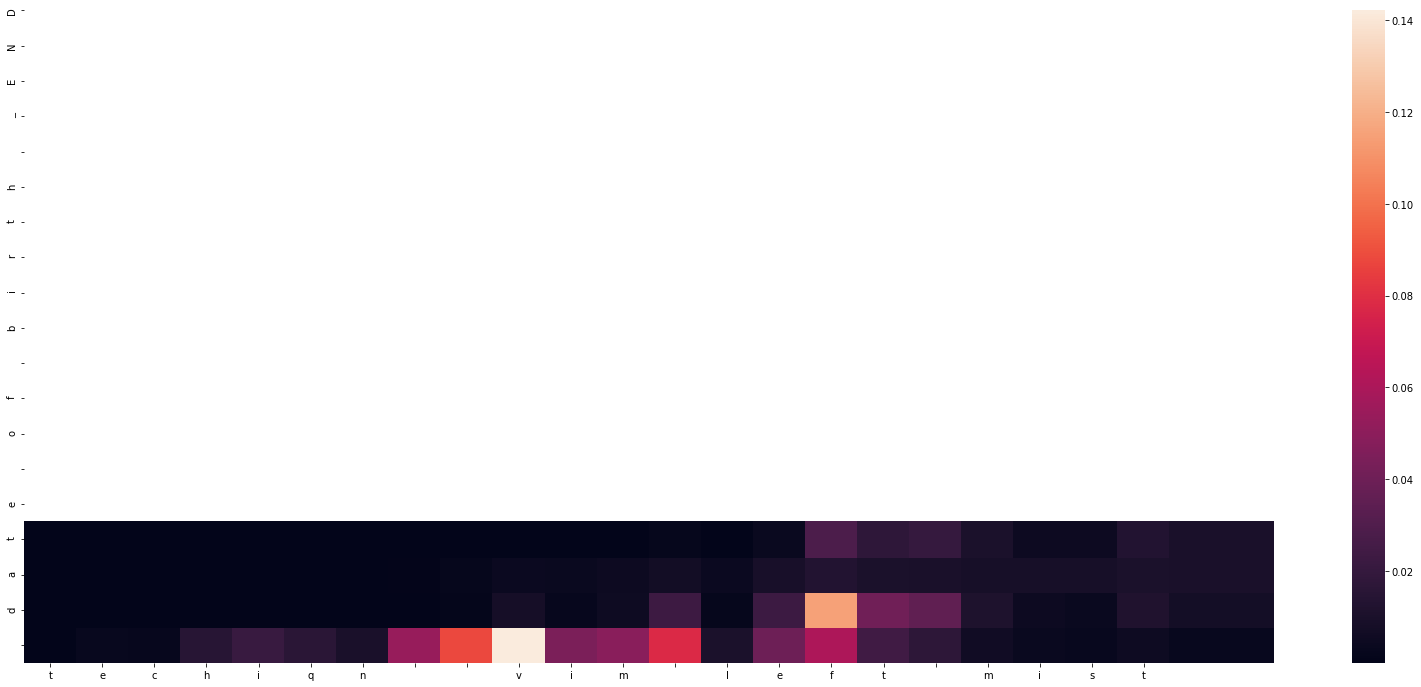

Decoded sentence:  date of birth _END
-
Input sentence: 
GT sentence: START_ cormarison none availabie _END


<Figure size 432x288 with 0 Axes>

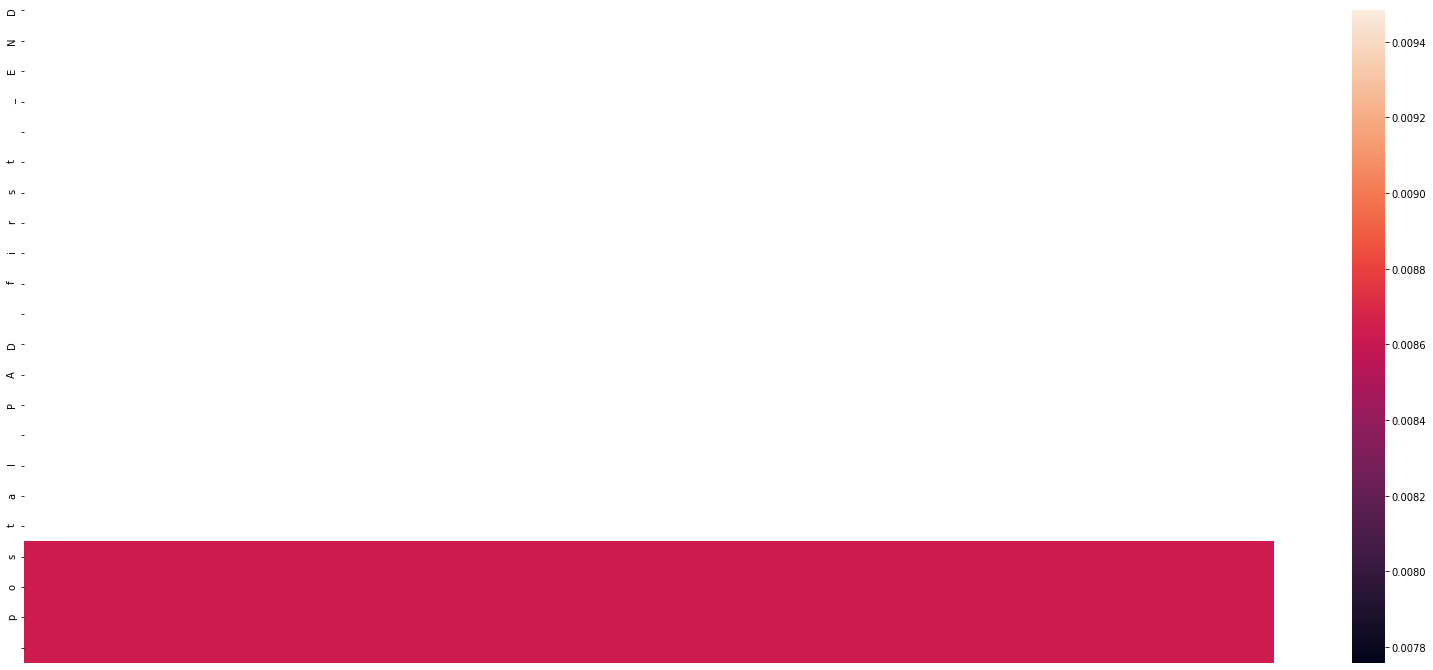

Decoded sentence:  postal PAD first _END
-
Input sentence: 
GT sentence: START_ comparison none available _END


<Figure size 432x288 with 0 Axes>

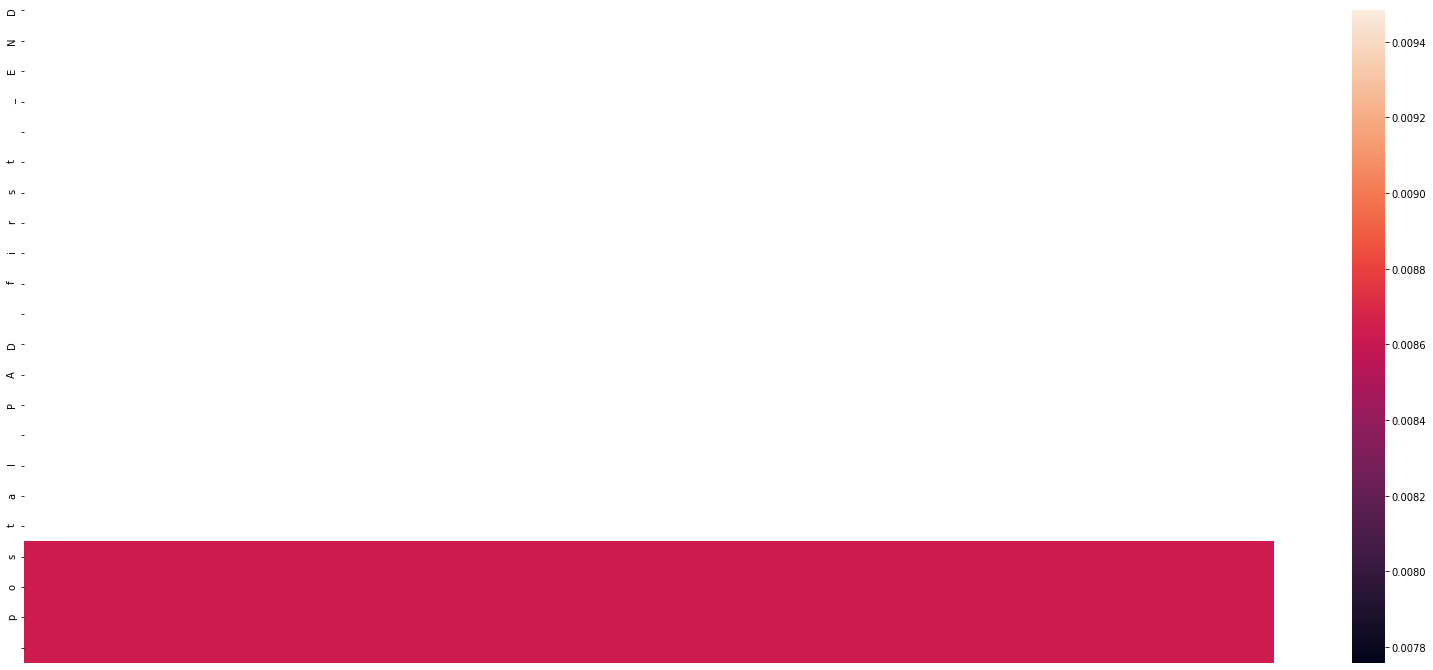

Decoded sentence:  postal PAD first _END
-
Input sentence: findings
GT sentence: START_ findings _END


<Figure size 432x288 with 0 Axes>

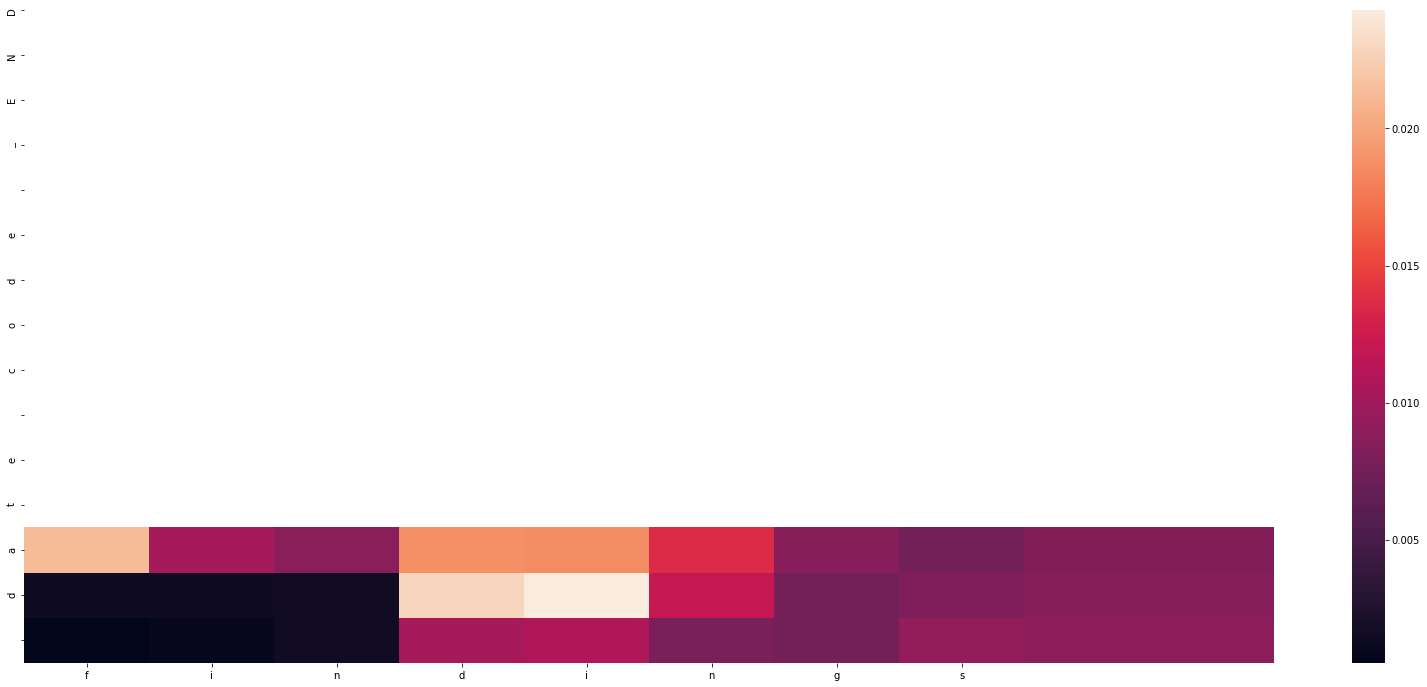

Decoded sentence:  date code _END
-
Input sentence: awmmossiﬁcdunﬁyuencﬁdalbmdmcﬁoﬂ
GT sentence: START_ a wellcorticated ossific density seen distal to the ulnar styloid _END


<Figure size 432x288 with 0 Axes>

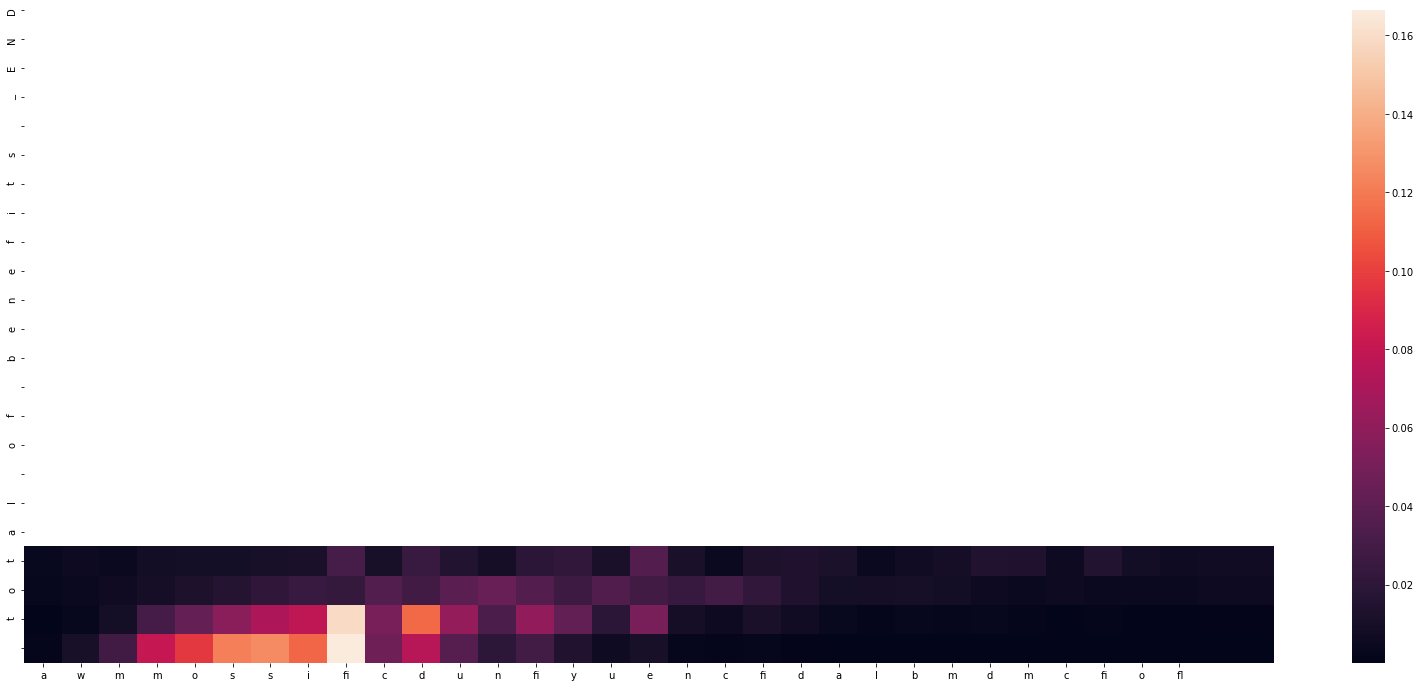

Decoded sentence:  total of benefits _END
-
Input sentence: nofoaal abmmaﬁtyisseenhﬂn mountings
GT sentence: START_ no focal abnormality is seen in the standing soft tissues _END


<Figure size 432x288 with 0 Axes>

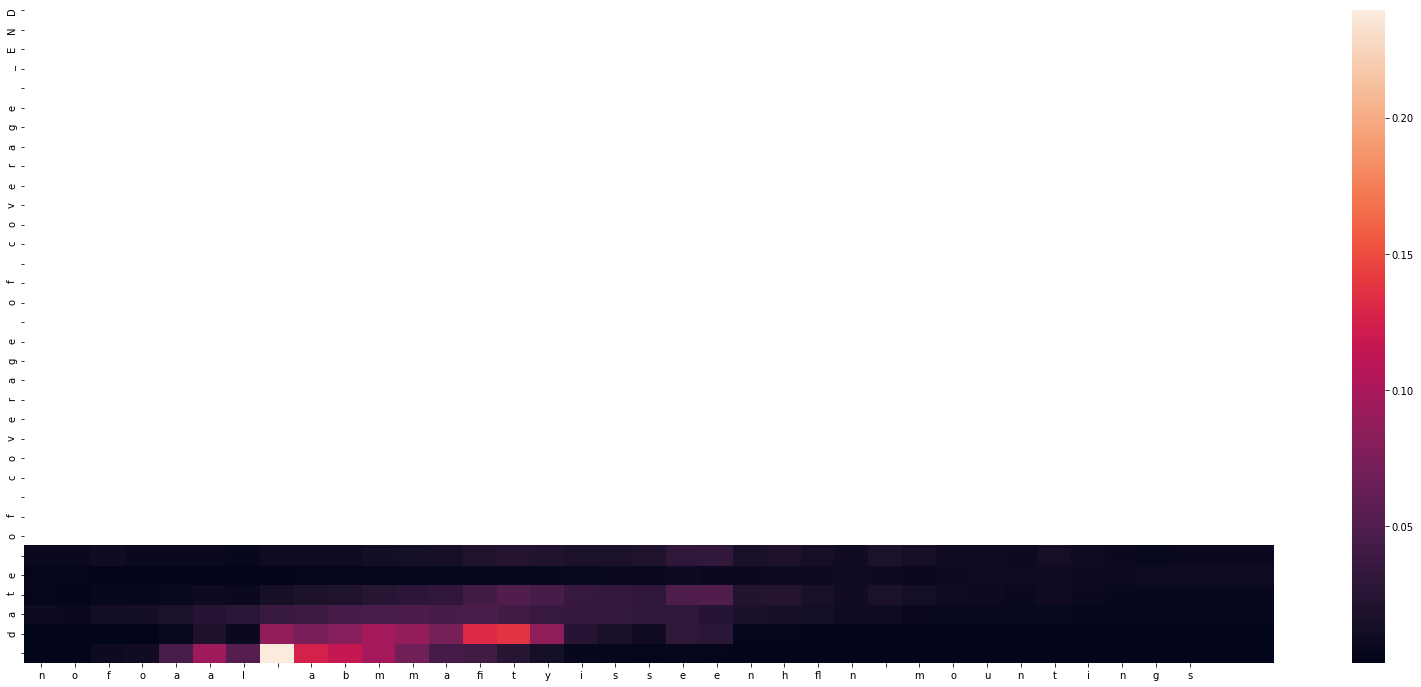

Decoded sentence:  date of coverage of coverage _END
-
Input sentence: impression
GT sentence: START_ impression _END


<Figure size 432x288 with 0 Axes>

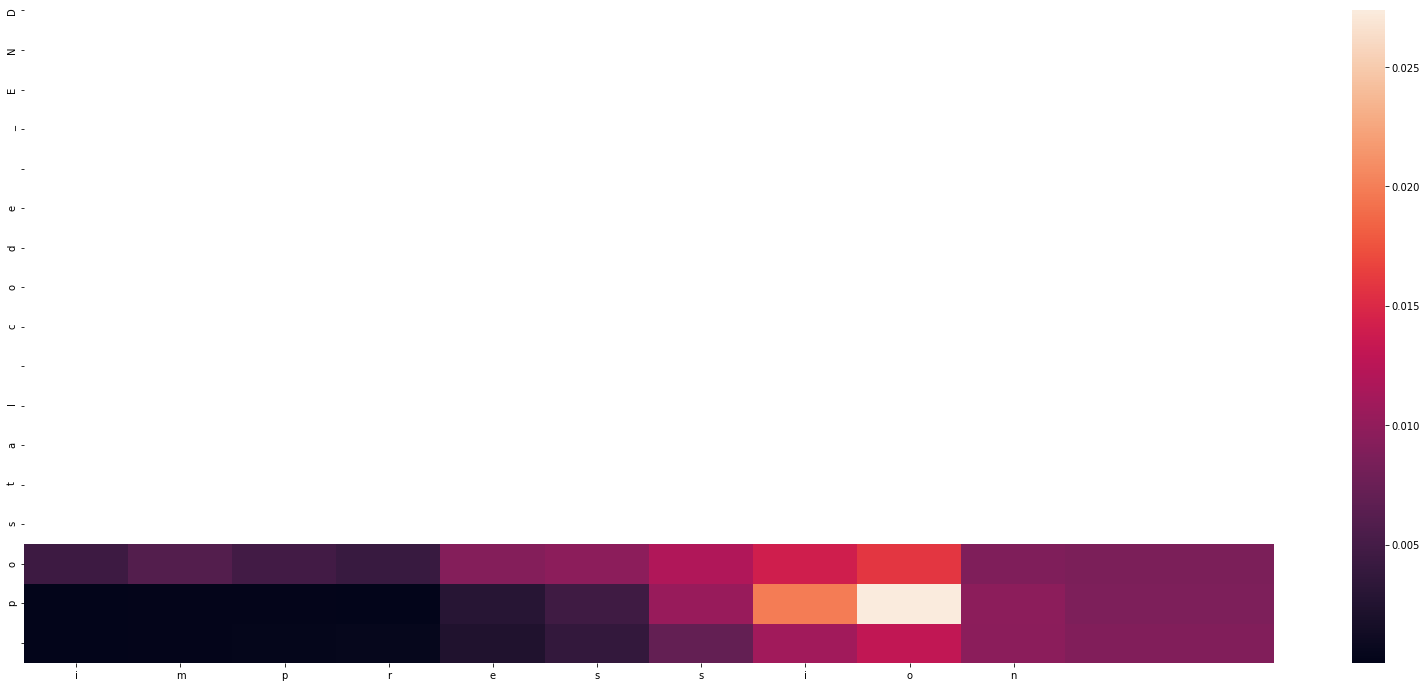

Decoded sentence:  postal code _END
-
Input sentence: agitationleaner
GT sentence: START_  wellcorticated ossific density distal to the ulnar styloid possible sequela of remote trauma or unfused ossification center _END


<Figure size 432x288 with 0 Axes>

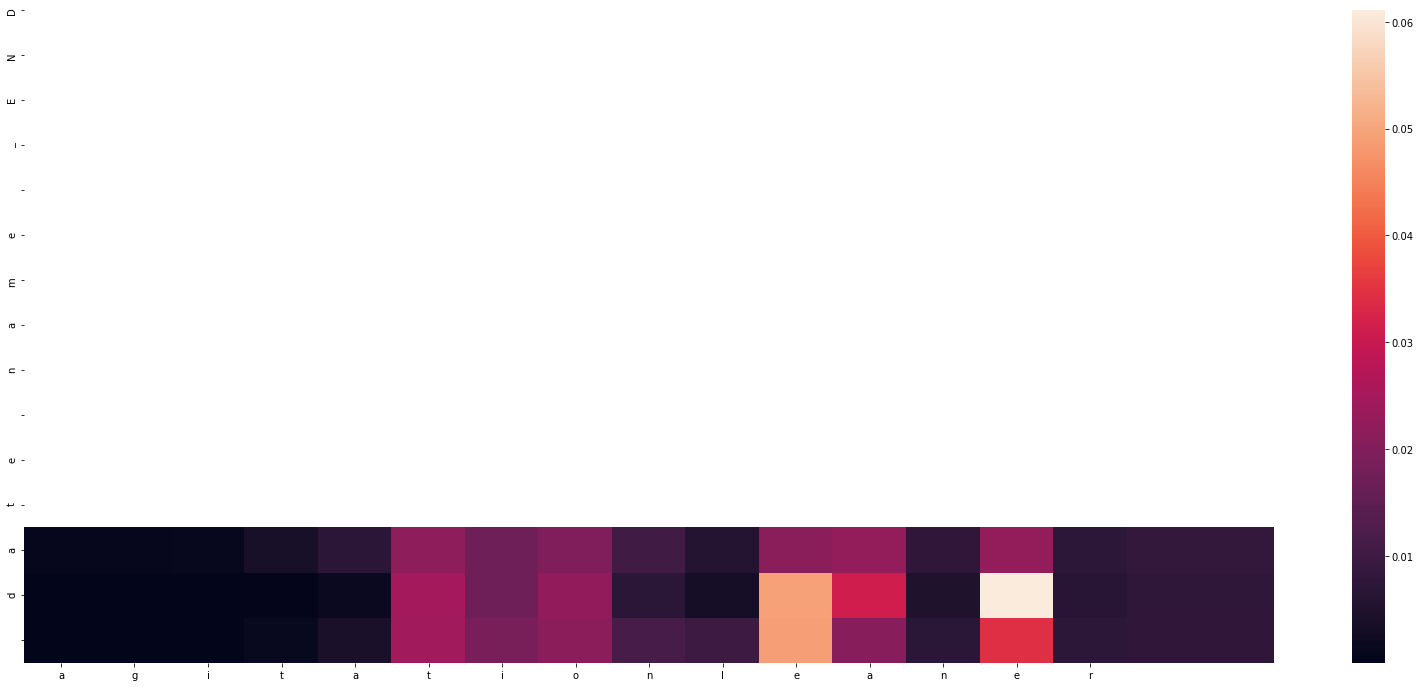

Decoded sentence:  date name _END
-
Input sentence:  noawemamliy harmed
GT sentence: START_  no acute osseous abnormality identified _END


<Figure size 432x288 with 0 Axes>

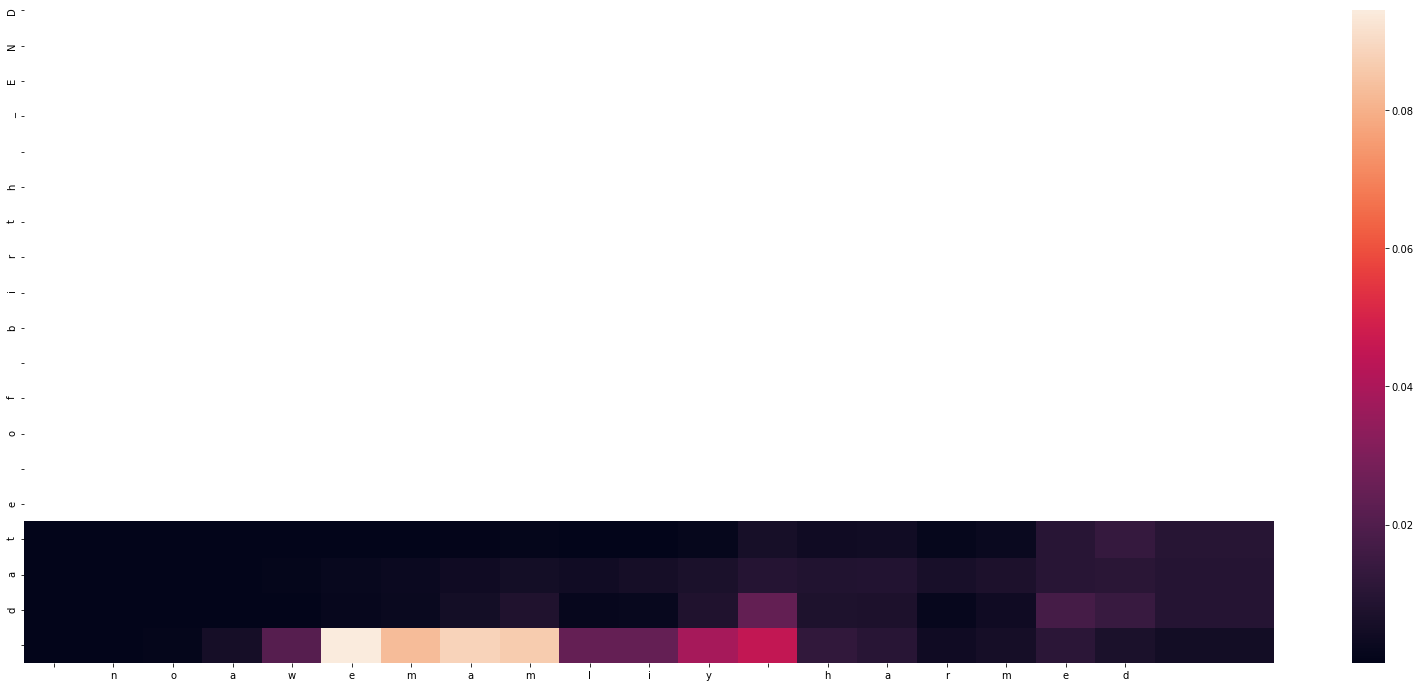

Decoded sentence:  date of birth _END
-
Input sentence: daytime phone
GT sentence: START_ daytime phone _END


<Figure size 432x288 with 0 Axes>

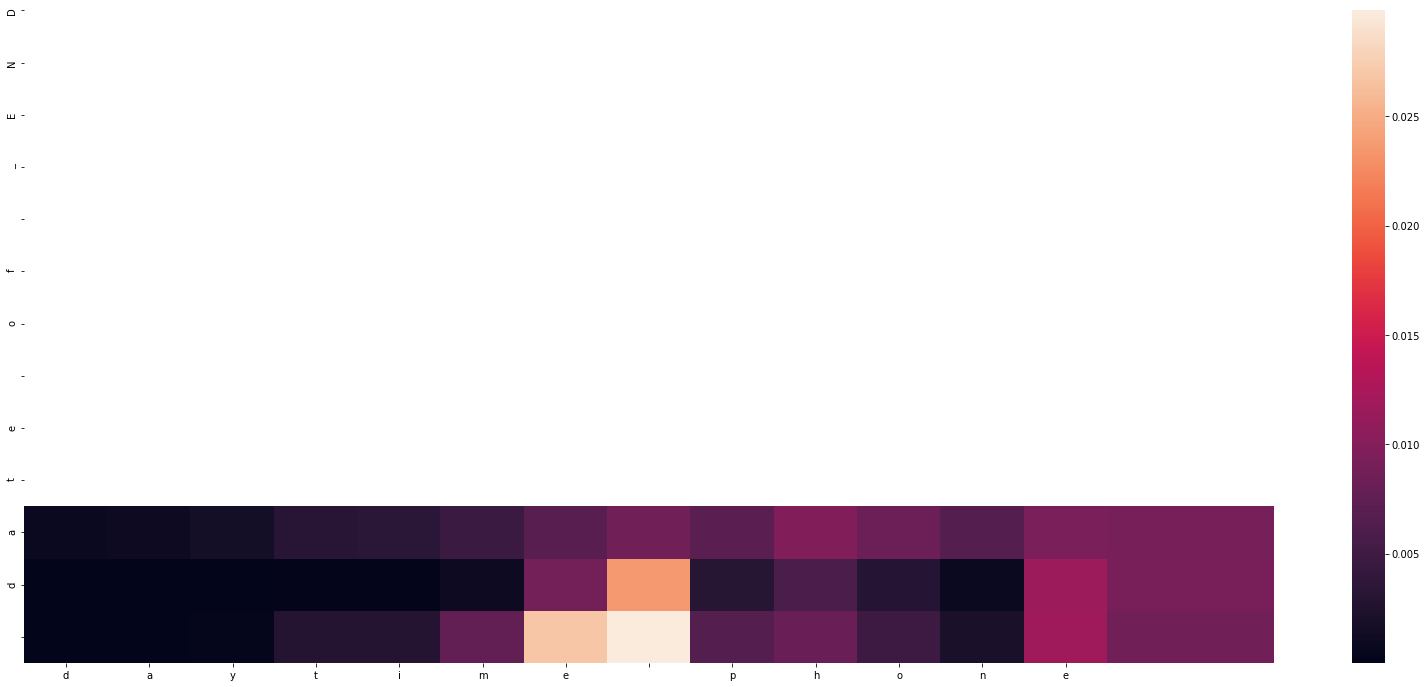

Decoded sentence:  date of _END
-
Input sentence: claim eran r information
GT sentence: START_ claim event information _END


<Figure size 432x288 with 0 Axes>

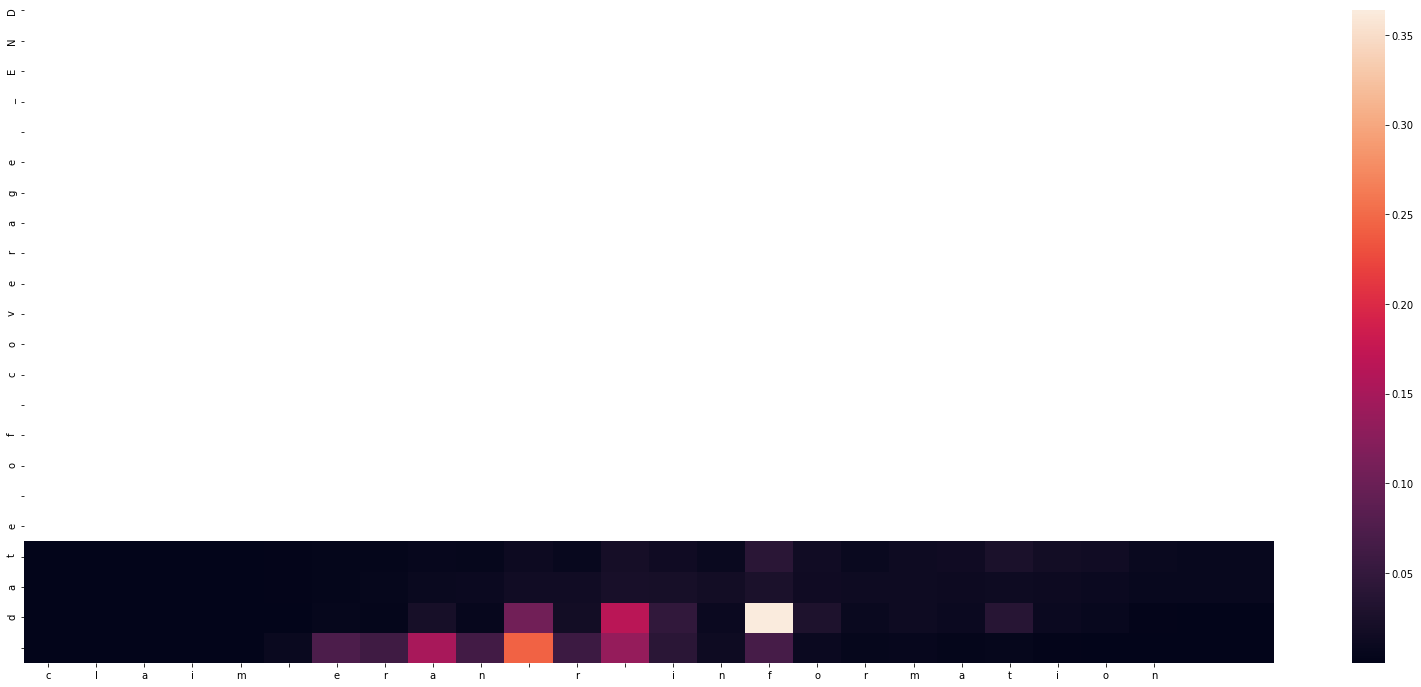

Decoded sentence:  date of coverage _END
-
Input sentence: stopped ‘workinng yes
GT sentence: START_ stopped working yes _END


<Figure size 432x288 with 0 Axes>

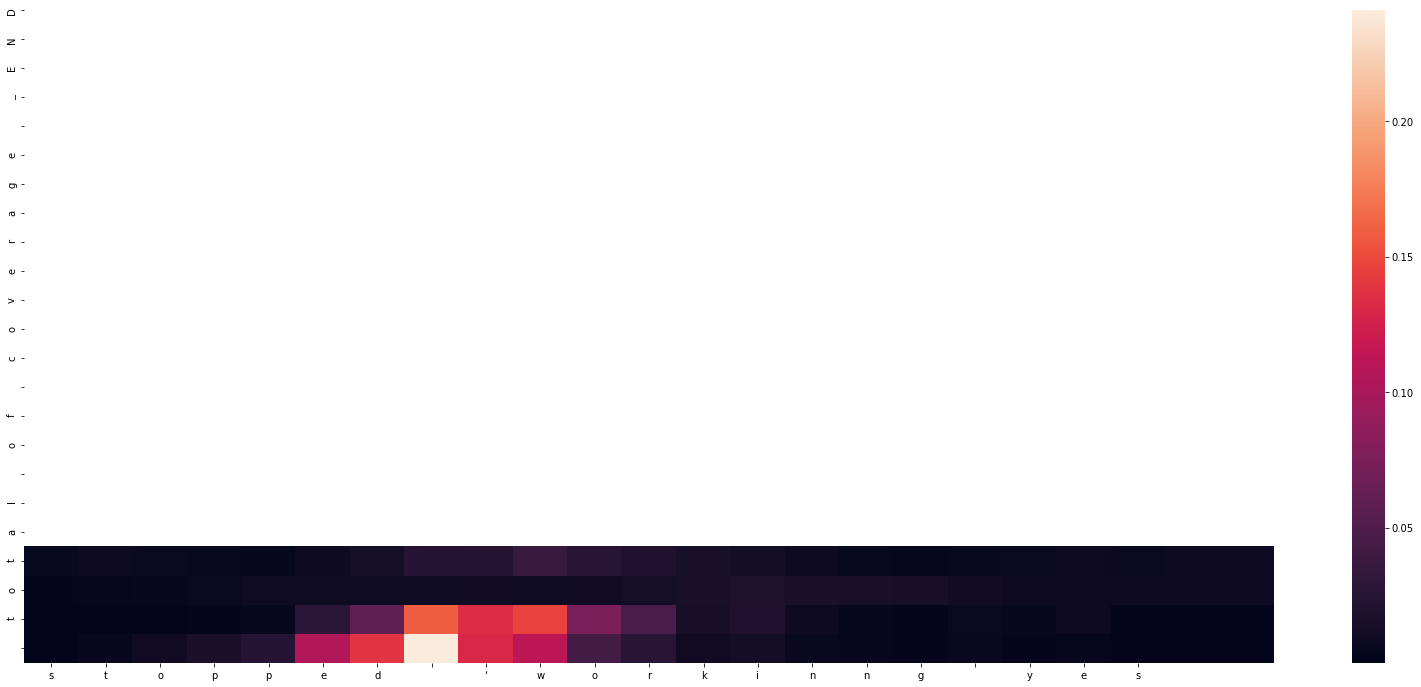

Decoded sentence:  total of coverage _END
-
Input sentence: date last physically at ‘work
GT sentence: START_ date last physically at work _END


<Figure size 432x288 with 0 Axes>

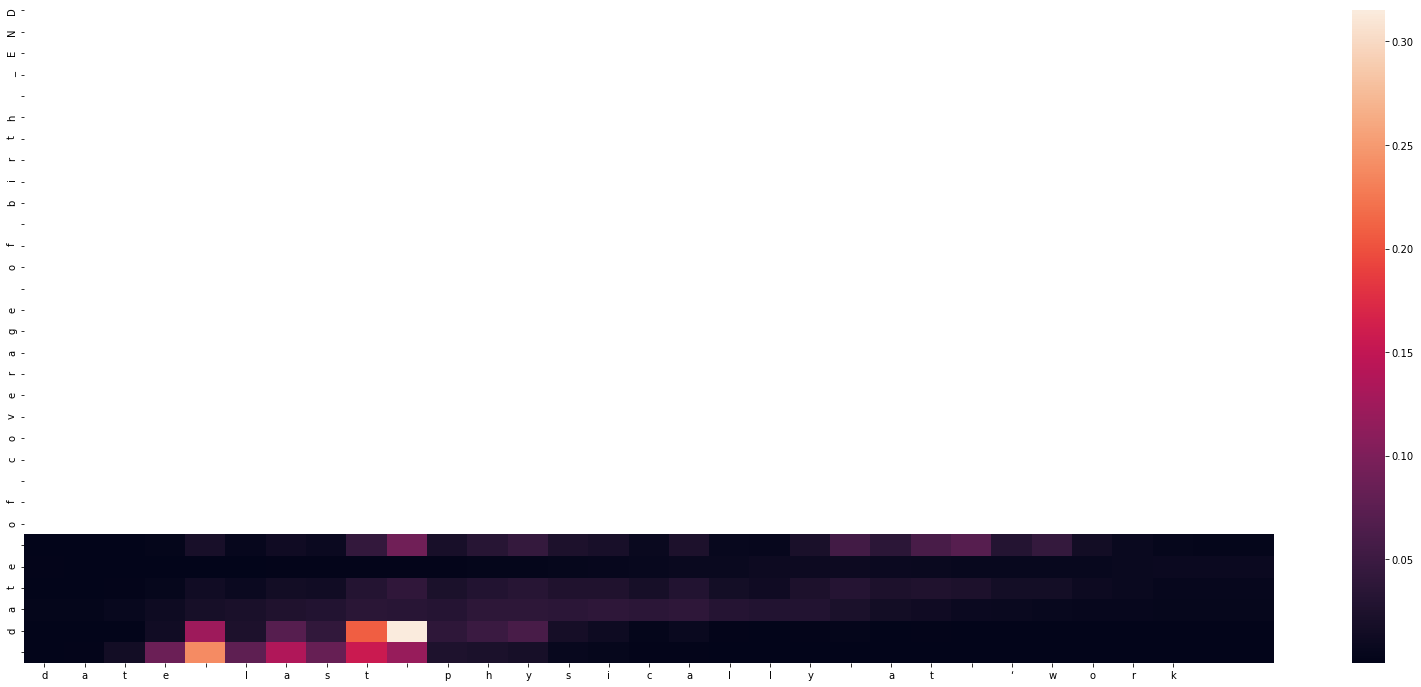

Decoded sentence:  date of coverage of birth _END
-
Input sentence: hours ‘worked on last day 
GT sentence: START_ hours worked on last day  _END


<Figure size 432x288 with 0 Axes>

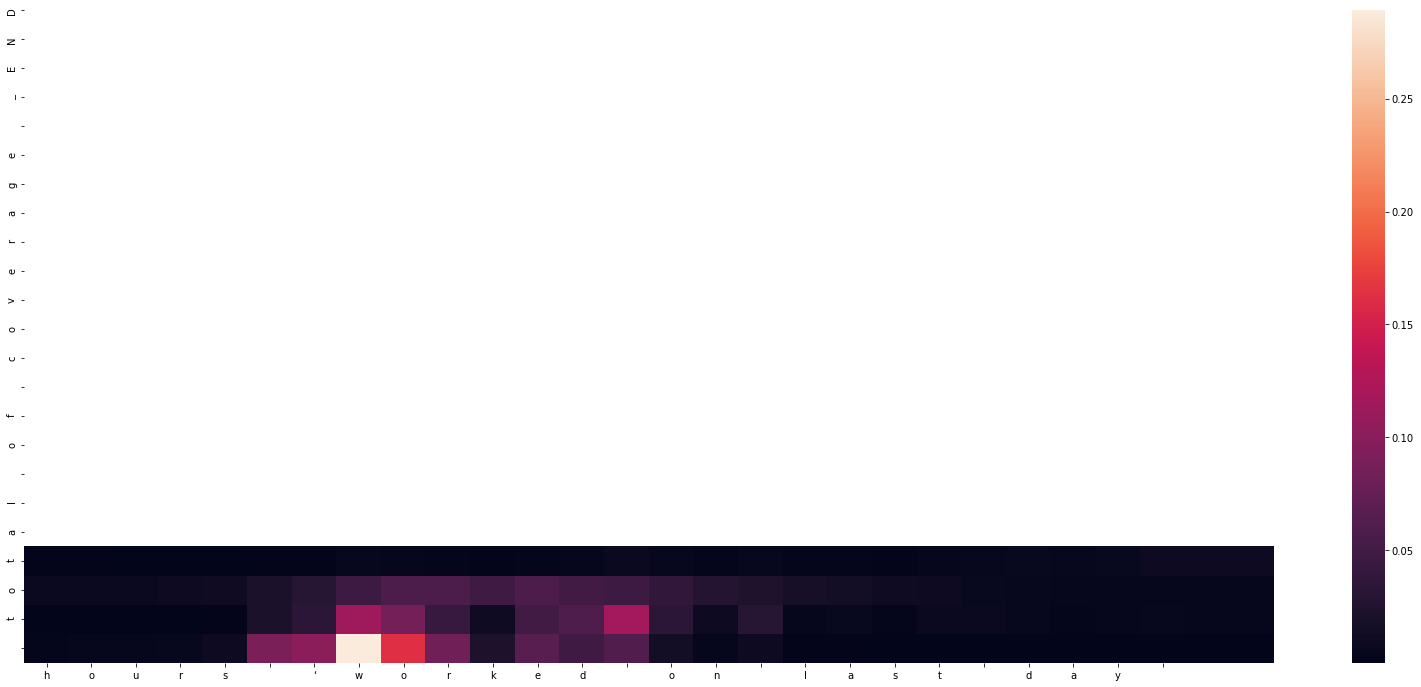

Decoded sentence:  total of coverage _END
-
Input sentence: hours scheduled to work on last day
GT sentence: START_ hours scheduled to work on last day _END


<Figure size 432x288 with 0 Axes>

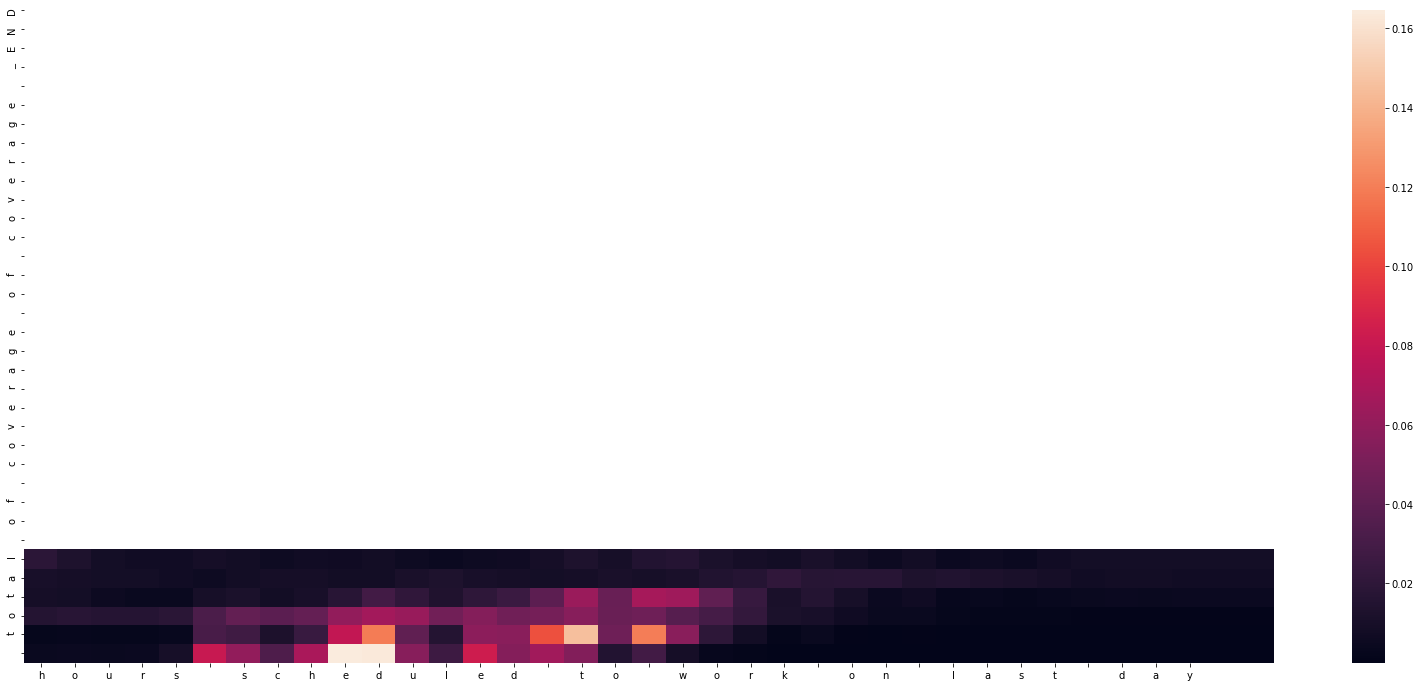

Decoded sentence:  total of coverage of coverage _END
-
Input sentence: explanation ofchange in schedule i was on light duty to injury of wrist but last date worked due to other injury ofknee is what put me out ofwork
GT sentence: START_ explanation of change in schedule i was on light duty to injury of wrist but COMMA last date worked due to other injury of knee is what put me out of work _END


IndexError: ignored

In [ ]:
word_decoded_sents = []
target_sents = []
for seq_index in range(100): #[14077,20122,40035,40064, 40056, 40068, 40090, 40095, 40100, 40119, 40131, 40136, 40150, 40153]:
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence, attention = decode_sequence_attention(input_seq, sep='')
    print('-')
    print('Input sentence:', lines.input[seq_index: seq_index + 1])
    print('GT sentence:', lines.target[seq_index][1:-1])
    print('Decoded sentence:', decoded_sentence)
    word_decoded_sents.append(decoded_sentence)
    target_sents.append(lines.target[seq_index: seq_index][1:-1])

for seq_index in range(100):

    target_text = lines.target[seq_index]
    text = lines.input[seq_index]
    print('-')
    print('Input sentence:', text)    
    print('GT sentence:', target_text)
    decoded_sentence = visualize_attention(text, encoder_model, decoder_model, max_encoder_seq_length, num_decoder_tokens, input_token_index, reverse_target_tok_index, input_tok_split_fn, sep=' ')

    
    print('Decoded sentence:', decoded_sentence)     

In [ ]:
target_sents = list(lines.target[:100])
target_sents = [x[1:-1] for x in target_sents]
word_decoded_sents = [' '.join(x.split()[1:-1]) for x in word_decoded_sents]



In [ ]:
WER_word = calculate_WER(target_sents, word_decoded_sents)
WER_word

0.16073275225291772

# References

- [Sequence to Sequence Learning with Neural Networks](https://arxiv.org/abs/1409.3215)

- [Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation](https://keras.io/examples/lstm_seq2seq/)

- [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473)

- [Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/abs/1508.04025)

- https://github.com/devm2024/nmt_keras/blob/master/base.ipynb
- https://keras.io/examples/lstm_seq2seq/
- https://machinelearningmastery.com/return-sequences-and-return-states-for-lstms-in-keras/